In [1]:
import argparse
import os
from typing import Hashable
from pandas.core.series import Series
import pandas as pd
import numpy as np
from PIL import Image

import boto3

# print(f"SageMaker Version: {sagemaker.__version__}")
# print(f"Installation Path: {sagemaker.__file__}")
import sagemaker
from sagemaker.pytorch import PyTorch
from io import BytesIO
from botocore.exceptions import ClientError
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from io import StringIO

# import sys
import json
import csv

# import pickle
# from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
import seaborn as sns
import torch

# import torchvision
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights, ResNet50_Weights

import torchvision.models as models
import os
import boto3
import psutil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# import seaborn as sns
import os

from PIL import Image
from tqdm import tqdm

import torch
import torchvision.models as models
import torch.nn as nn
import os
from PIL import Image
import io
import torchvision.transforms as transforms
import json

import boto3
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
import datetime
import json

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/amannindra/Library/Application Support/sagemaker/config.yaml


In [2]:
# Configuration
REGION = "us-east-1"
ROLE_ARN = (
    "arn:aws:iam::253490779227:role/service-role/AmazonSageMakerAdminIAMExecutionRole"
)
BUCKET = "animal-classification-virgina"
S3_INPUT_DATA = f"s3://{BUCKET}/data/"
S3_PREPROCESSED = f"s3://{BUCKET}/processed"
S3_SHORT_PREPROCESSED = f"s3://{BUCKET}/short_processed"

In [3]:
def to_hwc3(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:  # (H, W) -> (H, W, 3)
        return np.repeat(img[..., None], 3, axis=2)
    if img.ndim == 3:
        if img.shape[2] == 1:  # (H, W, 1) -> (H, W, 3)
            return np.repeat(img, 3, axis=2)
        if img.shape[2] >= 3:  # (H, W, 3) or (H, W, 4) -> keep first 3
            return img[..., :3]
    raise ValueError(f"Unexpected shape: {img.shape}")

In [4]:
s3 = boto3.client("s3")

In [5]:
bucket_name = "animal-classification-virgina"
train_folder = "processed/train_features"
test_folder = "processed/test_features"
train_features_csv = "processed/train_features.csv"
test_features_csv = "processed/test_features.csv"
train_labels_csv = "processed/train_labels.csv"


train_data = s3.get_object(Bucket=bucket_name, Key=train_labels_csv)
content_train_data = train_data["Body"].read().decode("utf-8")
content_train_data = StringIO(content_train_data)
df_train_data = pd.read_csv(content_train_data)
df_train_data

id  antelope_duiker  bird  blank  civet_genet  hog  leopard  \
0      ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
1      ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
2      ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
3      ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
4      ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   
...         ...              ...   ...    ...          ...  ...      ...   
16483  ZJ016483              0.0   0.0    1.0          0.0  0.0      0.0   
16484  ZJ016484              0.0   0.0    0.0          0.0  0.0      1.0   
16485  ZJ016485              0.0   0.0    0.0          1.0  0.0      0.0   
16486  ZJ016486              0.0   1.0    0.0          0.0  0.0      0.0   
16487  ZJ016487              0.0   0.0    0.0          1.0  0.0      0.0   

       monkey_prosimian  rodent  
0                   0.0     0.0  
1                   1.0     0.0  
2                   0.0     0.0  
3                   1.0     0.0  
4                   0.0     0.0  
...                 ...     ...  
16483               0.0     0.0  
16484               0.0     0.0  
16485               0.0     0.0  
16486               0.0     0.0  
16487               0.0     0.0  

[16488 rows x 9 columns]

In [6]:
train_file = "resnet18/output/train_metrics.json"
val_file = "resnet18/output/val_metrics.json"
train_swin_file = "swinb/output/train_metrics_110.json"
val_swin_file = "swinb/output/val_metrics_110.json"
train_swin_test1_file = "swinb-test1/output/train_metrics_110.json"
val_swin_test1_file = "swinb-test1/output/val_metrics_110.json"
train_swin_test2_file = "swinb-test2/output/train_metrics_110.json"
val_swin_test2_file = "swinb-test2/output/val_metrics_110.json"
train_swin_test3_file = "swinb-test3/output/train_metrics_110.json"
val_swin_test3_file = "swinb-test3/output/val_metrics_110.json"
train_swin_test4_file = "swinb-test4/output/train_metrics_110.json"
val_swin_test4_file = "swinb-test4/output/val_metrics_110.json"
train_swin_final_file = "swinb-final3/output/train_metrics_110.json"
val_swin_final_file = "swinb-final3/output/val_metrics_110.json"
train_convnext1 = "convnext-1/output/train_metrics_110.json"
test_convnext1 = "convnext-1/output/val_metrics_110.json"
train_eva = "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/train_metrics_105.json"
val_eva = "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/val_metrics_105.json"


if os.path.exists(train_file):
    with open(train_file, "r") as f:
        train_metrics = json.load(f)
else:
    print("train_file does not exist")

if os.path.exists(val_file):
    with open(val_file, "r") as f:
        val_metrics = json.load(f)
else:
    print("val_file does not exist")

if os.path.exists(train_swin_file):
    with open(train_swin_file, "r") as f:
        train_metrics_swin = json.load(f)
else:
    print("train_swin_file does not exist")

if os.path.exists(val_swin_file):
    with open(val_swin_file, "r") as f:
        val_metrics_swin = json.load(f)
else:
    print("val_swin_file does not exist")

if os.path.exists(train_swin_test1_file):
    with open(train_swin_test1_file, "r") as f:
        train_metrics_swin_test1 = json.load(f)
else:
    print("train_swin_test1_file does not exist")

if os.path.exists(val_swin_test1_file):
    with open(val_swin_test1_file, "r") as f:
        val_metrics_swin_test1 = json.load(f)
else:
    print("val_swin_test1_file does not exist")

if os.path.exists(train_swin_test2_file):
    with open(train_swin_test2_file, "r") as f:
        train_metrics_swin_test2 = json.load(f)
else:
    print("train_swin_test2_file does not exist")

if os.path.exists(val_swin_test2_file):
    with open(val_swin_test2_file, "r") as f:
        val_metrics_swin_test2 = json.load(f)
else:
    print("val_swin_test2_file does not exist")

if os.path.exists(train_swin_test3_file):
    with open(train_swin_test3_file, "r") as f:
        train_metrics_swin_test3 = json.load(f)
else:
    print("train_swin_test3_file does not exist")

if os.path.exists(val_swin_test3_file):
    with open(val_swin_test3_file, "r") as f:
        val_metrics_swin_test3 = json.load(f)
else:
    print("val_swin_test2_file does not exist")

if os.path.exists(train_swin_test4_file):
    with open(train_swin_test4_file, "r") as f:
        train_metrics_swin_test4 = json.load(f)
else:
    print("train_swin_test4_file does not exist")

if os.path.exists(val_swin_test4_file):
    with open(val_swin_test4_file, "r") as f:
        val_metrics_swin_test4 = json.load(f)
else:
    print("val_swin_test4_file does not exist")

if os.path.exists(train_swin_final_file):
    with open(train_swin_final_file, "r") as f:
        train_metrics_swin_final = json.load(f)
else:
    print("train_swin_final_file does not exist")
if os.path.exists(val_swin_final_file):
    with open(val_swin_final_file, "r") as f:
        val_metrics_swin_final = json.load(f)
else:
    print("val_swin_final_file does not exist")

if os.path.exists(train_convnext1):
    with open(train_convnext1, "r") as f:
        train_metrics_convnext1 = json.load(f)
else:
    print("train_convnext1 does not exist")

if os.path.exists(test_convnext1):
    with open(test_convnext1, "r") as f:
        val_metrics_convnext1 = json.load(f)
else:
    print("test_convnext1 does not exist")

if os.path.exists(train_eva):
    with open(train_eva, "r") as f:
        train_metrics_eva = json.load(f)
else:
    print("train_eva does not exist")

if os.path.exists(val_eva):
    with open(val_eva, "r") as f:
        val_metrics_eva = json.load(f)


class_names = [
    "antelope_duiker",
    "bird",
    "blank",
    "civet_genet",
    "hog",
    "leopard",
    "monkey_prosimian",
    "rodent",
]

class_names = np.array(class_names)

In [7]:
train_metrics_swin_test1

[{'antelope_duiker': {'precision': 0.4894346087949743,
   'recall': 0.4619946091644205,
   'f1-score': 0.4753189129229063,
   'support': 1855.0},
  'bird': {'precision': 0.6128731343283582,
   'recall': 0.5337124289195776,
   'f1-score': 0.5705601389491967,
   'support': 1231.0},
  'blank': {'precision': 0.4140091116173121,
   'recall': 0.43795180722891563,
   'f1-score': 0.42564402810304447,
   'support': 1660.0},
  'civet_genet': {'precision': 0.685472496473907,
   'recall': 0.802421574023115,
   'f1-score': 0.7393509127789046,
   'support': 1817.0},
  'hog': {'precision': 0.7689530685920578,
   'recall': 0.5803814713896458,
   'f1-score': 0.6614906832298136,
   'support': 734.0},
  'leopard': {'precision': 0.7902055622732769,
   'recall': 0.7733727810650888,
   'f1-score': 0.7816985645933014,
   'support': 1690.0},
  'monkey_prosimian': {'precision': 0.5464788732394367,
   'recall': 0.622792937399679,
   'f1-score': 0.582145536384096,
   'support': 1869.0},
  'rodent': {'precision':

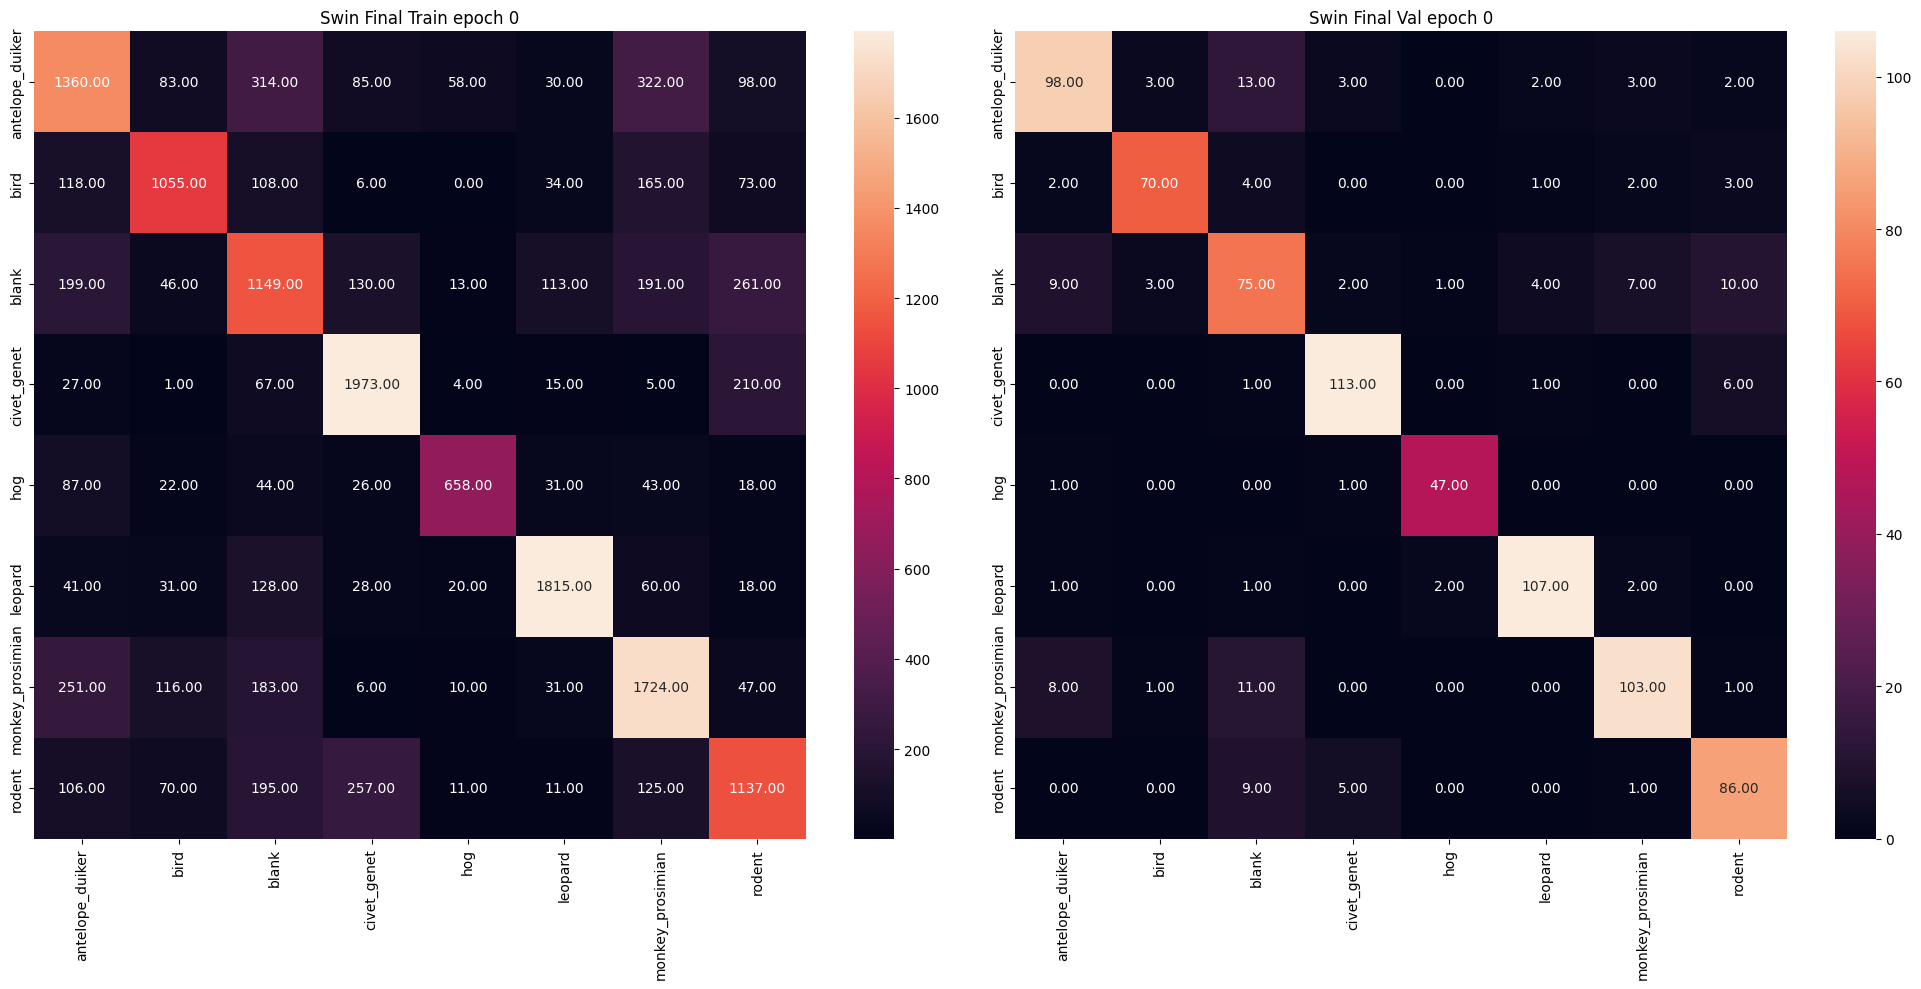

In [8]:
def plot_confusion_matrix(train, val, class_names, epoch, title):
    cm = train[epoch]["confusion_matrix"]
    cm_val = val[epoch]["confusion_matrix"]
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax[0],
        robust=True,
    )
    sns.heatmap(
        cm_val,
        annot=True,
        fmt=".2f",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax[1],
        robust=True,
    )
    ax[0].set_title(title + " Train epoch " + str(epoch))
    ax[1].set_title(title + " Val epoch " + str(epoch))


# plot_confusion_matrix(train_metrics, val_metrics, class_names, 0, "Resnet18")
# plot_confusion_matrix(train_metrics_swin, val_metrics_swin, class_names, 0, "Swin")
# plot_confusion_matrix(train_metrics_swin_test1, val_metrics_swin_test1, class_names, 0, "Swin Test1")
# plot_confusion_matrix(train_metrics_swin_test2, val_metrics_swin_test2, class_names, 0, "Swin Test2")
# plot_confusion_matrix(train_metrics_swin_test3, val_metrics_swin_test3, class_names, 0, "Swin Test3")
# plot_confusion_matrix(train_metrics_swin_test4, val_metrics_swin_test4, class_names, 0, "Swin Test4")
plot_confusion_matrix(
    train_metrics_swin_final, val_metrics_swin_final, class_names, 0, "Swin Final"
)
plt.tight_layout()
plt.show()

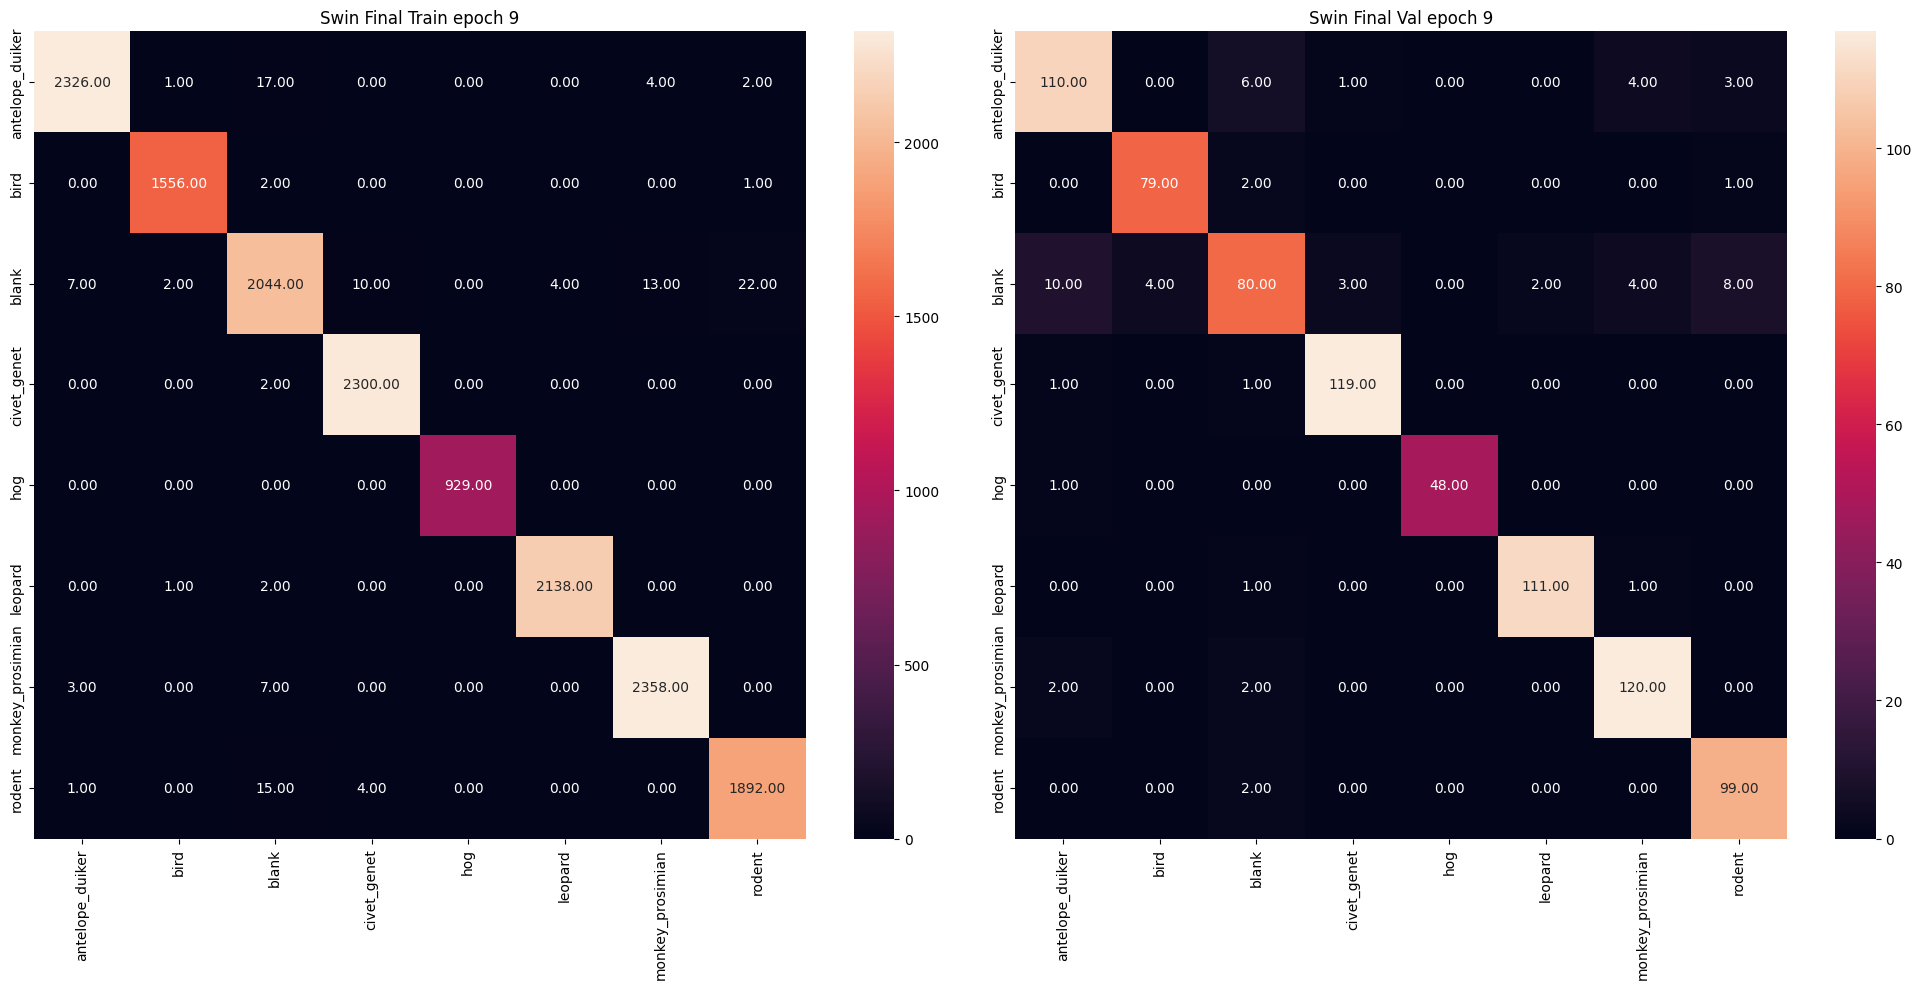

In [9]:
# plot_confusion_matrix(train_metrics, val_metrics, class_names, 9, "Resnet18")
# plot_confusion_matrix(train_metrics_swin, val_metrics_swin, class_names, 9, "Swin")
# plot_confusion_matrix(train_metrics_swin_test1, val_metrics_swin_test1, class_names, 9, "Swin Test1")
# plot_confusion_matrix(train_metrics_swin_test2, val_metrics_swin_test2, class_names, 9, "Swin Test2")
# plot_confusion_matrix(train_metrics_swin_test3, val_metrics_swin_test3, class_names, 9, "Swin Test3")
# plot_confusion_matrix(train_metrics_swin_test4, val_metrics_swin_test4, class_names, 9, "Swin Test4")
plot_confusion_matrix(
    train_metrics_swin_final, val_metrics_swin_final, class_names, 9, "Swin Final"
)

plt.tight_layout()
plt.show()

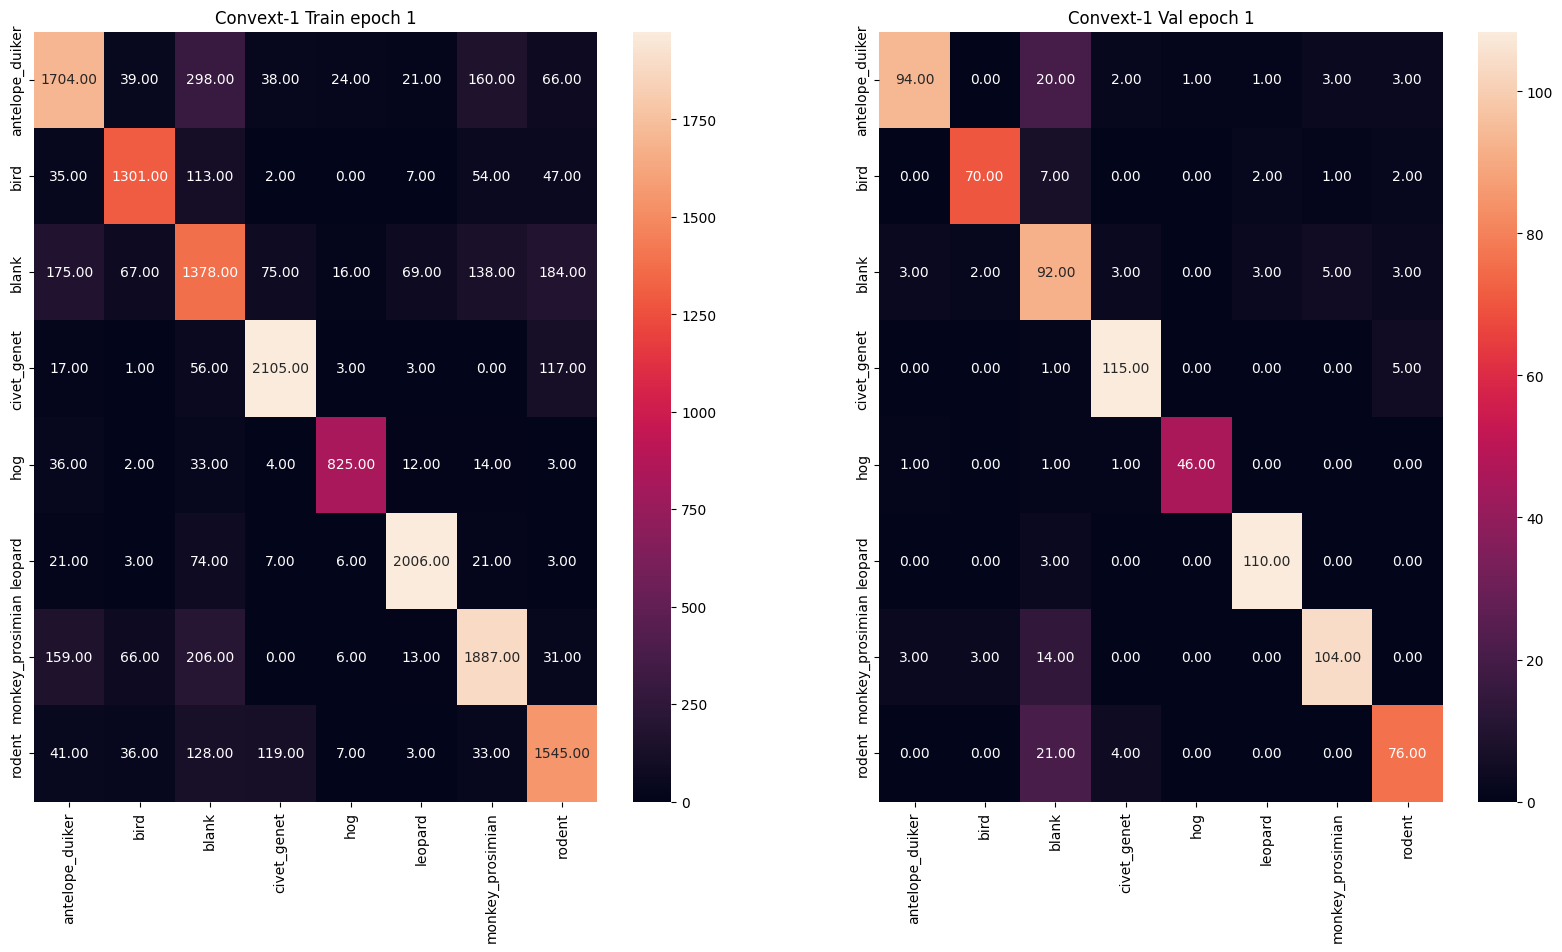

In [10]:
plot_confusion_matrix(
    train_metrics_convnext1, val_metrics_convnext1, class_names, 1, "Convext-1"
)

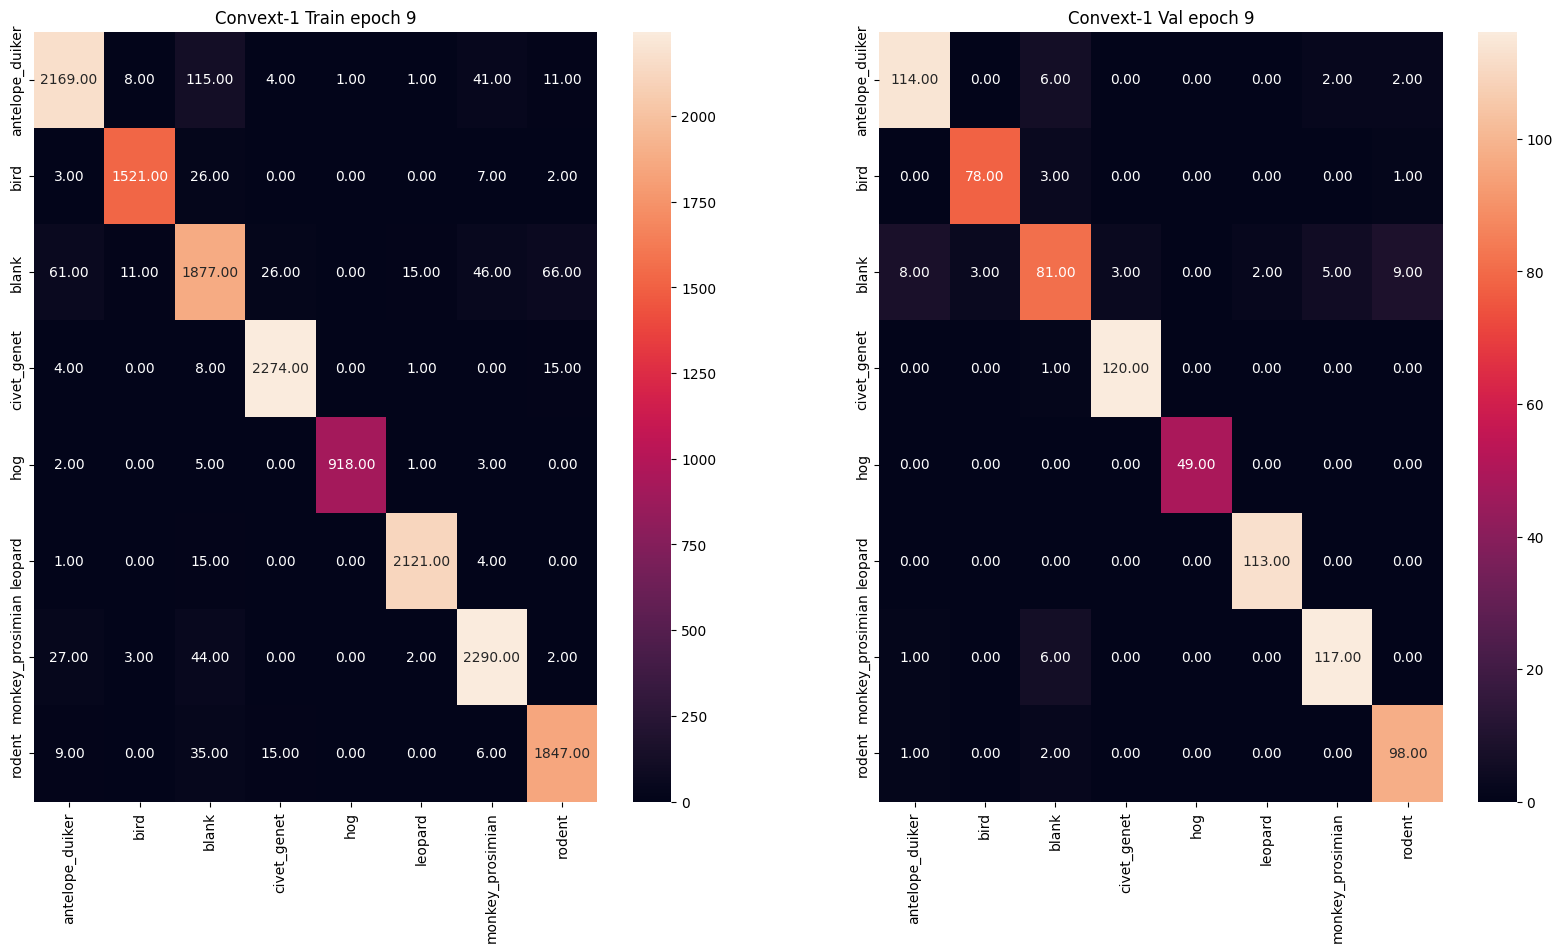

In [11]:
plot_confusion_matrix(
    train_metrics_convnext1, val_metrics_convnext1, class_names, 9, "Convext-1"
)

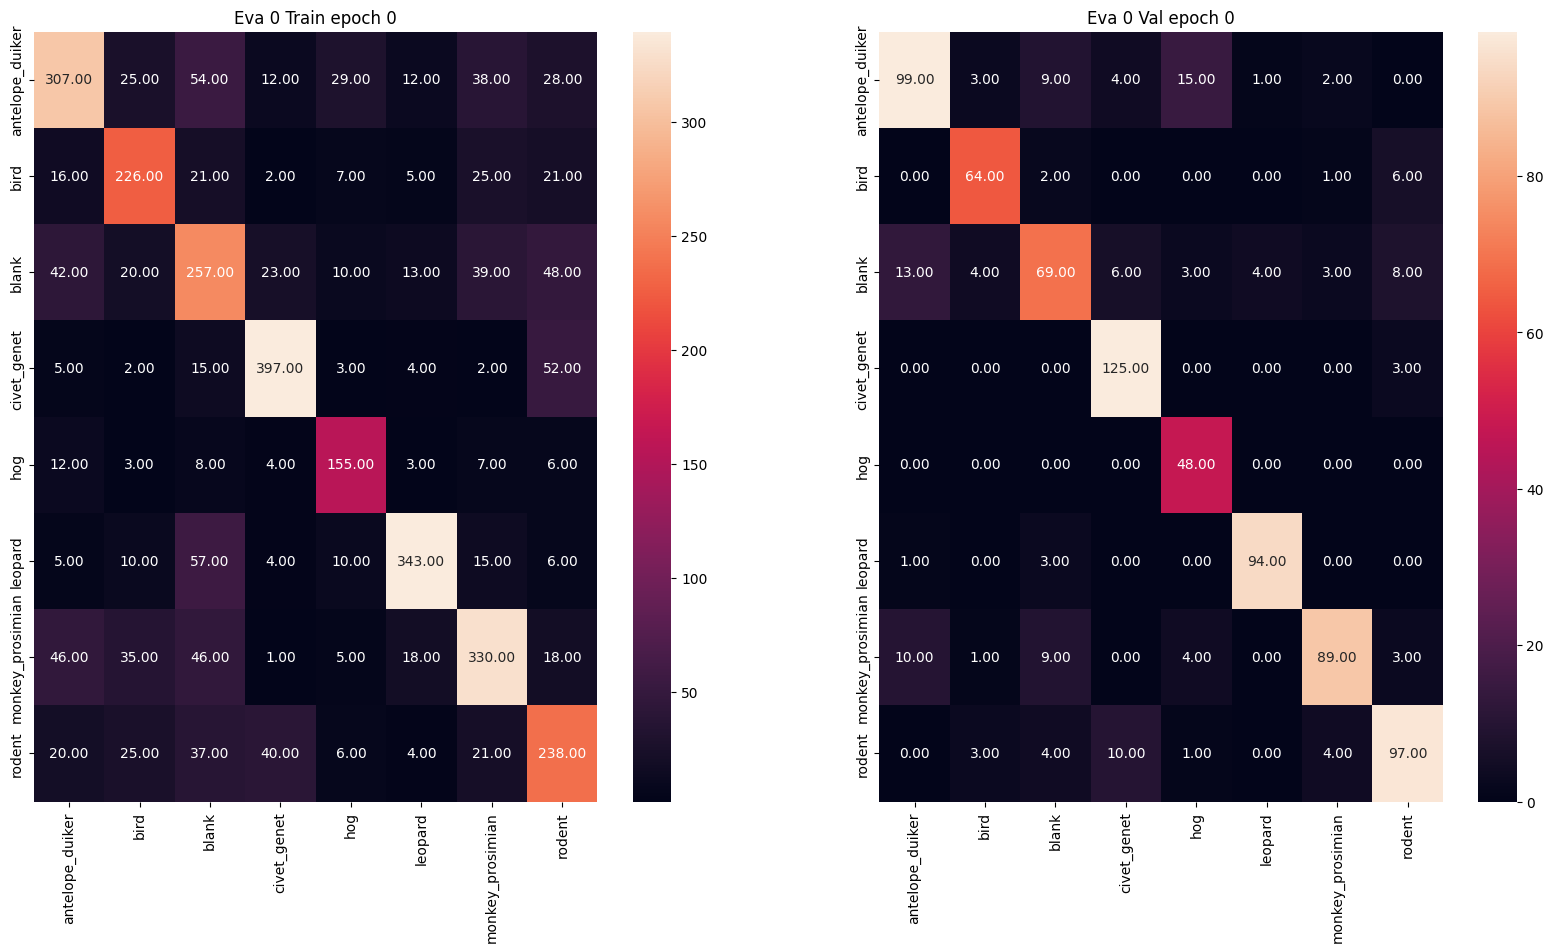

In [12]:
plot_confusion_matrix(train_metrics_eva, val_metrics_eva, class_names, 0, "Eva 0")

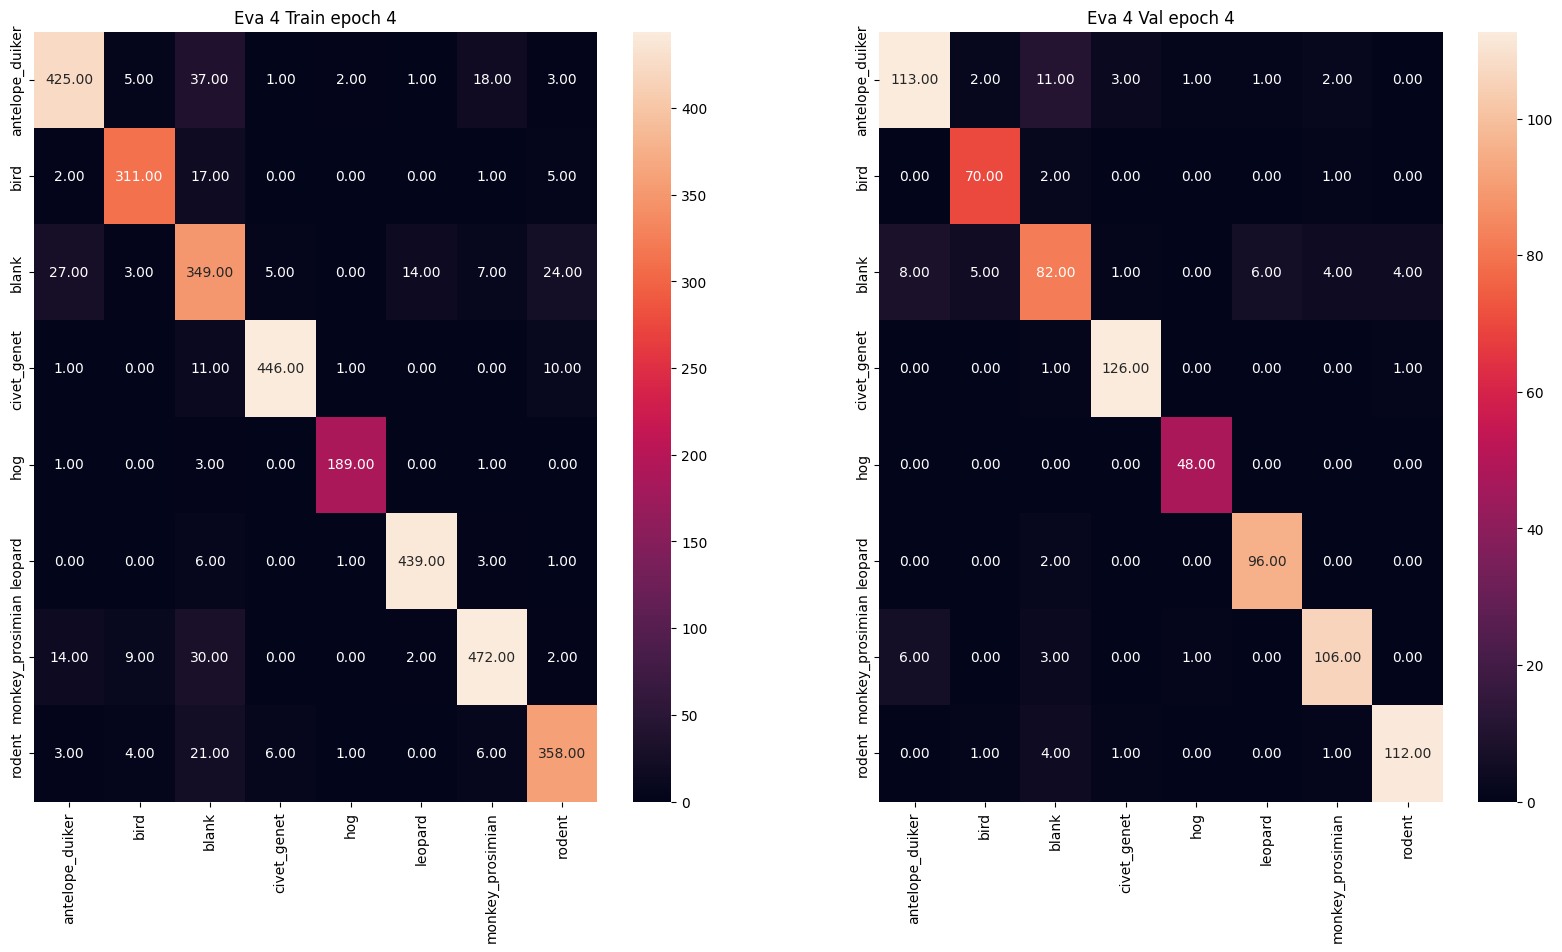

In [13]:
plot_confusion_matrix(train_metrics_eva, val_metrics_eva, class_names, 4, "Eva 4")

In [51]:
if os.path.exists("resnet18/output/train_metrics.csv"):
    train_df = pd.read_csv("resnet18/output/train_metrics.csv")
else:
    print("resnet18/output/train_metrics.csv does not exist")

if os.path.exists("resnet18/output/val_metrics.csv"):
    val_df = pd.read_csv("resnet18/output/val_metrics.csv")

if os.path.exists("swinb/output/train_metrics_110.csv"):
    train_df_swin = pd.read_csv("swinb/output/train_metrics_110.csv")
else:
    print("swinb/output/train_metrics_110.csv does not exist")

if os.path.exists("swinb/output/val_metrics_110.csv"):
    val_df_swin = pd.read_csv("swinb/output/val_metrics_110.csv")
else:
    print("swinb/output/val_metrics_110.csv does not exist")


if os.path.exists("swinb-test1/output/train_metrics_110.csv"):
    train_df_swin_test1 = pd.read_csv("swinb-test1/output/train_metrics_110.csv")
else:
    print("swinb-test1/output/train_metrics_110.csv does not exist")
    keys = list(train_metrics_swin_test1[0].keys())

    train_df_swin_test1 = pd.DataFrame(columns=keys)
    for i in range(len(train_metrics_swin_test1)):
        row_dict = {k: train_metrics_swin_test1[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        train_df_swin_test1 = pd.concat(
            [train_df_swin_test1, each_row], ignore_index=True
        )

if os.path.exists("swinb-test1/output/val_metrics_110.csv"):
    val_df_swin_test1 = pd.read_csv("swinb-test1/output/val_metrics_110.csv")
else:
    print("swinb-test1/output/val_metrics_110.csv does not exist")
    keys = list(val_metrics_swin_test1[0].keys())

    val_df_swin_test1 = pd.DataFrame(columns=keys)
    for i in range(len(val_metrics_swin_test1)):
        row_dict = {k: val_metrics_swin_test1[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        val_df_swin_test1 = pd.concat([val_df_swin_test1, each_row], ignore_index=True)


if os.path.exists("swinb-test2/output/train_metrics_110.csv"):
    train_df_swin_test2 = pd.read_csv("swinb-test2/output/train_metrics_110.csv")
else:
    print("swinb-test2/output/train_metrics_110.csv does not exist")
    keys = list(train_metrics_swin_test2[0].keys())

    train_df_swin_test2 = pd.DataFrame(columns=keys)
    for i in range(len(train_metrics_swin_test2)):
        row_dict = {k: train_metrics_swin_test2[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        train_df_swin_test2 = pd.concat(
            [train_df_swin_test2, each_row], ignore_index=True
        )

if os.path.exists("swinb-test2/output/val_metrics_110.csv"):
    val_df_swin_test2 = pd.read_csv("swinb-test2/output/val_metrics_110.csv")
else:
    print("swinb-test2/output/val_metrics_110.csv does not exist")
    keys = list(val_metrics_swin_test2[0].keys())

    val_df_swin_test2 = pd.DataFrame(columns=keys)
    for i in range(len(val_metrics_swin_test2)):
        row_dict = {k: val_metrics_swin_test2[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        val_df_swin_test2 = pd.concat([val_df_swin_test2, each_row], ignore_index=True)

if os.path.exists("swinb-test3/output/train_metrics_110.csv"):
    train_df_swin_test3 = pd.read_csv("swinb-test3/output/train_metrics_110.csv")
else:
    print("swinb-test3/output/train_metrics_110.csv does not exist")
    keys = list(train_metrics_swin_test3[0].keys())

    train_df_swin_test3 = pd.DataFrame(columns=keys)
    for i in range(len(train_metrics_swin_test3)):
        row_dict = {k: train_metrics_swin_test3[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        train_df_swin_test3 = pd.concat(
            [train_df_swin_test3, each_row], ignore_index=True
        )

if os.path.exists("swinb-test3/output/val_metrics_110.csv"):
    val_df_swin_test3 = pd.read_csv("swinb-test3/output/val_metrics_110.csv")
else:
    print("swinb-test2/output/val_metrics_110.csv does not exist")
    keys = list(val_metrics_swin_test3[0].keys())

    val_df_swin_test3 = pd.DataFrame(columns=keys)
    for i in range(len(val_metrics_swin_test3)):
        row_dict = {k: val_metrics_swin_test3[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        val_df_swin_test3 = pd.concat([val_df_swin_test3, each_row], ignore_index=True)

if os.path.exists("swinb-test4/output/train_metrics_110.csv"):
    train_df_swin_test4 = pd.read_csv("swinb-test4/output/train_metrics_110.csv")
else:
    print("swinb-test4/output/train_metrics_110.csv does not exist")
    keys = list(train_metrics_swin_test4[0].keys())

    train_df_swin_test4 = pd.DataFrame(columns=keys)
    for i in range(len(train_metrics_swin_test4)):
        row_dict = {k: train_metrics_swin_test4[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        train_df_swin_test4 = pd.concat(
            [train_df_swin_test4, each_row], ignore_index=True
        )

if os.path.exists("swinb-test4/output/val_metrics_110.csv"):
    val_df_swin_test4 = pd.read_csv("swinb-test4/output/val_metrics_110.csv")
else:
    print("swinb-test4/output/val_metrics_110.csv does not exist")
    keys = list(val_metrics_swin_test4[0].keys())
    val_df_swin_test4 = pd.DataFrame(columns=keys)
    for i in range(len(val_metrics_swin_test4)):
        row_dict = {k: val_metrics_swin_test4[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        val_df_swin_test4 = pd.concat([val_df_swin_test4, each_row], ignore_index=True)

if os.path.exists("swinb-final3/output/train_metrics_110.csv"):
    train_df_swin_final = pd.read_csv("swinb-final3/output/train_metrics_110.csv")
else:
    print("swinb-final3/output/train_metrics_110.csv does not exist")
    keys = list(train_metrics_swin_final[0].keys())
    train_df_swin_final = pd.DataFrame(columns=keys)
    for i in range(len(train_metrics_swin_final)):
        row_dict = {k: train_metrics_swin_final[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        train_df_swin_final = pd.concat(
            [train_df_swin_final, each_row], ignore_index=True
        )
if os.path.exists("swinb-final3/output/val_metrics_110.csv"):
    val_df_swin_final = pd.read_csv("swinb-final3/output/val_metrics_110.csv")
else:
    print("swinb-final3/output/val_metrics_110.csv does not exist")
    keys = list(val_metrics_swin_final[0].keys())
    val_df_swin_final = pd.DataFrame(columns=keys)
    for i in range(len(val_metrics_swin_final)):
        row_dict = {k: val_metrics_swin_final[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        val_df_swin_final = pd.concat([val_df_swin_final, each_row], ignore_index=True)


if os.path.exists("convnext-1/output/train_metrics_110.csv"):
    train_df_convnext_final = pd.read_csv("swinb-final3/output/train_metrics_110.csv")
else:
    print("convnext-1/output/train_metrics_110.csv does not exist")
    keys = list(train_metrics_swin_final[0].keys())
    train_df_convnext_final = pd.DataFrame(columns=keys)
    for i in range(len(train_metrics_swin_final)):
        row_dict = {k: train_metrics_swin_final[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        train_df_convnext_final = pd.concat(
            [train_df_swin_final, each_row], ignore_index=True
        )

if os.path.exists("convnext-1/output/val_metrics_110.csv"):
    val_df_swin_final = pd.read_csv("convnext-1/output/val_metrics_110.csv")
else:
    print("convnext-1/output/val_metrics_110.csv does not exist")
    keys = list(val_metrics_swin_final[0].keys())
    val_df_convnext_final = pd.DataFrame(columns=keys)
    for i in range(len(val_metrics_swin_final)):
        row_dict = {k: val_metrics_swin_final[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        val_df_convnext_final = pd.concat(
            [val_df_swin_final, each_row], ignore_index=True
        )


if os.path.exists(
    "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/val_metrics_105.csv"
):
    keys = list(val_metrics_eva[0].keys())
    val_df_eva = pd.DataFrame(columns=keys)
    for i in range(len(val_metrics_eva)):
        row_dict = {k: val_metrics_eva[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        val_df_eva = pd.concat([val_df_eva, each_row], ignore_index=True)
else:
    print(
        "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/val_metrics_105.csv does not exist"
    )

if os.path.exists(
    "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/train_metrics_105.csv"
):

    keys = list(train_metrics_eva[0].keys())
    train_df_eva = pd.DataFrame(columns=keys)
    for i in range(len(train_metrics_eva)):
        row_dict = {k: train_metrics_eva[i][k] for k in keys}
        each_row = pd.DataFrame([row_dict])  # one-row df
        train_df_eva = pd.concat([train_df_eva, each_row], ignore_index=True)
else:
    print(
        "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/train_metrics_105.csv does not exist"
    )


# train_df_eva = pd.read_json(
#     "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/train_metrics_105.json"
# )
# val_df_eva = pd.read_json(
#     "all-7/model_eva_large_patch14_336.in22k_ft_in22k_in1k/transform_1/data/val_metrics_105.json"
# )

swinb-test1/output/train_metrics_110.csv does not exist
swinb-test1/output/val_metrics_110.csv does not exist
swinb-test2/output/train_metrics_110.csv does not exist
swinb-test2/output/val_metrics_110.csv does not exist
swinb-test3/output/train_metrics_110.csv does not exist
swinb-test2/output/val_metrics_110.csv does not exist
swinb-test4/output/train_metrics_110.csv does not exist
swinb-test4/output/val_metrics_110.csv does not exist
swinb-final3/output/train_metrics_110.csv does not exist
swinb-final3/output/val_metrics_110.csv does not exist
convnext-1/output/train_metrics_110.csv does not exist
convnext-1/output/val_metrics_110.csv does not exist


/var/folders/4m/b6_cz0w13g31tffdygtbhty00000gn/T/ipykernel_32361/1946981395.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df_swin_test1 = pd.concat(
/var/folders/4m/b6_cz0w13g31tffdygtbhty00000gn/T/ipykernel_32361/1946981395.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  val_df_swin_test1 = pd.concat([val_df_swin_test1, each_row], ignore_index=True)
/var/folders/4m/b6_cz0w13g31tffdygtbhty00000gn/T/ipykernel_32361/1946981395.py:57: FutureWarning: The behavior of DataFrame conca

In [52]:
train_df.columns

Index(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard',
       'monkey_prosimian', 'rodent', 'accuracy', 'macro avg', 'weighted avg',
       'confusion_matrix', 'loss', 'acc', 'log_loss', 'top3_accuracy',
       'class_confidences', 'macro_precision', 'macro_recall', 'macro_f1',
       'epoch', 'class_f1s', 'class_precisions', 'class_recalls'],
      dtype='object')

model Resnet

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.5459 |     1.3178 |     1.3178 |     0.8155
     1 |   0.7504 |     0.7724 |     0.7724 |     0.9465
     2 |   0.8350 |     0.5382 |     0.5382 |     0.9760
     3 |   0.8816 |     0.3880 |     0.3880 |     0.9881
     4 |   0.9169 |     0.2852 |     0.2852 |     0.9950
     5 |   0.9386 |     0.2150 |     0.2150 |     0.9976
     6 |   0.9570 |     0.1621 |     0.1621 |     0.9992
     7 |   0.9681 |     0.1256 |     0.1256 |     0.9992
     8 |   0.9786 |     0.0908 |     0.0908 |     0.9999
     9 |   0.9837 |     0.0722 |     0.0722 |     1.0000

Val
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------

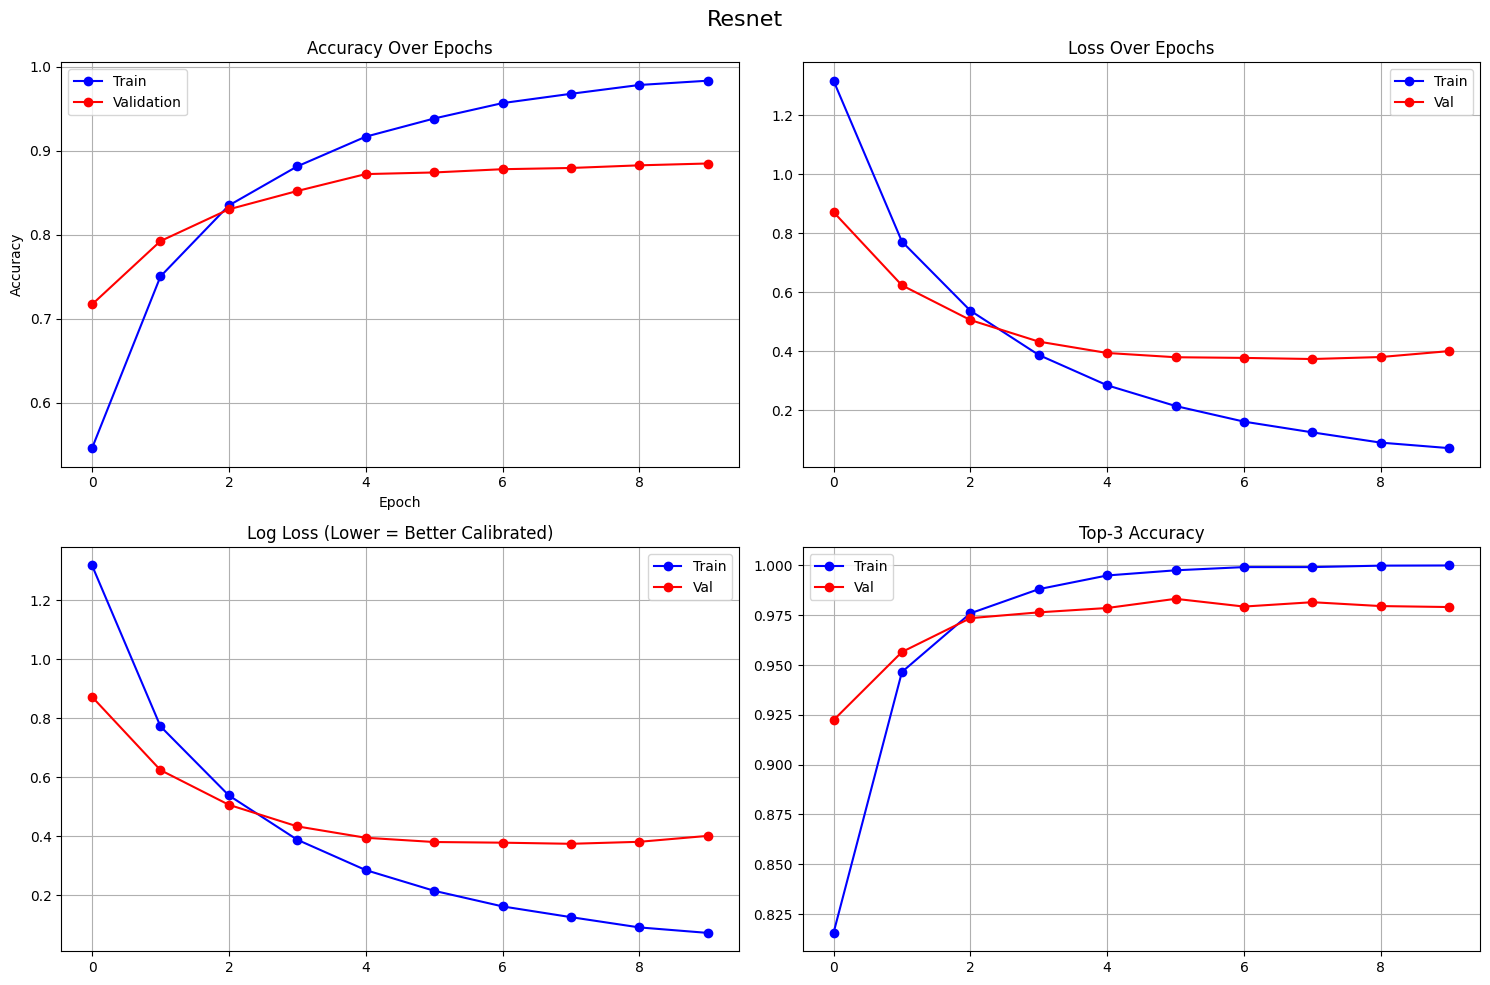

In [53]:
def print_metrics(title, epochs, acc, loss, log_loss, top3_acc):
    print(f"\n{title}")
    print("-" * 90)
    print(
        f"{'Epoch':>6} | {'Acc':>8} | {'Loss':>10} | {'LogLoss':>10} | {'Top-3 Acc':>10}"
    )
    print("-" * 90)

    for i, epoch in enumerate(epochs):
        print(
            f"{epoch:>6} | "
            f"{acc[i]:>8.4f} | "
            f"{loss[i]:>10.4f} | "
            f"{log_loss[i]:>10.4f} | "
            f"{top3_acc[i]:>10.4f}"
        )


def plot_data_over_time(set_train_df, set_val_df, title):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    plt.suptitle(title, fontsize=16)

    epochs = set_train_df["epoch"]
    acc = set_train_df["acc"]
    loss = set_train_df["loss"]
    log_loss = set_train_df["log_loss"]
    top3_accuracy = set_train_df["top3_accuracy"]

    epochs_val = set_val_df["epoch"]
    acc_val = set_val_df["acc"]
    loss_val = set_val_df["loss"]
    log_loss_val = set_val_df["log_loss"]
    top3_accuracy_val = set_val_df["top3_accuracy"]

    print("model", title)
    print_metrics("Train", epochs, acc, loss, log_loss, top3_accuracy)
    print_metrics("Val", epochs_val, acc_val, loss_val, log_loss_val, top3_accuracy)

    axes[0, 0].plot(epochs, acc, "b-o", label="Train")
    axes[0, 0].plot(epochs_val, acc_val, "r-o", label="Validation")
    axes[0, 0].set_title("Accuracy Over Epochs")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(epochs, loss, "b-o", label="Train")
    axes[0, 1].plot(epochs_val, loss_val, "r-o", label="Val")
    axes[0, 1].set_title("Loss Over Epochs")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Log Loss (confidence quality)
    axes[1, 0].plot(epochs, log_loss, "b-o", label="Train")
    axes[1, 0].plot(epochs_val, log_loss_val, "r-o", label="Val")
    axes[1, 0].set_title("Log Loss (Lower = Better Calibrated)")
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Top-3 Accuracy
    axes[1, 1].plot(epochs, top3_accuracy, "b-o", label="Train")
    axes[1, 1].plot(epochs_val, top3_accuracy_val, "r-o", label="Val")
    axes[1, 1].set_title("Top-3 Accuracy")
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


plot_data_over_time(train_df, val_df, "Resnet")

model Swin

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.6862 |     0.8917 |     0.8917 |     0.9097
     1 |   0.8469 |     0.4627 |     0.4627 |     0.9735
     2 |   0.8950 |     0.3136 |     0.3136 |     0.9884
     3 |   0.9296 |     0.2152 |     0.2152 |     0.9948
     4 |   0.9524 |     0.1531 |     0.1531 |     0.9966
     5 |   0.9638 |     0.1134 |     0.1134 |     0.9981
     6 |   0.9760 |     0.0740 |     0.0740 |     0.9992
     7 |   0.9846 |     0.0495 |     0.0495 |     0.9997
     8 |   0.9870 |     0.0375 |     0.0375 |     0.9998
     9 |   0.9908 |     0.0304 |     0.0304 |     0.9998

Val
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
--------------------

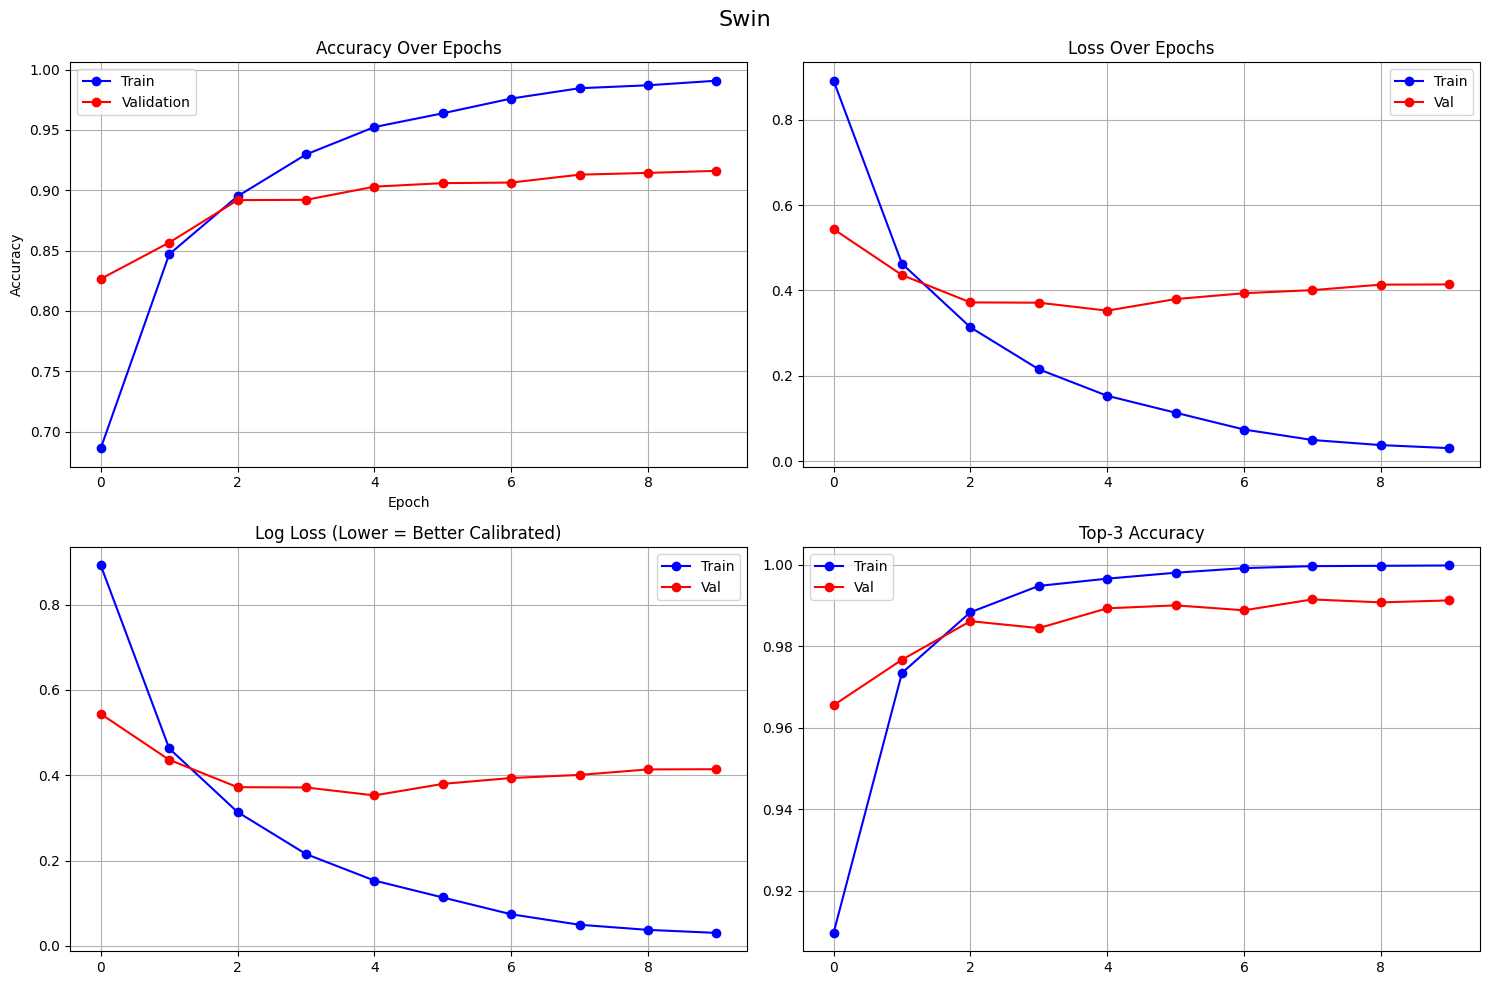

In [54]:
plot_data_over_time(train_df_swin, val_df_swin, "Swin")

model Swin Test1

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.5898 |     1.1122 |     1.1122 |     0.8628
     1 |   0.7456 |     0.7090 |     0.7090 |     0.9476
     2 |   0.7948 |     0.5722 |     0.5722 |     0.9669
     3 |   0.8374 |     0.4598 |     0.4598 |     0.9774
     4 |   0.8662 |     0.3795 |     0.3795 |     0.9858
     5 |   0.8871 |     0.3235 |     0.3235 |     0.9888
     6 |   0.9072 |     0.2656 |     0.2656 |     0.9922
     7 |   0.9143 |     0.2378 |     0.2378 |     0.9932
     8 |   0.9256 |     0.2085 |     0.2085 |     0.9951
     9 |   0.9328 |     0.1920 |     0.1920 |     0.9956

Val
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
--------------

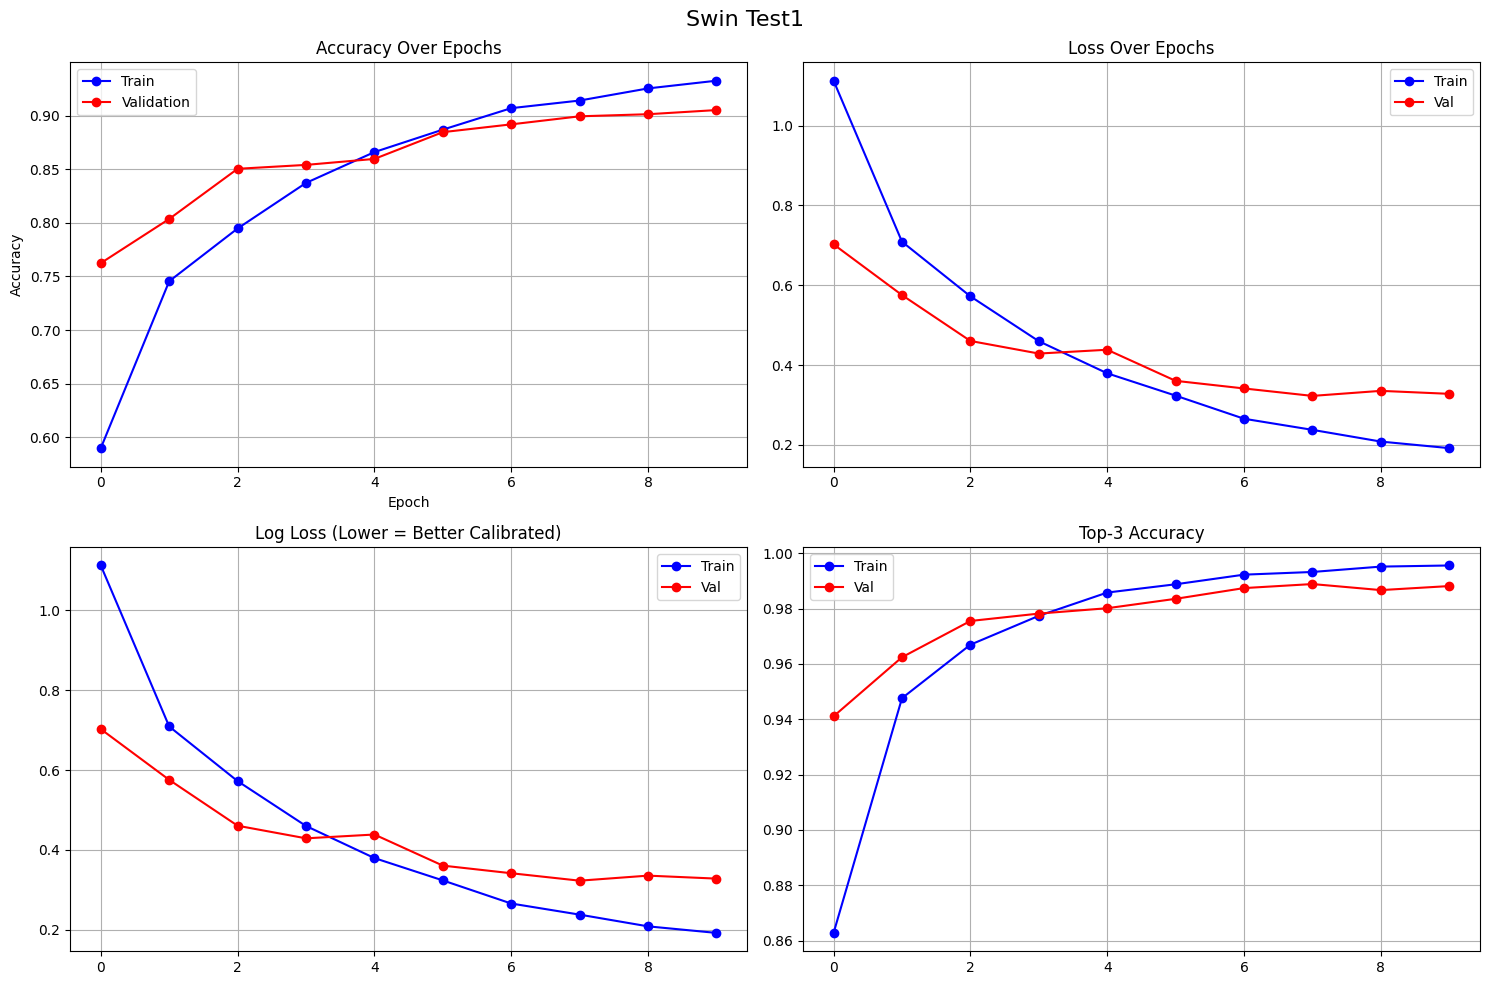

In [55]:
plot_data_over_time(train_df_swin_test1, val_df_swin_test1, "Swin Test1")

model Swin Test2

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.6545 |     0.9641 |     0.9641 |     0.8905
     1 |   0.8252 |     0.5079 |     0.5079 |     0.9697
     2 |   0.8776 |     0.3608 |     0.3608 |     0.9854
     3 |   0.9067 |     0.2666 |     0.2666 |     0.9928
     4 |   0.9299 |     0.1934 |     0.1934 |     0.9966
     5 |   0.9444 |     0.1596 |     0.1596 |     0.9980
     6 |   0.9621 |     0.1100 |     0.1100 |     0.9991
     7 |   0.9684 |     0.0889 |     0.0889 |     0.9992
     8 |   0.9762 |     0.0678 |     0.0678 |     0.9994
     9 |   0.9788 |     0.0623 |     0.0623 |     0.9997

Val
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
--------------

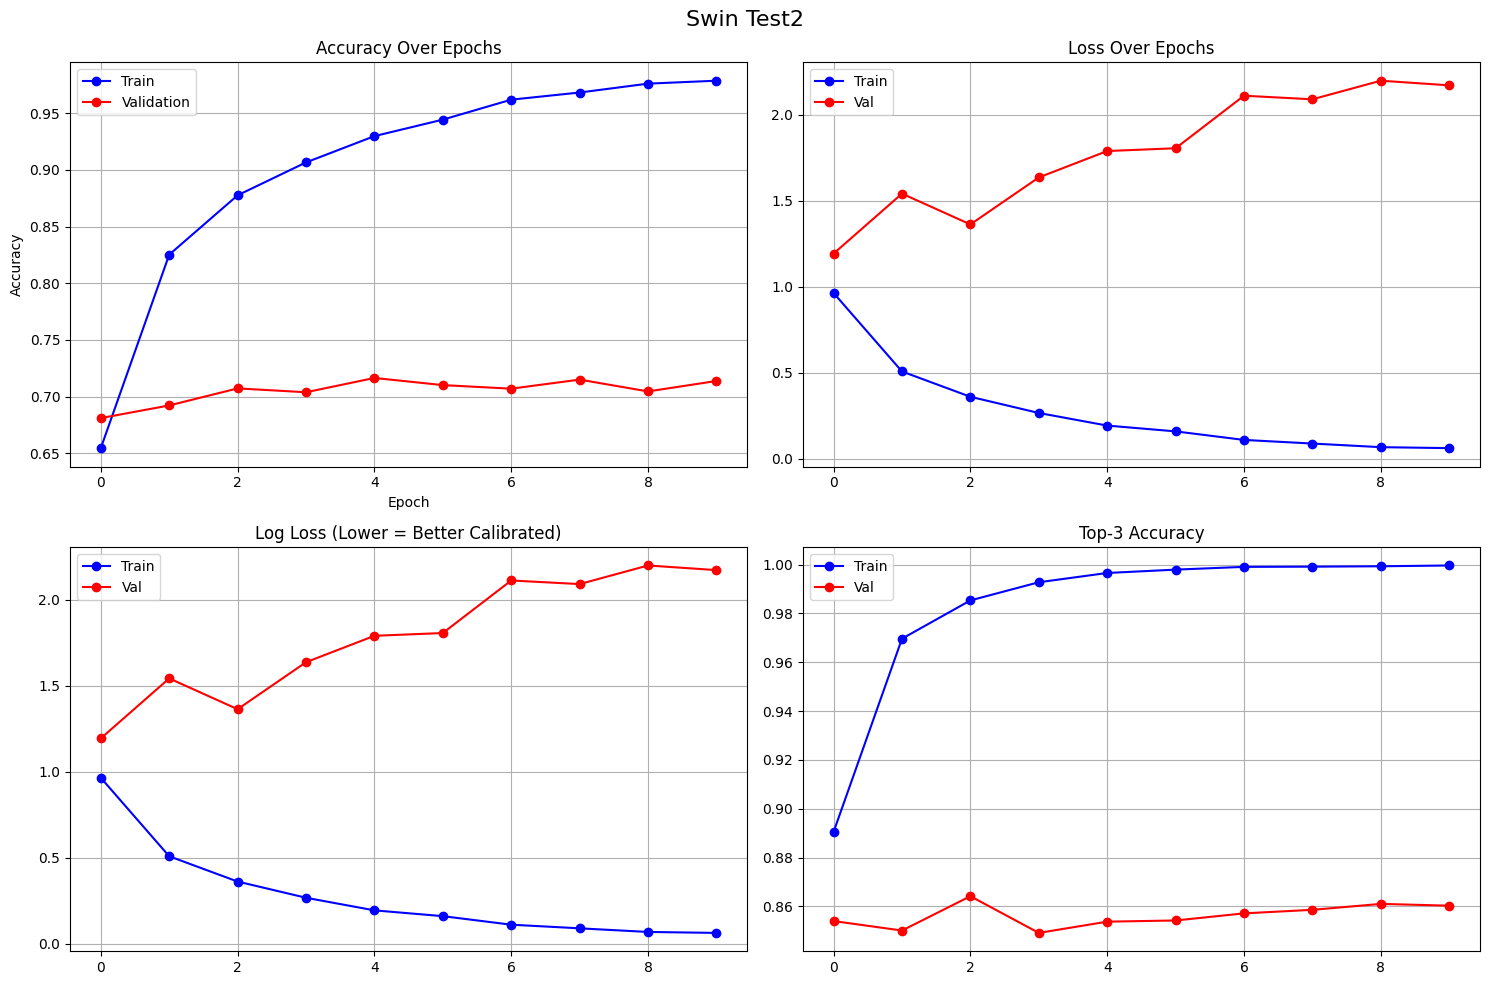

In [56]:
plot_data_over_time(train_df_swin_test2, val_df_swin_test2, "Swin Test2")

model Swin Test3

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.7436 |     0.6786 |     0.6786 |     0.9593
     1 |   0.8919 |     0.3217 |     0.3217 |     0.9922
     2 |   0.9301 |     0.2057 |     0.2057 |     0.9964
     3 |   0.9541 |     0.1396 |     0.1396 |     0.9987
     4 |   0.9686 |     0.0959 |     0.0959 |     0.9991
     5 |   0.9780 |     0.0687 |     0.0687 |     0.9995
     6 |   0.9837 |     0.0525 |     0.0525 |     0.9997
     7 |   0.9890 |     0.0369 |     0.0369 |     0.9998
     8 |   0.9914 |     0.0293 |     0.0293 |     0.9998
     9 |   0.9926 |     0.0277 |     0.0277 |     0.9999

Val
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
--------------

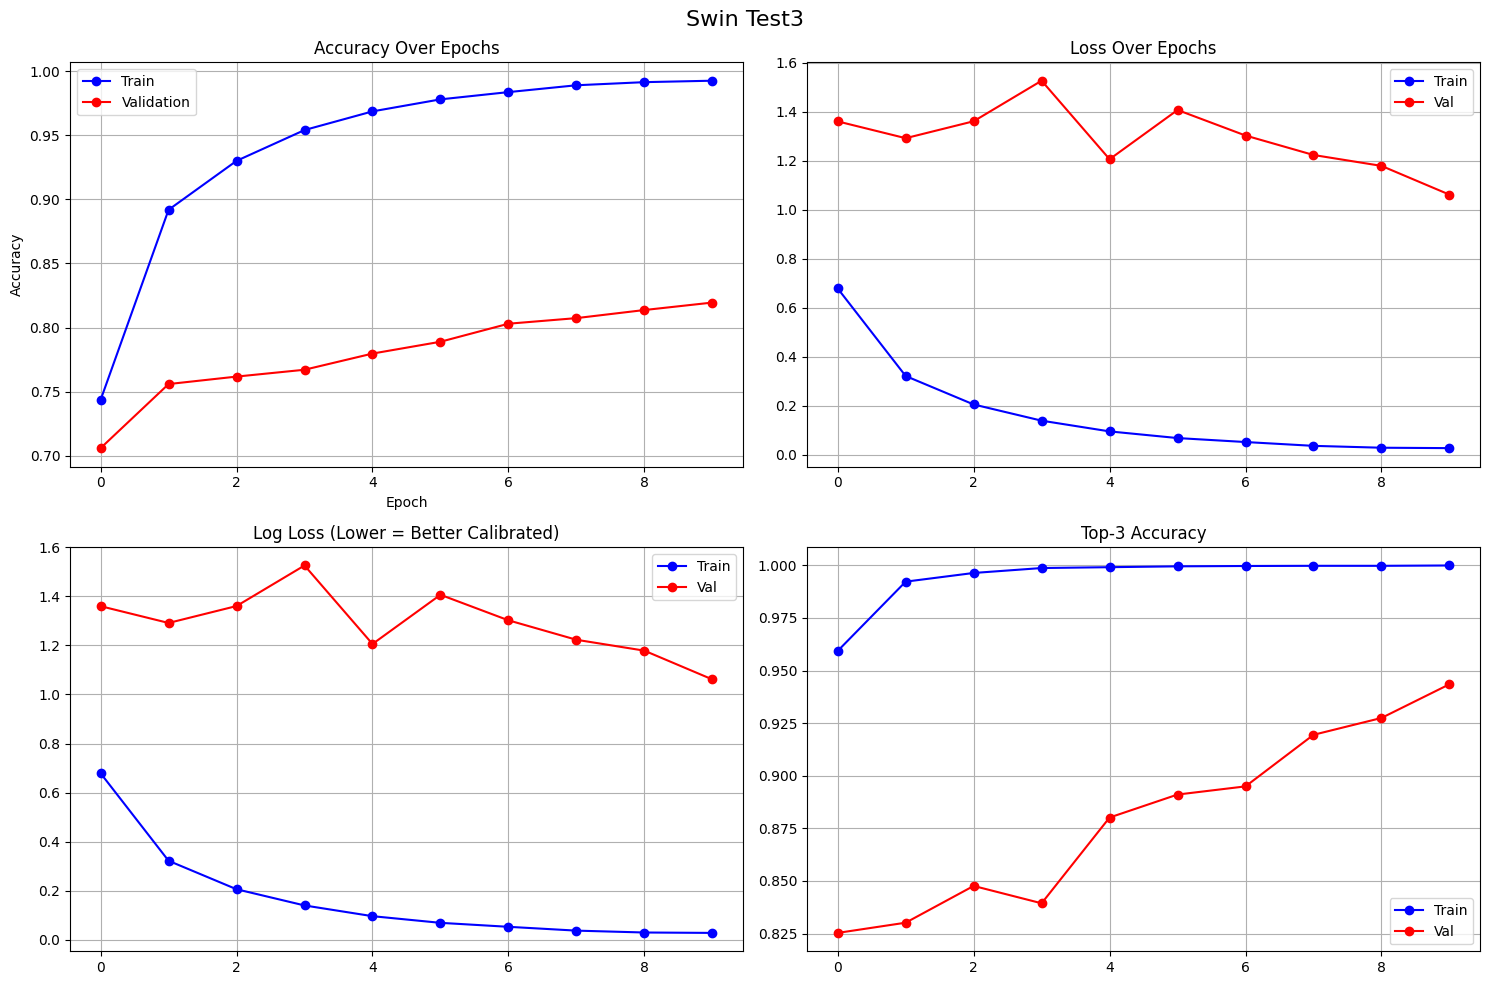

In [57]:
plot_data_over_time(train_df_swin_test3, val_df_swin_test3, "Swin Test3")

model Swin Test4

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.3471 |     1.6964 |     1.6964 |     0.6869
     1 |   0.5182 |     1.2970 |     1.2970 |     0.8410
     2 |   0.6784 |     0.9155 |     0.9155 |     0.9211
     3 |   0.7913 |     0.6382 |     0.6382 |     0.9624
     4 |   0.8422 |     0.4376 |     0.4376 |     0.9879
     5 |   0.8993 |     0.2991 |     0.2991 |     0.9927
     6 |   0.9466 |     0.2008 |     0.2008 |     0.9964
     7 |   0.9624 |     0.1378 |     0.1378 |     0.9988
     8 |   0.9782 |     0.1142 |     0.1142 |     0.9976
     9 |   0.9794 |     0.0998 |     0.0998 |     1.0000

Val
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
--------------

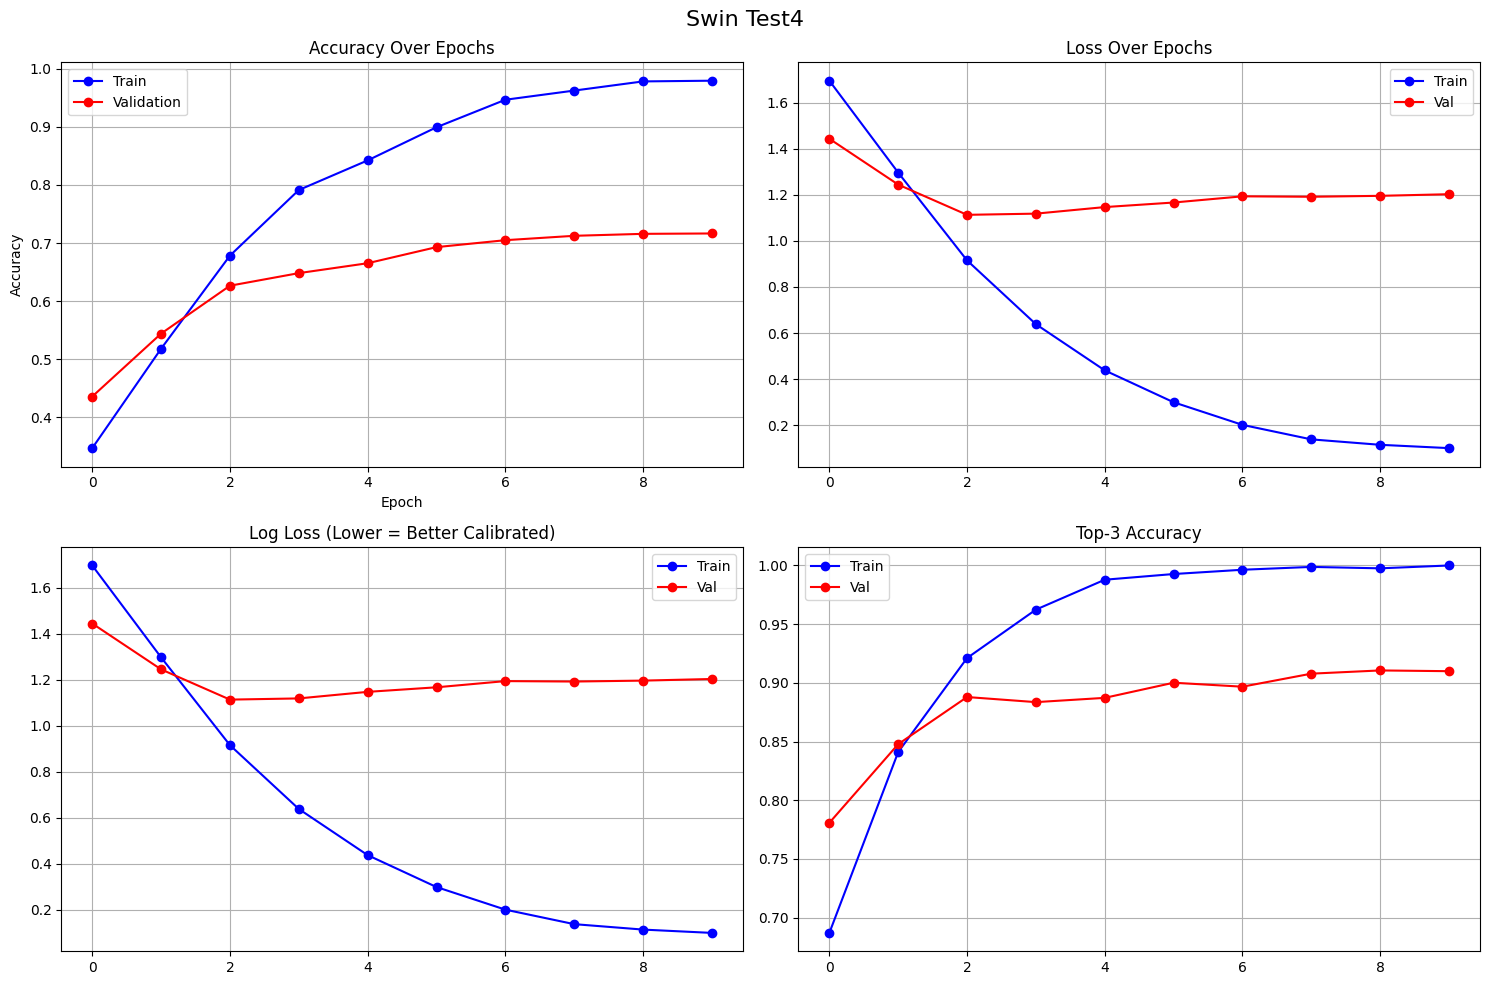

In [58]:
plot_data_over_time(train_df_swin_test4, val_df_swin_test4, "Swin Test4")

model Swin Final

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.6941 |     0.8630 |     0.8630 |     0.9078
     1 |   0.8571 |     0.4241 |     0.4241 |     0.9806
     2 |   0.9087 |     0.2802 |     0.2802 |     0.9909
     3 |   0.9352 |     0.1958 |     0.1958 |     0.9960
     4 |   0.9515 |     0.1451 |     0.1451 |     0.9978
     5 |   0.9640 |     0.1068 |     0.1068 |     0.9992
     6 |   0.9756 |     0.0732 |     0.0732 |     0.9994
     7 |   0.9843 |     0.0478 |     0.0478 |     0.9998
     8 |   0.9881 |     0.0338 |     0.0338 |     0.9998
     9 |   0.9923 |     0.0271 |     0.0271 |     0.9999
     9 |   0.9923 |     0.0271 |     0.0271 |     0.9999

Val
------------------------------------------------------------------------------------------
 Epoch |      

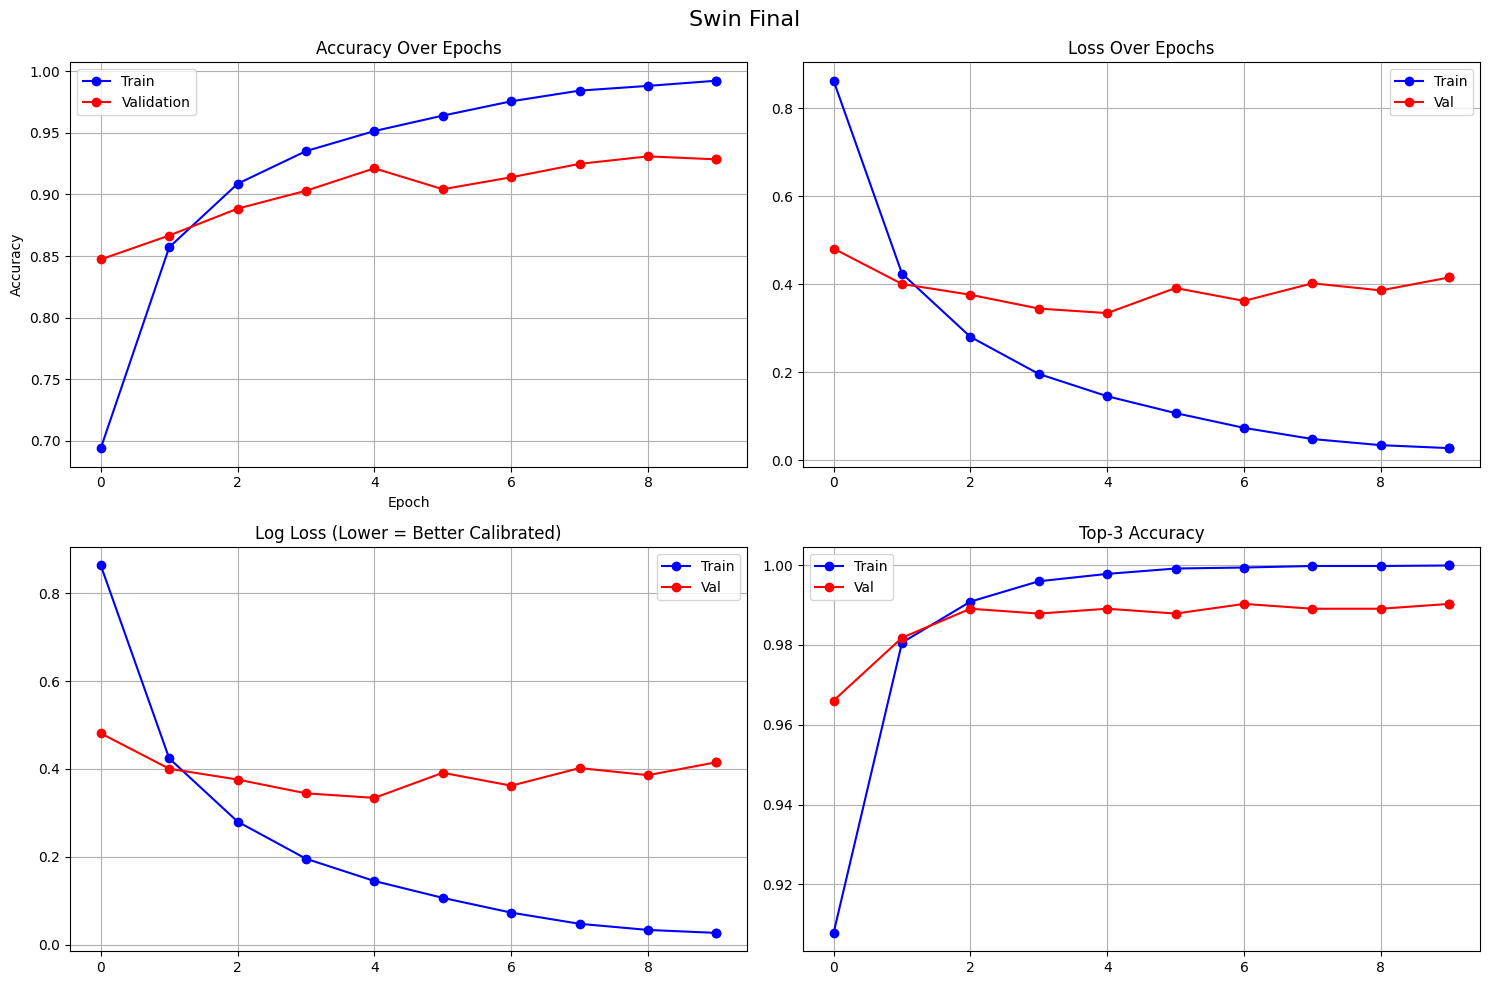

In [59]:
plot_data_over_time(train_df_convnext_final, val_df_convnext_final, "Swin Final")

model Eva

Train
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.6831 |     0.9016 |     0.9185 |     0.8845
     1 |   0.8253 |     0.4704 |     0.4850 |     0.9691
     2 |   0.8545 |     0.3875 |     0.4120 |     0.9779
     3 |   0.8893 |     0.3121 |     0.3278 |     0.9824
     4 |   0.9063 |     0.2584 |     0.2719 |     0.9888

Val
------------------------------------------------------------------------------------------
 Epoch |      Acc |       Loss |    LogLoss |  Top-3 Acc
------------------------------------------------------------------------------------------
     0 |   0.8303 |     0.4751 |     0.5132 |     0.8845
     1 |   0.8764 |     0.3187 |     0.3438 |     0.9691
     2 |   0.8885 |     0.3056 |     0.3296 |     0.9779
     3 |   0.9006 |     0.2766 |     0.3035 

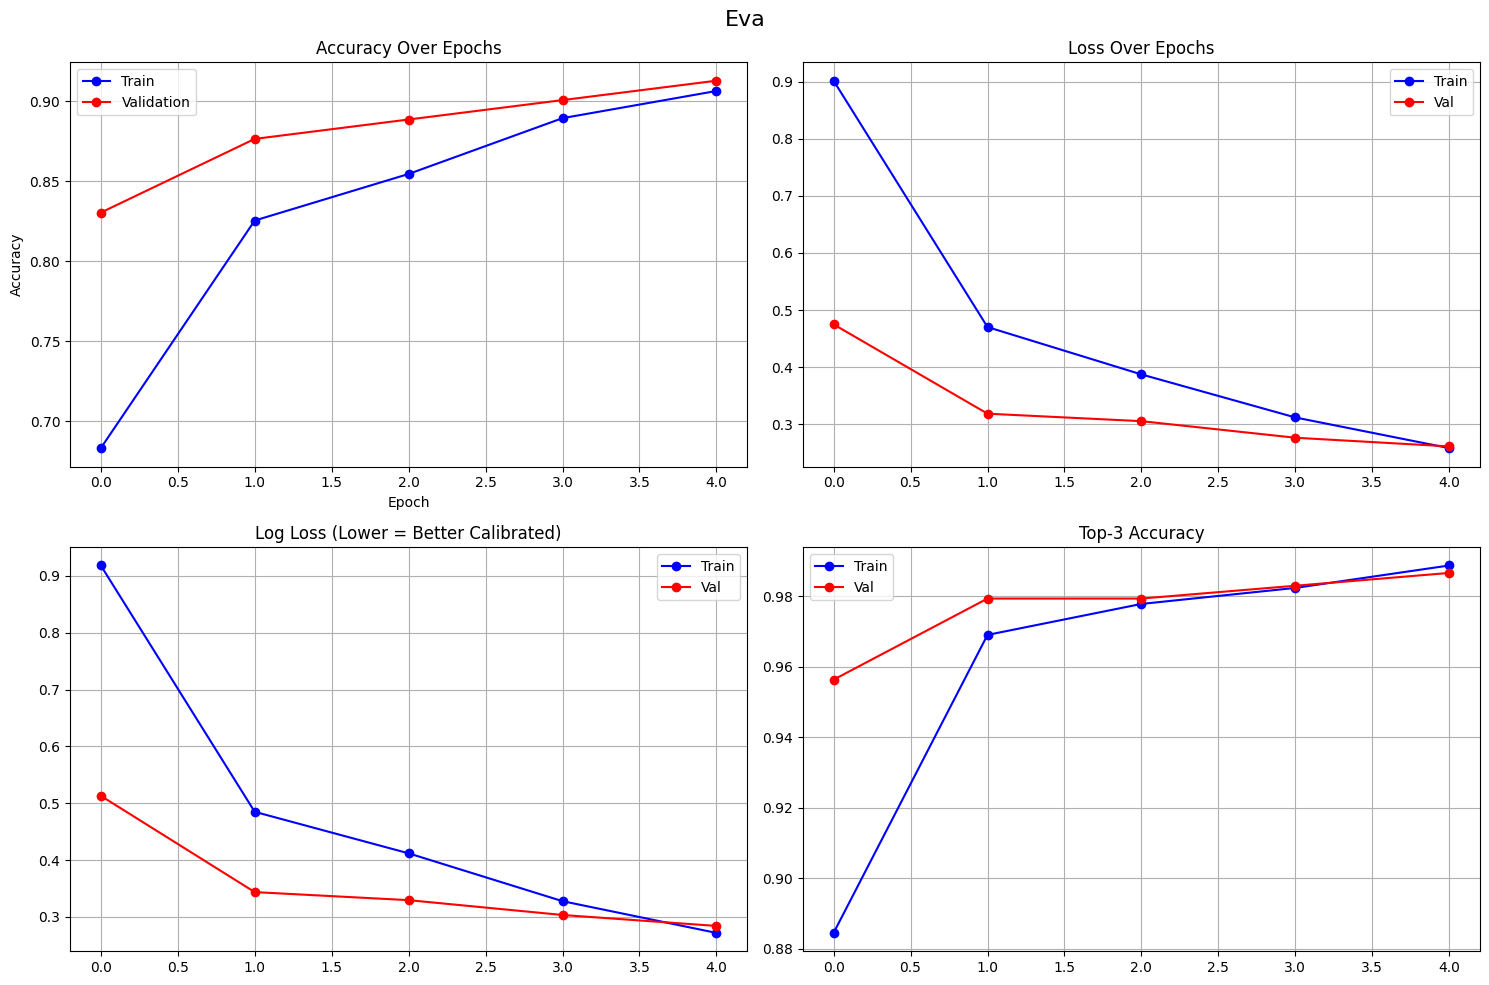

In [60]:
plot_data_over_time(train_df_eva, val_df_eva, "Eva")

metrics_dict type: <class 'dict'>


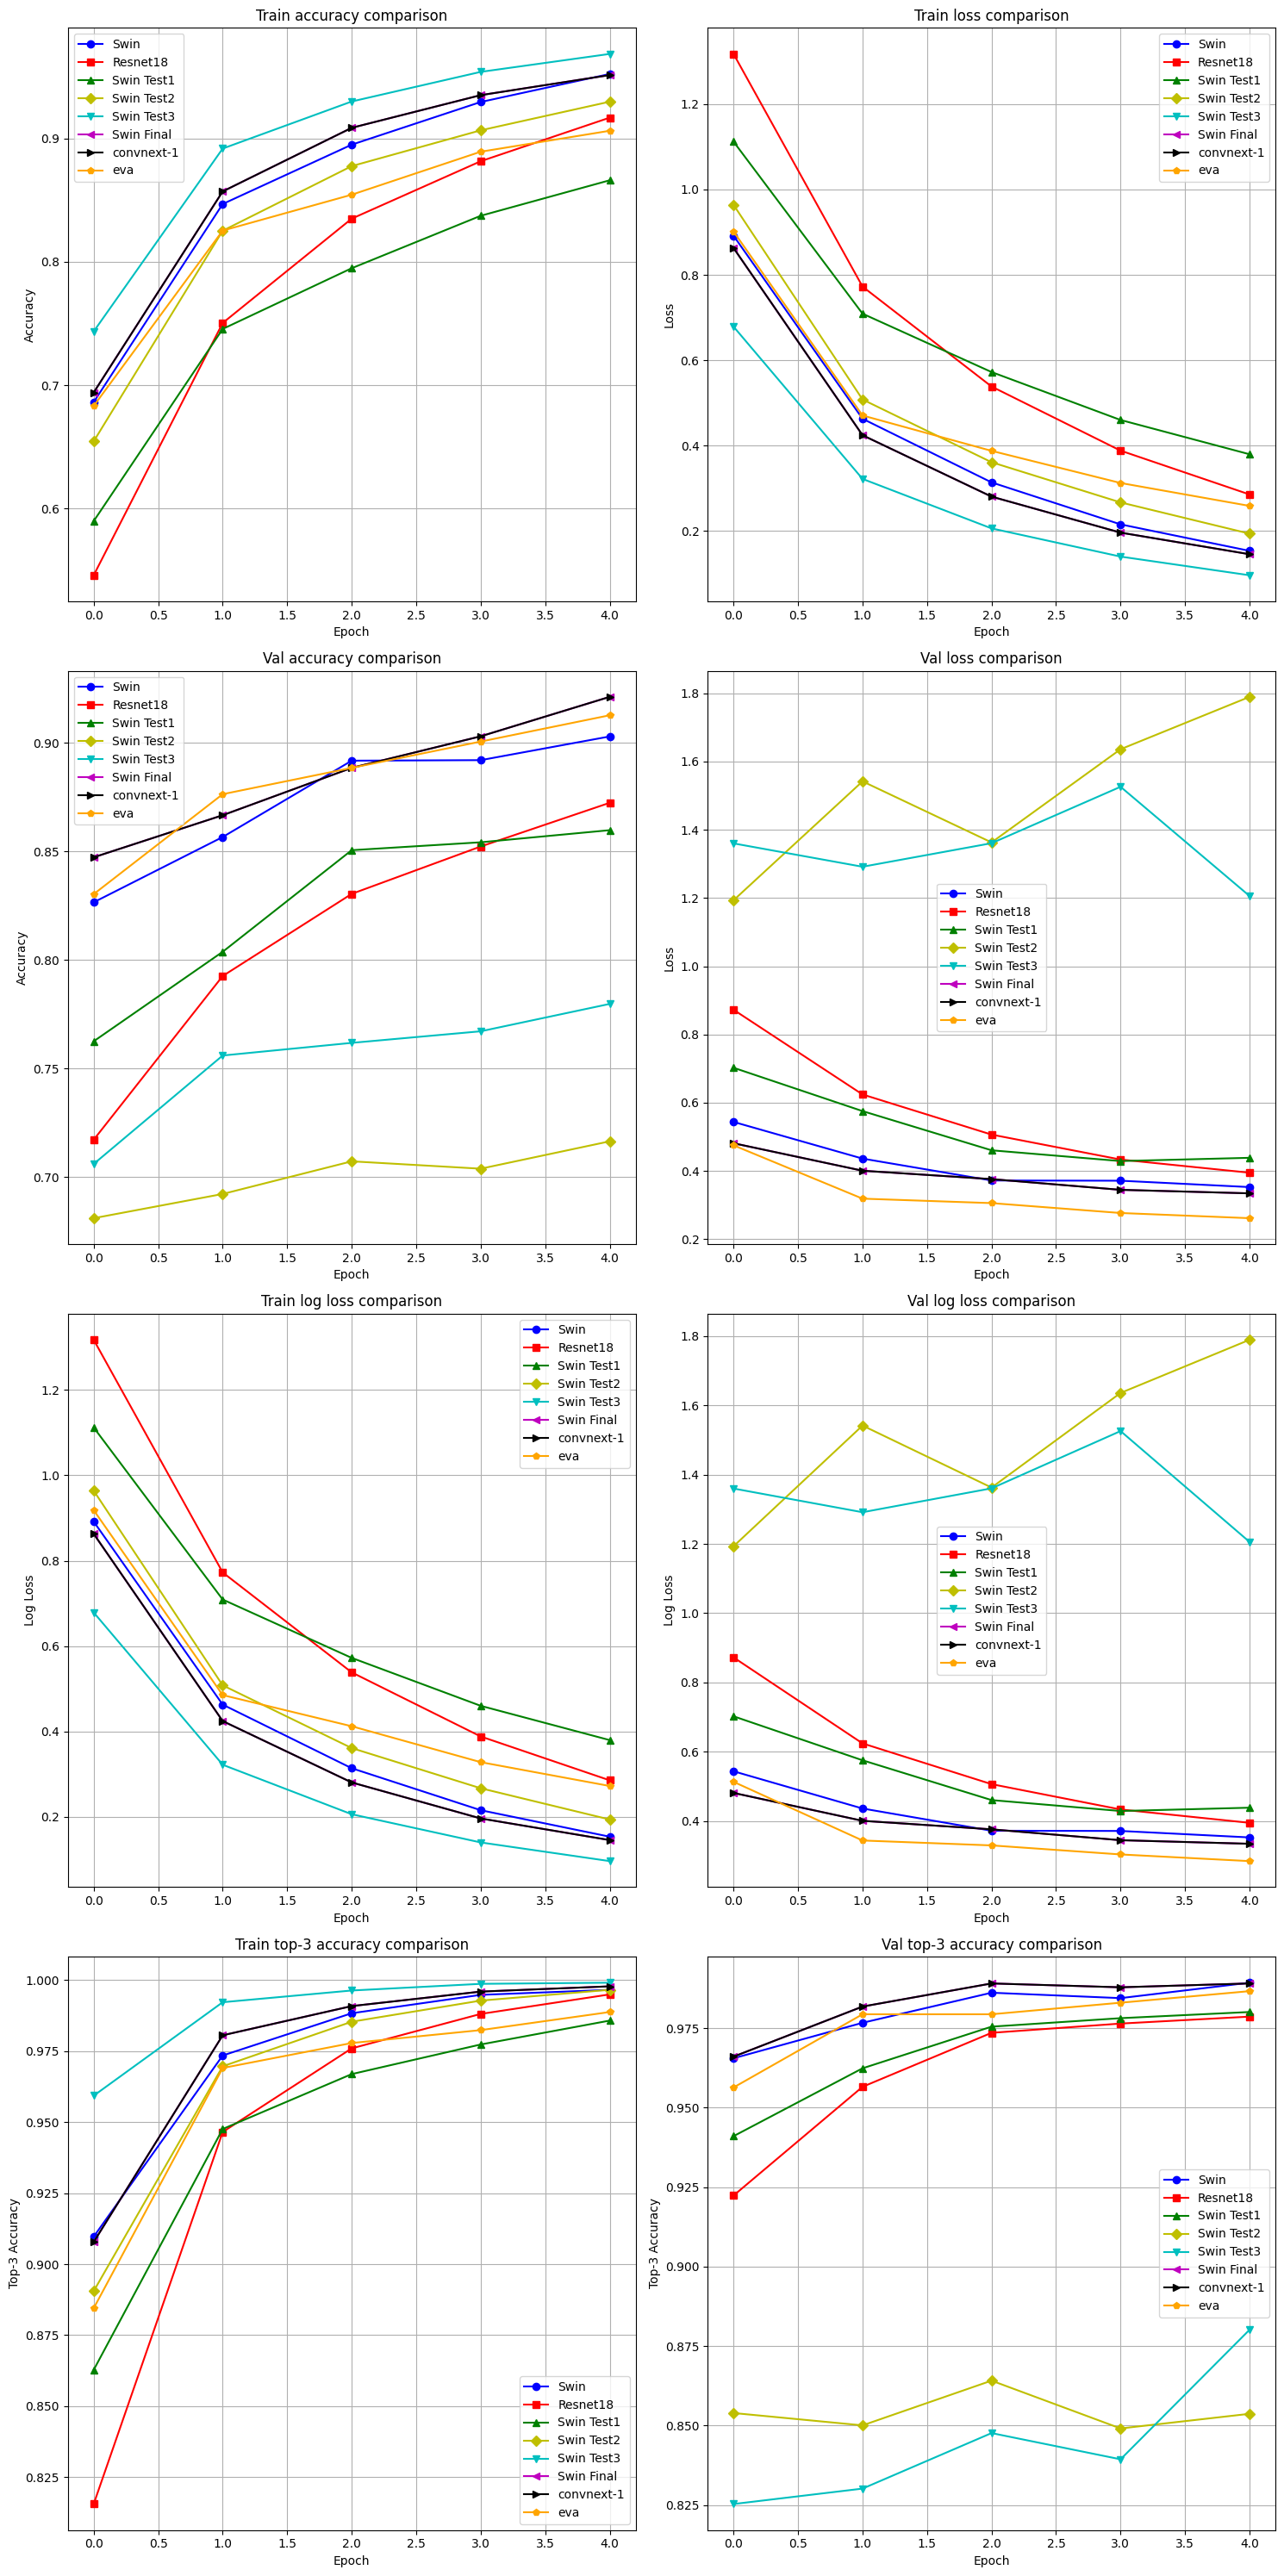

In [70]:
def plot_training_comparison(metrics_dict, figsize=(15, 30), max_epochs=None):
    """
    Plot comprehensive training metrics comparison across multiple models.

    Args:
        metrics_dict: dict of {model_name: {'train': train_df, 'val': val_df}}
                     where each df has columns: epoch, acc, loss, log_loss, top3_accuracy
        figsize: tuple, figure size (width, height)
        max_epochs: int, maximum number of epochs to display (default: None, shows all)

    Example:
        metrics = {
            'Swin': {'train': train_df_swin, 'val': val_df_swin},
            'Resnet18': {'train': train_df, 'val': val_df},
            'Swin Test1': {'train': train_df_swin_test1, 'val': val_df_swin_test1},
        }
        plot_training_comparison(metrics, max_epochs=5)
    """
    fig, axes = plt.subplots(4, 2, figsize=figsize)
    # print(f"metrics_dict: {metrics_dict}")
    print(f"metrics_dict type: {type(metrics_dict)}")
    # Define colors for each model (cycle through if more models than colors)
    colors = ["b", "r", "g", "y", "c", "m", "k", "orange", "purple", "brown"]
    markers = ["o", "s", "^", "D", "v", "<", ">", "p", "*", "h"]

    # Define metrics to plot: [(row, col, metric, ylabel, title_prefix)]
    plot_configs = [
        (0, 0, "acc", "Accuracy", "Train accuracy"),
        (0, 1, "loss", "Loss", "Train loss"),
        (1, 0, "acc", "Accuracy", "Val accuracy"),
        (1, 1, "loss", "Loss", "Val loss"),
        (2, 0, "log_loss", "Log Loss", "Train log loss"),
        (2, 1, "log_loss", "Log Loss", "Val log loss"),
        (3, 0, "top3_accuracy", "Top-3 Accuracy", "Train top-3 accuracy"),
        (3, 1, "top3_accuracy", "Top-3 Accuracy", "Val top-3 accuracy"),
    ]

    for row, col, metric, ylabel, title in plot_configs:
        ax = axes[row, col]
        split = "train" if row in [0, 2, 3] and col == 0 else "val"
        if row == 0 and col == 1:
            split = "train"

        # Determine which split (train/val) based on position
        if col == 0:
            split = "train"
        else:
            if row == 0:
                split = "train"
            else:
                split = "val"

        # Better logic: infer from title
        split = "train" if "Train" in title else "val"
        for idx, (model_name, data) in enumerate(metrics_dict.items()):
            df = data[split]

            # Limit to max_epochs if specified
            if max_epochs is not None:
                df = df[df["epoch"] < max_epochs]

            color = colors[idx % len(colors)]
            marker = markers[idx % len(markers)]

            if metric in df.columns:
                ax.plot(
                    df["epoch"],
                    df[metric],
                    f"-{marker}",
                    color=color,
                    label=f"{model_name}",
                )

        ax.set_title(f"{title} comparison")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# Call the function
metrics_comparison = {
    "Swin": {"train": train_df_swin, "val": val_df_swin},
    "Resnet18": {"train": train_df, "val": val_df},
    "Swin Test1": {"train": train_df_swin_test1, "val": val_df_swin_test1},
    "Swin Test2": {"train": train_df_swin_test2, "val": val_df_swin_test2},
    "Swin Test3": {"train": train_df_swin_test3, "val": val_df_swin_test3},
    "Swin Final": {"train": train_df_swin_final, "val": val_df_swin_final},
    "convnext-1": {"train": train_df_convnext_final, "val": val_df_convnext_final},
    "eva": {"train": train_df_eva, "val": val_df_eva},
}


plot_training_comparison(metrics_comparison, max_epochs=5)

# Easy to add/remove models:
# metrics_comparison['Swin Test3'] = {'train': train_df_swin_test3, 'val': val_df_swin_test3}
# plot_training_comparison(metrics_comparison)

In [71]:
print(class_names)

['antelope_duiker' 'bird' 'blank' 'civet_genet' 'hog' 'leopard'
 'monkey_prosimian' 'rodent']


class_precisions scores for antelope_duiker: [0.8048780487804879, 0.8916666666666667, 0.8739495798319328, 0.9032258064516129, 0.889763779527559]
class_precisions scores for bird: [0.8533333333333334, 0.868421052631579, 0.9305555555555556, 0.8641975308641975, 0.8974358974358975]
class_precisions scores for blank: [0.71875, 0.6923076923076923, 0.7692307692307693, 0.7641509433962265, 0.780952380952381]
class_precisions scores for civet_genet: [0.8620689655172413, 0.952755905511811, 0.9402985074626866, 0.9402985074626866, 0.9618320610687023]
class_precisions scores for hog: [0.676056338028169, 0.8888888888888888, 0.8888888888888888, 0.9411764705882353, 0.96]
class_precisions scores for leopard: [0.9494949494949495, 0.979381443298969, 0.9504950495049505, 0.9411764705882353, 0.9320388349514563]
class_precisions scores for monkey_prosimian: [0.898989898989899, 0.8782608695652174, 0.8666666666666667, 0.9351851851851852, 0.9298245614035088]
class_precisions scores for rodent: [0.829059829059829

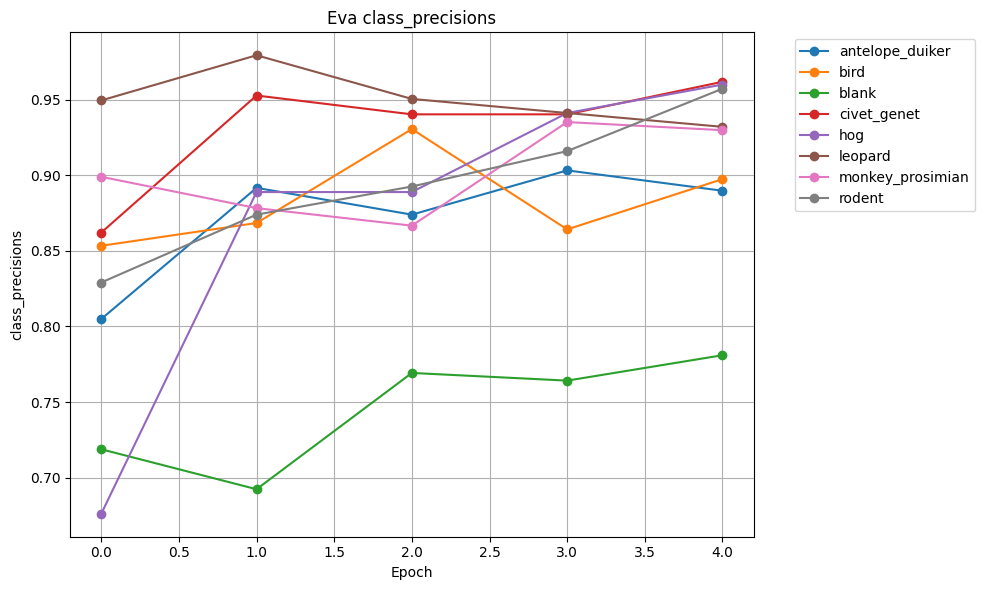

class_precisions scores for antelope_duiker: [0.5611111111111111, 0.6990654205607477, 0.682370820668693, 0.7414075286415712, 0.8045774647887324, 0.7768595041322314, 0.7818181818181819, 0.7917355371900826, 0.7819905213270142, 0.7989949748743719]
class_precisions scores for bird: [0.7897435897435897, 0.8613138686131386, 0.9203980099502488, 0.9378109452736318, 0.9302884615384616, 0.9558823529411765, 0.9354066985645934, 0.964735516372796, 0.9268867924528302, 0.9360189573459715]
class_precisions scores for blank: [0.6013513513513513, 0.6319018404907976, 0.6393762183235867, 0.6879120879120879, 0.6989898989898989, 0.6594982078853047, 0.7085953878406709, 0.6672862453531598, 0.7177242888402626, 0.725531914893617]
class_precisions scores for civet_genet: [0.8481012658227848, 0.8818897637795275, 0.890937019969278, 0.9027777777777778, 0.942215088282504, 0.9396825396825397, 0.944, 0.9440894568690096, 0.9547657512116317, 0.95]
class_precisions scores for hog: [0.8363636363636363, 0.9392523364485982,

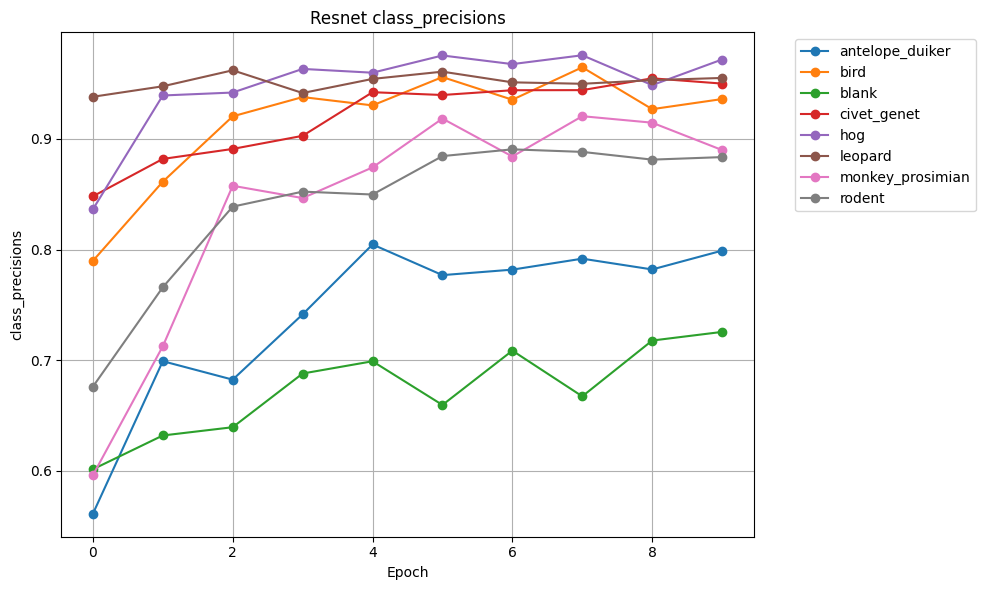

class_precisions scores for antelope_duiker: [0.869198312236287, 0.811965811965812, 0.8456375838926175, 0.8664383561643836, 0.8421900161030595, 0.8942652329749103, 0.8828522920203735, 0.8682042833607908, 0.8707037643207856, 0.8707037643207856]
class_precisions scores for bird: [0.924119241192412, 0.951530612244898, 0.9440389294403893, 0.9579207920792079, 0.9622166246851386, 0.9651741293532339, 0.9518072289156626, 0.9727047146401985, 0.9635036496350365, 0.9635922330097088]
class_precisions scores for blank: [0.6734317343173432, 0.7647058823529411, 0.7430167597765364, 0.7843137254901961, 0.7532710280373832, 0.7416520210896309, 0.7933194154488518, 0.7806324110671937, 0.8012295081967213, 0.7855750487329435]
class_precisions scores for civet_genet: [0.8366477272727273, 0.9033742331288344, 0.9470304975922953, 0.9044006069802731, 0.9733777038269551, 0.9532258064516129, 0.9475357710651828, 0.9627228525121556, 0.9579288025889967, 0.9596122778675282]
class_precisions scores for hog: [0.87109375,

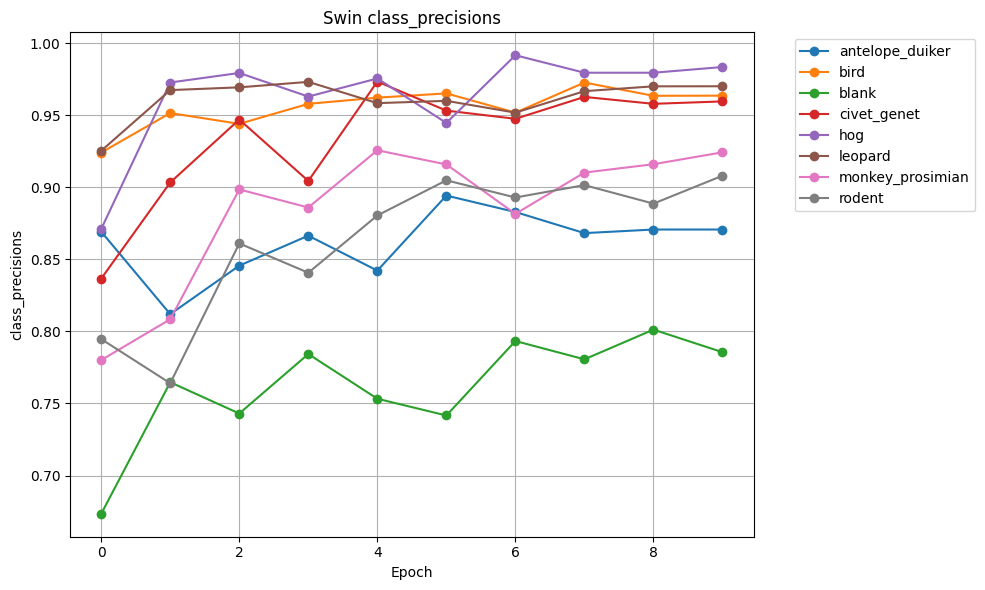

class_precisions scores for antelope_duiker: [0.7828810020876826, 0.753577106518283, 0.8351063829787234, 0.8048780487804879, 0.7590711175616836, 0.8167701863354038, 0.8621848739495799, 0.8910369068541301, 0.8601973684210527, 0.8403755868544601]
class_precisions scores for bird: [0.8378378378378378, 0.8341121495327103, 0.8857142857142857, 0.9493333333333334, 0.9673024523160763, 0.941320293398533, 0.9405940594059405, 0.9596977329974811, 0.9466019417475728, 0.9557739557739557]
class_precisions scores for blank: [0.6444906444906445, 0.7589041095890411, 0.741869918699187, 0.803030303030303, 0.7563025210084033, 0.8483290488431876, 0.803921568627451, 0.7469026548672566, 0.8142548596112311, 0.821505376344086]
class_precisions scores for civet_genet: [0.8281481481481482, 0.8133704735376045, 0.8978328173374613, 0.8838612368024132, 0.9082426127527217, 0.9182389937106918, 0.9107692307692308, 0.9384116693679092, 0.9236760124610592, 0.9393939393939394]
class_precisions scores for hog: [0.76277372262

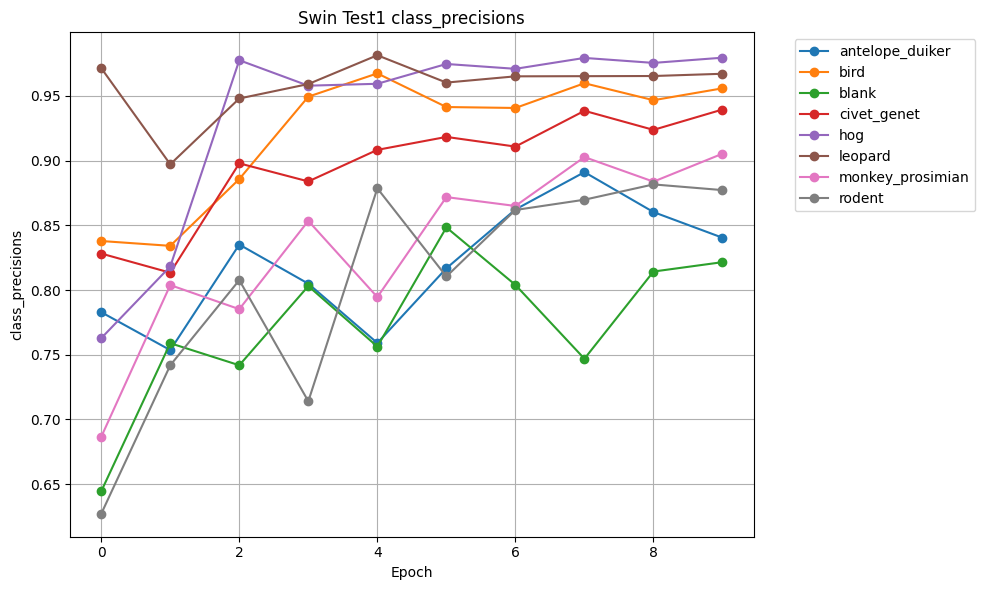

class_precisions scores for antelope_duiker: [0.6446991404011462, 0.7936842105263158, 0.7575757575757576, 0.8165680473372781, 0.6839080459770115, 0.6472081218274112, 0.6031363088057901, 0.6635262449528937, 0.6648575305291723, 0.6320400500625782]
class_precisions scores for bird: [0.7331838565022422, 0.782608695652174, 0.677007299270073, 0.8333333333333334, 0.8104738154613467, 0.896551724137931, 0.8614130434782609, 0.8816901408450705, 0.8682170542635659, 0.8638743455497382]
class_precisions scores for blank: [0.45276497695852536, 0.4766899766899767, 0.5080291970802919, 0.40684068406840684, 0.4480171489817792, 0.41872427983539096, 0.443169968717414, 0.436127744510978, 0.39912663755458516, 0.43917525773195876]
class_precisions scores for civet_genet: [0.7545076282940361, 0.6700680272108843, 0.6818181818181818, 0.784992784992785, 0.7714681440443213, 0.7698744769874477, 0.7901591895803184, 0.7824858757062146, 0.8288135593220339, 0.7928464977645305]
class_precisions scores for hog: [0.946428

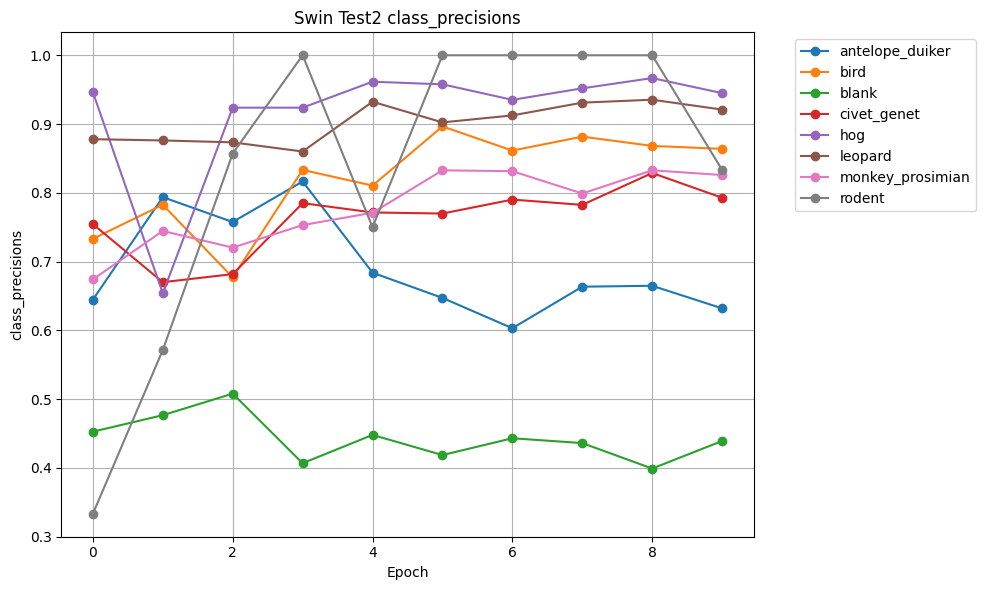

class_precisions scores for antelope_duiker: [0.6614420062695925, 0.607497243660419, 0.6367088607594936, 0.5616302186878728, 0.6064171122994653, 0.5506035283194057, 0.6631079478054567, 0.6515151515151515, 0.6358511837655016, 0.6376975169300225]
class_precisions scores for bird: [0.8737623762376238, 0.7880658436213992, 0.7567049808429118, 0.823404255319149, 0.8727678571428571, 0.8815489749430524, 0.8785871964679912, 0.891647855530474, 0.8993135011441648, 0.8977272727272727]
class_precisions scores for blank: [0.7647058823529411, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9523809523809523]
class_precisions scores for civet_genet: [0.8752136752136752, 0.9237147595356551, 0.8885542168674698, 0.905511811023622, 0.8746268656716418, 0.9026275115919629, 0.8713450292397661, 0.9001512859304085, 0.903177004538578, 0.9114503816793893]
class_precisions scores for hog: [0.7541528239202658, 0.7113095238095238, 0.7850162866449512, 0.918918918918919, 0.9372549019607843, 0.8664259927797834, 0.87003610108

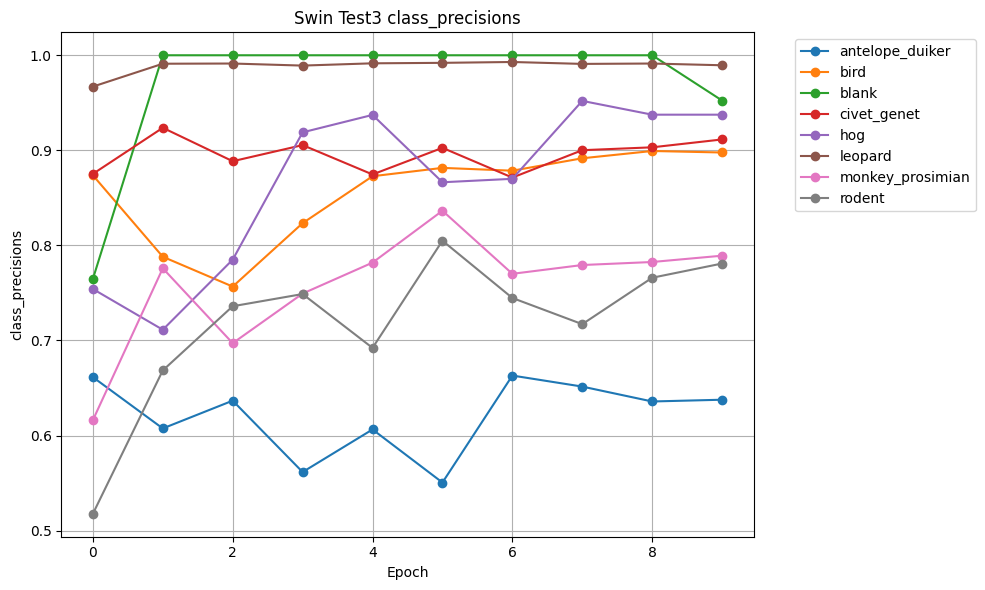

class_precisions scores for antelope_duiker: [0.3242009132420091, 0.5053827751196173, 0.4919636617749825, 0.5663753641281731, 0.6041951664386684, 0.6559139784946236, 0.685, 0.5662819167541099, 0.5929034719572682, 0.5919605612438377]
class_precisions scores for bird: [0.576271186440678, 0.3729077462047489, 0.8533950617283951, 0.6590584878744651, 0.6035940803382663, 0.5390858607432721, 0.6165146909827761, 0.6939010356731876, 0.6994758299359348, 0.7021151586368978]
class_precisions scores for blank: [0.3891625615763547, 0.5537190082644629, 0.551255940257977, 0.688622754491018, 0.6011004126547456, 0.5992063492063492, 0.6353021978021978, 0.6059880239520958, 0.6176092544987146, 0.6190476190476191]
class_precisions scores for civet_genet: [0.7313984168865435, 0.553438891637803, 0.7851641670044589, 0.7547102737291148, 0.666360012266176, 0.8221952207371406, 0.8294260307194826, 0.8003816793893129, 0.8247914183551848, 0.8150311526479751]
class_precisions scores for hog: [0.8311688311688312, 0.759

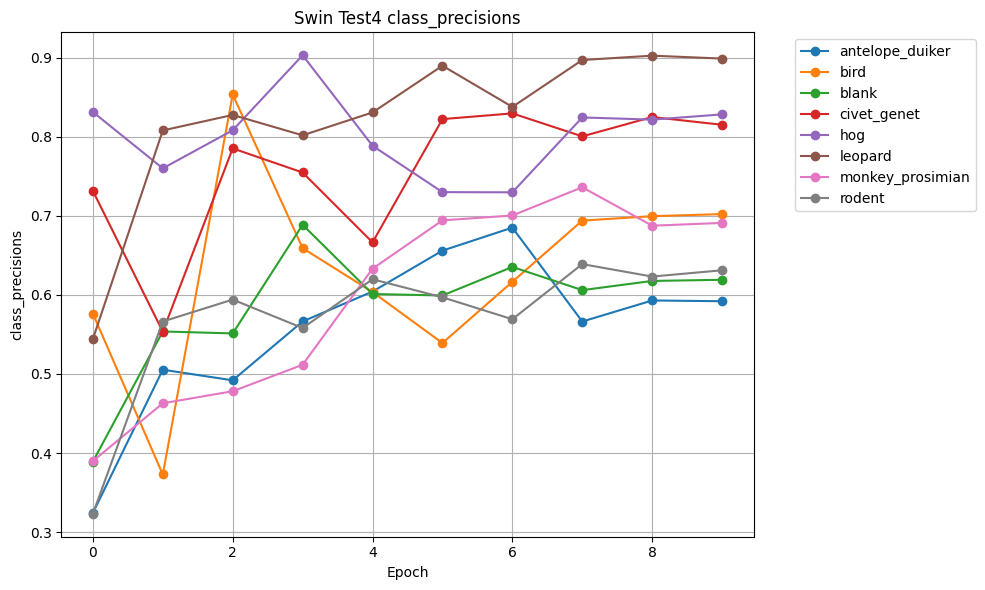

In [75]:
def plot_precision_evolution(metrics, class_names, check, titles):
    """
    Plot per-class metric evolution across epochs.

    Args:
        metrics (list): List of epoch-wise metric dictionaries
        class_names (list): Class labels to plot
        check (str): Metric key (e.g., 'precision', 'recall', 'f1')
        titles (str): Plot title
    """

    fig, ax = plt.subplots(figsize=(10, 6))

    for class_name in class_names:
        values = [epoch[check][class_name] for epoch in metrics]

        print(f"{check} scores for {class_name}: {values}")

        ax.plot(
            range(len(values)),
            values,
            marker="o",
            label=class_name,
        )

    ax.set_xlabel("Epoch")
    ax.set_ylabel(check)
    ax.set_title(titles + " " + check)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


plot_precision_evolution(val_metrics_eva, class_names, "class_precisions", titles="Eva")
plot_precision_evolution(val_metrics, class_names, "class_precisions", titles="Resnet")
plot_precision_evolution(
    val_metrics_swin, class_names, "class_precisions", titles="Swin"
)
plot_precision_evolution(
    val_metrics_swin_test1, class_names, "class_precisions", titles="Swin Test1"
)
plot_precision_evolution(
    val_metrics_swin_test2, class_names, "class_precisions", titles="Swin Test2"
)
plot_precision_evolution(
    val_metrics_swin_test3, class_names, "class_precisions", titles="Swin Test3"
)
plot_precision_evolution(
    val_metrics_swin_test4, class_names, "class_precisions", titles="Swin Test4"
)

class_recalls scores for antelope_duiker: [0.7443609022556391, 0.8045112781954887, 0.7819548872180451, 0.8421052631578947, 0.849624060150376]
class_recalls scores for bird: [0.8767123287671232, 0.9041095890410958, 0.9178082191780822, 0.958904109589041, 0.958904109589041]
class_recalls scores for blank: [0.6272727272727273, 0.7363636363636363, 0.7272727272727273, 0.7363636363636363, 0.7454545454545455]
class_recalls scores for civet_genet: [0.9765625, 0.9453125, 0.984375, 0.984375, 0.984375]
class_recalls scores for hog: [1.0, 1.0, 1.0, 1.0, 1.0]
class_recalls scores for leopard: [0.9591836734693877, 0.9693877551020408, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939]
class_recalls scores for monkey_prosimian: [0.7672413793103449, 0.8706896551724138, 0.896551724137931, 0.8706896551724138, 0.9137931034482759]
class_recalls scores for rodent: [0.8151260504201681, 0.8739495798319328, 0.907563025210084, 0.9159663865546218, 0.9411764705882353]


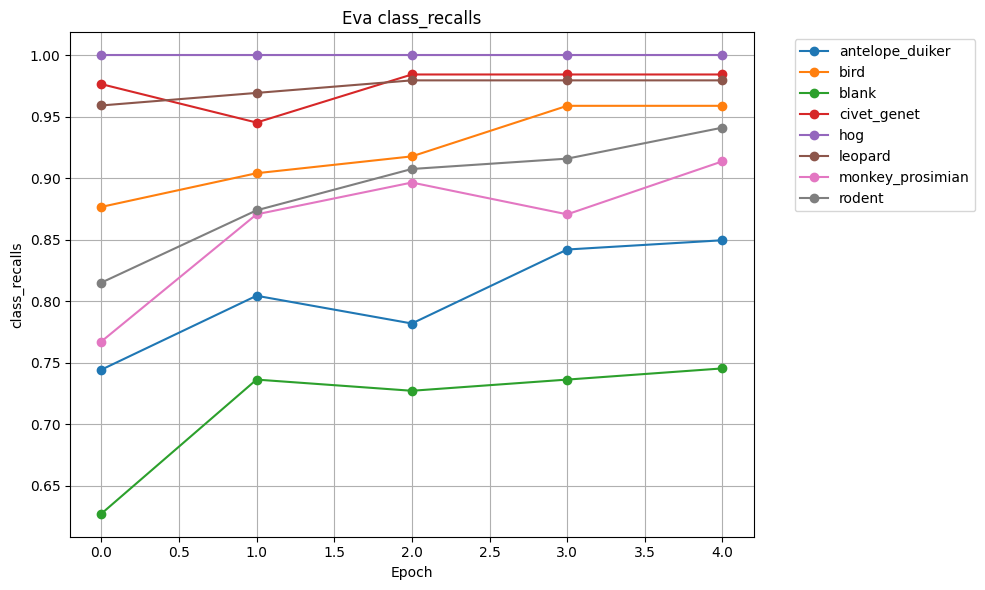

class_recalls scores for antelope_duiker: [0.4894991922455573, 0.6042003231017771, 0.7253634894991923, 0.7318255250403877, 0.7382875605815832, 0.7592891760904685, 0.7641357027463651, 0.7738287560581584, 0.7996768982229402, 0.7705977382875606]
class_recalls scores for bird: [0.751219512195122, 0.8634146341463415, 0.9024390243902439, 0.9195121951219513, 0.9439024390243902, 0.9512195121951219, 0.9536585365853658, 0.9341463414634147, 0.9585365853658536, 0.9634146341463414]
class_recalls scores for blank: [0.48282097649186256, 0.5587703435804702, 0.593128390596745, 0.566003616636528, 0.6256781193490054, 0.6654611211573237, 0.6112115732368897, 0.6491862567811935, 0.593128390596745, 0.6166365280289331]
class_recalls scores for civet_genet: [0.8844884488448845, 0.9240924092409241, 0.9570957095709571, 0.9653465346534653, 0.9686468646864687, 0.976897689768977, 0.9735973597359736, 0.9752475247524752, 0.9752475247524752, 0.971947194719472]
class_recalls scores for hog: [0.7540983606557377, 0.82377

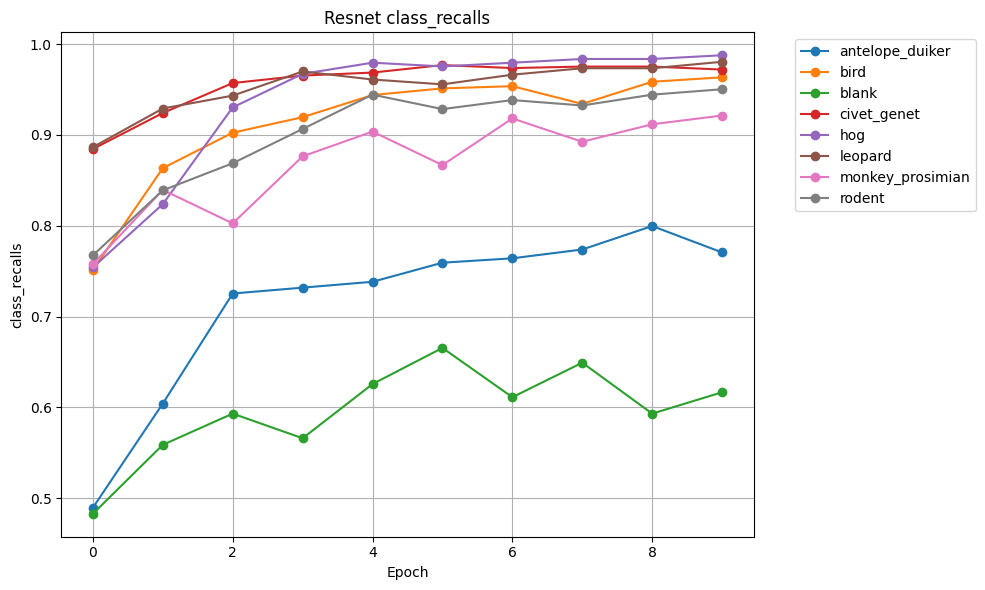

class_recalls scores for antelope_duiker: [0.6655896607431341, 0.7673667205169629, 0.81421647819063, 0.8174474959612278, 0.8449111470113085, 0.8061389337641357, 0.840064620355412, 0.851373182552504, 0.8594507269789984, 0.8594507269789984]
class_recalls scores for bird: [0.8317073170731707, 0.9097560975609756, 0.9463414634146341, 0.9439024390243902, 0.9317073170731708, 0.9463414634146341, 0.9634146341463414, 0.9560975609756097, 0.9658536585365853, 0.9682926829268292]
class_recalls scores for blank: [0.6600361663652803, 0.5877034358047016, 0.7215189873417721, 0.650994575045208, 0.72875226039783, 0.7631103074141049, 0.6871609403254972, 0.7142857142857143, 0.7070524412296564, 0.72875226039783]
class_recalls scores for civet_genet: [0.971947194719472, 0.971947194719472, 0.9735973597359736, 0.9834983498349835, 0.9653465346534653, 0.9752475247524752, 0.9834983498349835, 0.9801980198019802, 0.976897689768977, 0.9801980198019802]
class_recalls scores for hog: [0.9139344262295082, 0.877049180327

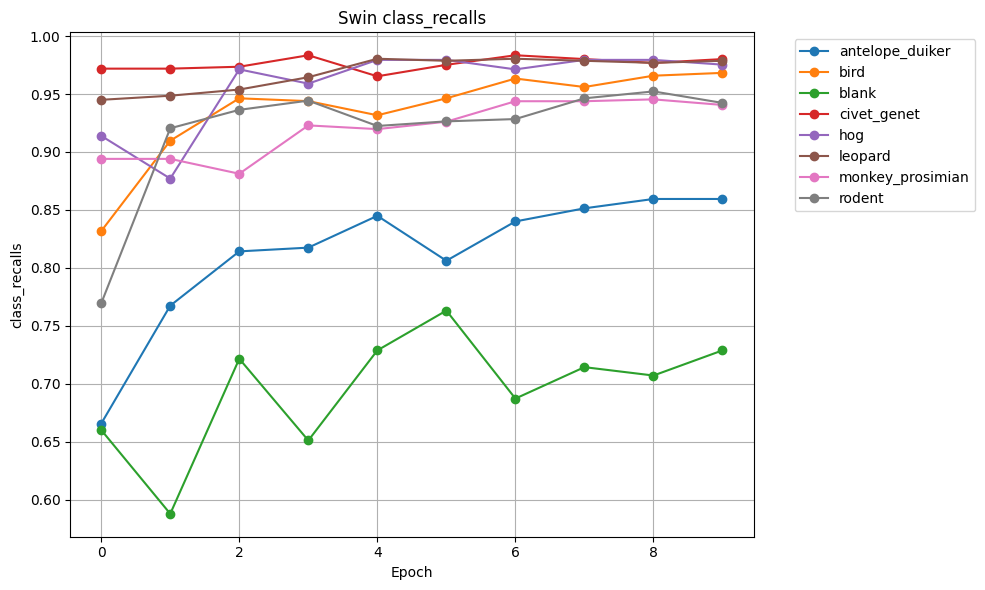

class_recalls scores for antelope_duiker: [0.6058158319870759, 0.7657512116316639, 0.7609046849757674, 0.7996768982229402, 0.8449111470113085, 0.8497576736672051, 0.8287560581583199, 0.8190630048465266, 0.8449111470113085, 0.8675282714054927]
class_recalls scores for bird: [0.7560975609756098, 0.8707317073170732, 0.9073170731707317, 0.8682926829268293, 0.8658536585365854, 0.9390243902439024, 0.926829268292683, 0.9292682926829269, 0.9512195121951219, 0.948780487804878]
class_recalls scores for blank: [0.5605786618444847, 0.5009041591320073, 0.6600361663652803, 0.5750452079566004, 0.650994575045208, 0.596745027124774, 0.6672694394213382, 0.7631103074141049, 0.6817359855334539, 0.6907775768535263]
class_recalls scores for civet_genet: [0.9224422442244224, 0.9636963696369637, 0.9570957095709571, 0.966996699669967, 0.9636963696369637, 0.9636963696369637, 0.976897689768977, 0.9554455445544554, 0.9785478547854786, 0.971947194719472]
class_recalls scores for hog: [0.8565573770491803, 0.9221311

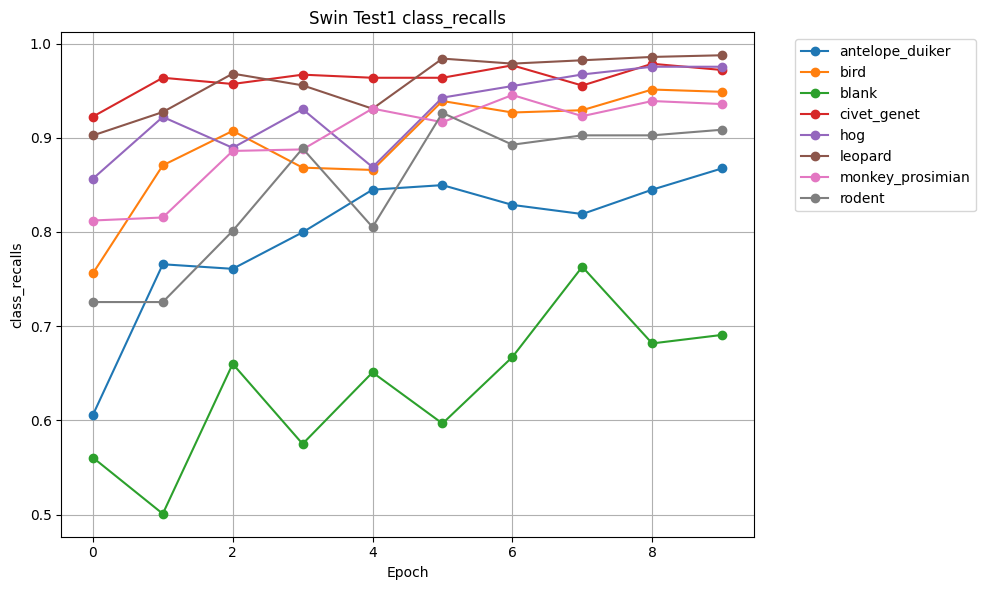

class_recalls scores for antelope_duiker: [0.7269789983844911, 0.6090468497576736, 0.6865912762520194, 0.6688206785137318, 0.7689822294022617, 0.8239095315024233, 0.8077544426494345, 0.7964458804523424, 0.7915993537964459, 0.815831987075929]
class_recalls scores for bird: [0.7975609756097561, 0.7902439024390244, 0.9048780487804878, 0.8292682926829268, 0.7926829268292683, 0.7609756097560976, 0.7731707317073171, 0.7634146341463415, 0.8195121951219512, 0.8048780487804879]
class_recalls scores for blank: [0.7106690777576854, 0.7396021699819169, 0.6292947558770343, 0.8173598553345389, 0.755877034358047, 0.7359855334538878, 0.7685352622061483, 0.7902350813743219, 0.8264014466546112, 0.7703435804701627]
class_recalls scores for civet_genet: [0.8976897689768977, 0.9752475247524752, 0.9653465346534653, 0.8976897689768977, 0.9191419141914191, 0.9108910891089109, 0.900990099009901, 0.9141914191419142, 0.806930693069307, 0.8778877887788779]
class_recalls scores for hog: [0.6516393442622951, 0.9057

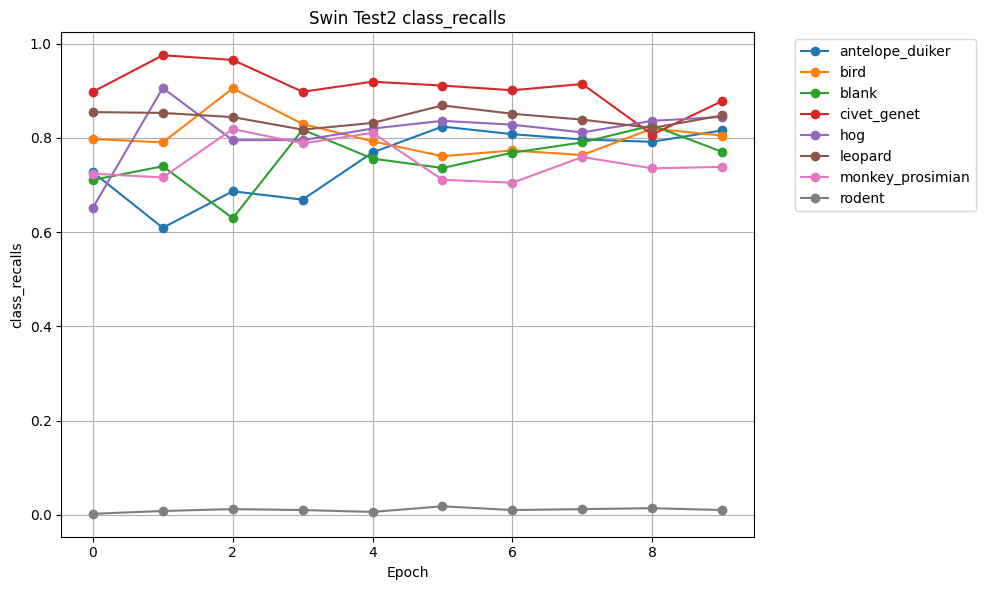

class_recalls scores for antelope_duiker: [0.6817447495961227, 0.8901453957996769, 0.8126009693053312, 0.9127625201938611, 0.9159935379644588, 0.9579967689822294, 0.9030694668820679, 0.9030694668820679, 0.9111470113085622, 0.9127625201938611]
class_recalls scores for bird: [0.8609756097560975, 0.9341463414634147, 0.9634146341463414, 0.9439024390243902, 0.9536585365853658, 0.9439024390243902, 0.9707317073170731, 0.9634146341463414, 0.9585365853658536, 0.9634146341463414]
class_recalls scores for blank: [0.023508137432188065, 0.0162748643761302, 0.014466546112115732, 0.018083182640144666, 0.023508137432188065, 0.018083182640144666, 0.0162748643761302, 0.019891500904159132, 0.0216998191681736, 0.03616636528028933]
class_recalls scores for civet_genet: [0.8448844884488449, 0.9191419141914191, 0.9735973597359736, 0.9488448844884488, 0.966996699669967, 0.9636963696369637, 0.9834983498349835, 0.9818481848184818, 0.9851485148514851, 0.9851485148514851]
class_recalls scores for hog: [0.93032786

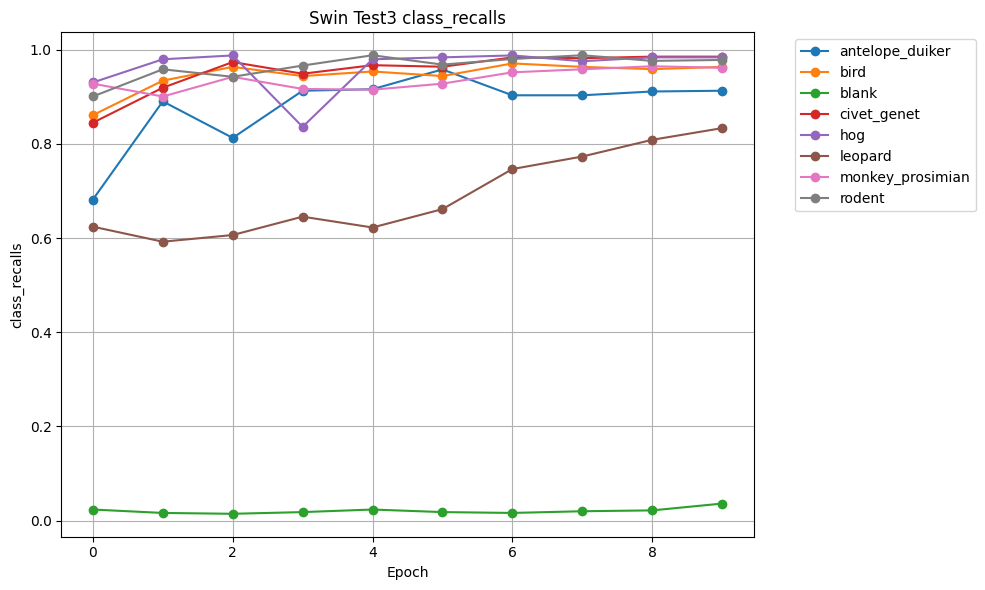

class_recalls scores for antelope_duiker: [0.3021276595744681, 0.3595744680851064, 0.5991489361702128, 0.5791489361702128, 0.5638297872340425, 0.5191489361702127, 0.5246808510638298, 0.688936170212766, 0.6612765957446809, 0.6642553191489362]
class_recalls scores for bird: [0.021808851828094934, 0.6144964720974984, 0.35471456061577933, 0.5926876202694035, 0.7325208466966003, 0.809493264913406, 0.7806286080821039, 0.7735728030788968, 0.7703656189865298, 0.7665169980756895]
class_recalls scores for blank: [0.1878269139324774, 0.15929624346172136, 0.38611507370423204, 0.2734189253447456, 0.41559676652401334, 0.43081312410841655, 0.439847836424156, 0.48121730860675227, 0.45696623870660963, 0.463623395149786]
class_recalls scores for civet_genet: [0.6020851433536055, 0.9717636837532581, 0.8414422241529105, 0.922241529105126, 0.9439617723718505, 0.8818418766290183, 0.891398783666377, 0.9109470026064292, 0.9018245004344049, 0.9092093831450913]
class_recalls scores for hog: [0.20667384284176535

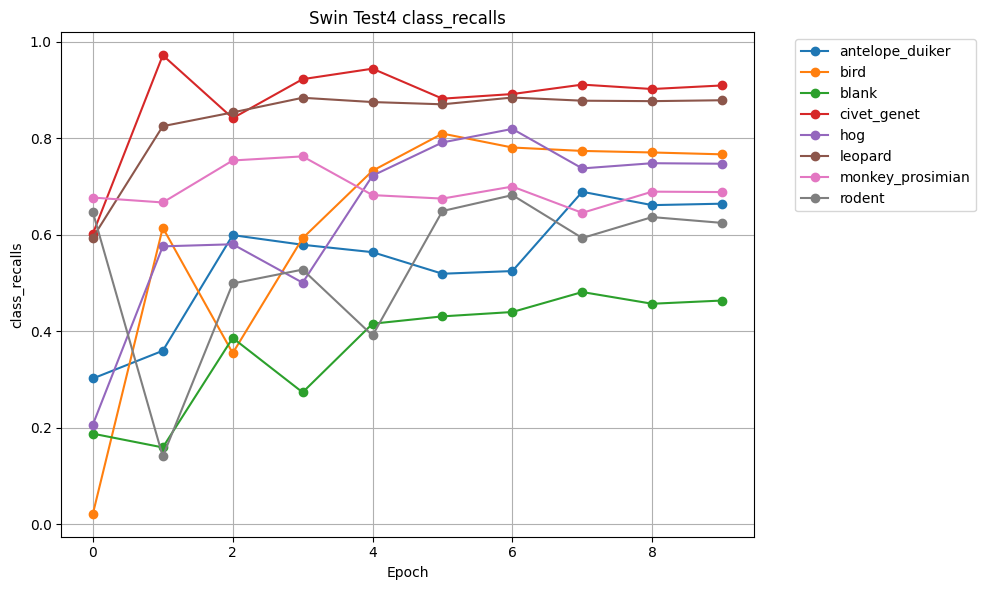

class_recalls scores for antelope_duiker: [0.7903225806451613, 0.8145161290322581, 0.8387096774193549, 0.8467741935483871, 0.8709677419354839, 0.8225806451612904, 0.8548387096774194, 0.8870967741935484, 0.8870967741935484, 0.8870967741935484]
class_recalls scores for bird: [0.8536585365853658, 0.8902439024390244, 0.9390243902439024, 0.9024390243902439, 0.9512195121951219, 0.926829268292683, 0.9634146341463414, 0.9390243902439024, 0.9512195121951219, 0.9634146341463414]
class_recalls scores for blank: [0.6756756756756757, 0.6666666666666666, 0.6936936936936937, 0.6846846846846847, 0.7297297297297297, 0.7387387387387387, 0.7387387387387387, 0.7297297297297297, 0.7657657657657657, 0.7207207207207207]
class_recalls scores for civet_genet: [0.9338842975206612, 0.9669421487603306, 0.9504132231404959, 0.9586776859504132, 0.9752066115702479, 0.9669421487603306, 0.9504132231404959, 0.9834710743801653, 0.9752066115702479, 0.9834710743801653]
class_recalls scores for hog: [0.9591836734693877, 0.9

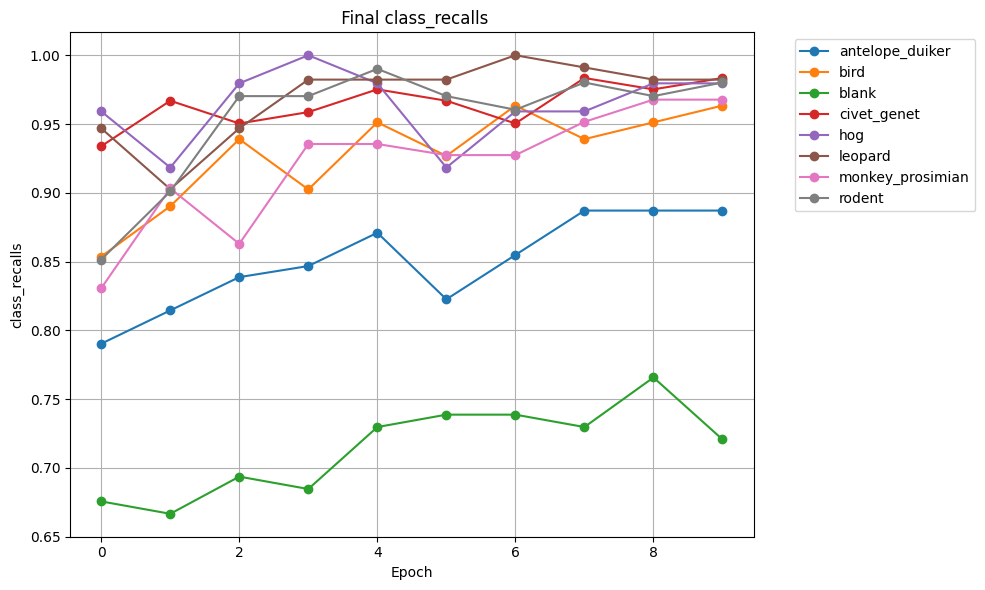

In [76]:
plot_precision_evolution(val_metrics_eva, class_names, "class_recalls", titles="Eva")
plot_precision_evolution(val_metrics, class_names, "class_recalls", titles="Resnet")
plot_precision_evolution(val_metrics_swin, class_names, "class_recalls", titles="Swin")
plot_precision_evolution(
    val_metrics_swin_test1, class_names, "class_recalls", titles="Swin Test1"
)
plot_precision_evolution(
    val_metrics_swin_test2, class_names, "class_recalls", titles="Swin Test2"
)
plot_precision_evolution(
    val_metrics_swin_test3, class_names, "class_recalls", titles="Swin Test3"
)
plot_precision_evolution(
    val_metrics_swin_test4, class_names, "class_recalls", titles="Swin Test4"
)
plot_precision_evolution(
    val_metrics_swin_final, class_names, "class_recalls", titles=" Final"
)

class_f1s scores for antelope_duiker: [0.7734375, 0.8458498023715415, 0.8253968253968254, 0.8715953307392996, 0.8692307692307693]
class_f1s scores for bird: [0.8648648648648649, 0.8859060402684564, 0.9241379310344827, 0.9090909090909091, 0.9271523178807947]
class_f1s scores for blank: [0.6699029126213593, 0.7136563876651982, 0.7476635514018691, 0.75, 0.7627906976744186]
class_f1s scores for civet_genet: [0.9157509157509157, 0.9490196078431372, 0.9618320610687023, 0.9618320610687023, 0.972972972972973]
class_f1s scores for hog: [0.8067226890756303, 0.9411764705882353, 0.9411764705882353, 0.9696969696969697, 0.9795918367346939]
class_f1s scores for leopard: [0.9543147208121827, 0.9743589743589743, 0.964824120603015, 0.96, 0.9552238805970149]
class_f1s scores for monkey_prosimian: [0.827906976744186, 0.8744588744588745, 0.8813559322033898, 0.9017857142857143, 0.9217391304347826]
class_f1s scores for rodent: [0.8220338983050848, 0.8739495798319328, 0.9, 0.9159663865546218, 0.94915254237288

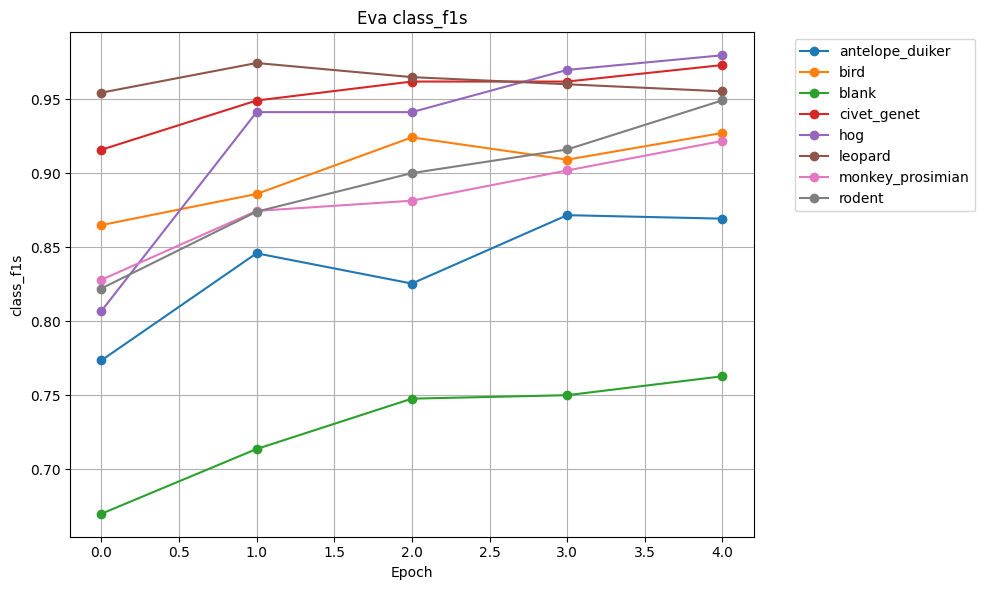

class_f1s scores for antelope_duiker: [0.5228645383951682, 0.6481802426343154, 0.7032106499608457, 0.7365853658536585, 0.7700084245998315, 0.7679738562091504, 0.7728758169934641, 0.7826797385620915, 0.7907348242811502, 0.7845394736842105]
class_f1s scores for bird: [0.77, 0.8623629719853837, 0.9113300492610837, 0.9285714285714286, 0.937046004842615, 0.9535452322738386, 0.9444444444444444, 0.9491945477075588, 0.9424460431654677, 0.9495192307692307]
class_f1s scores for blank: [0.5356068204613842, 0.5930902111324377, 0.6153846153846154, 0.621031746031746, 0.6603053435114504, 0.6624662466246625, 0.6563106796116505, 0.6581118240146654, 0.6495049504950495, 0.6666666666666666]
class_f1s scores for civet_genet: [0.8659127625201939, 0.9024979854955681, 0.9228321400159109, 0.9330143540669856, 0.9552481692432873, 0.9579288025889967, 0.958570268074736, 0.9594155844155844, 0.9648979591836735, 0.9608482871125612]
class_f1s scores for hog: [0.7931034482758621, 0.8777292576419214, 0.9360824742268041,

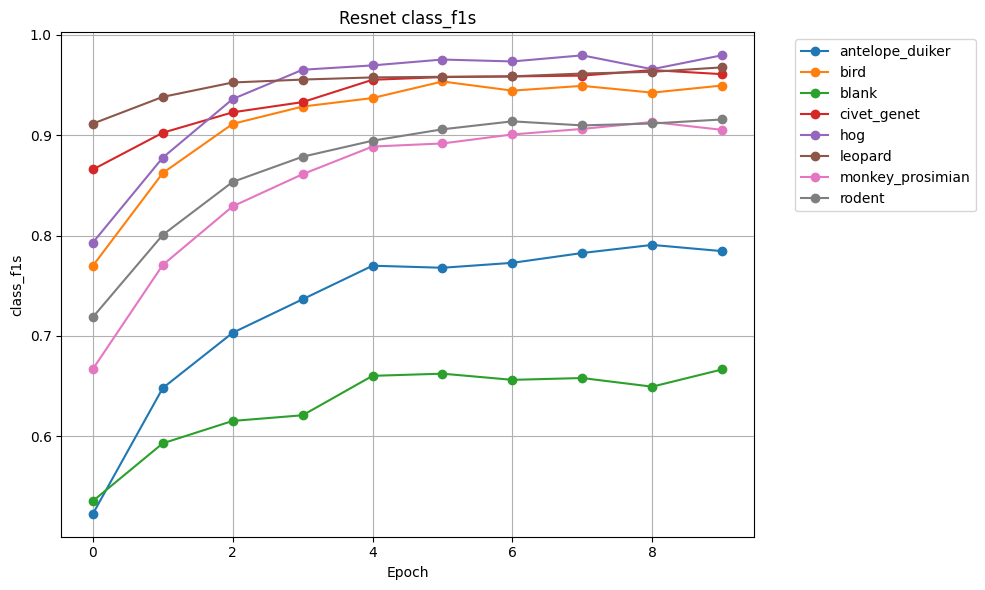

class_f1s scores for antelope_duiker: [0.7538883806038427, 0.7890365448504983, 0.8296296296296296, 0.8412302576891105, 0.8435483870967742, 0.8479184367034834, 0.8609271523178808, 0.8597063621533442, 0.865040650406504, 0.865040650406504]
class_f1s scores for bird: [0.8754813863928113, 0.9301745635910225, 0.9451887941534713, 0.9508599508599509, 0.9467162329615861, 0.9556650246305419, 0.9575757575757575, 0.964329643296433, 0.9646772228989038, 0.9659367396593674]
class_f1s scores for blank: [0.6666666666666666, 0.6646216768916156, 0.7321100917431193, 0.7114624505928854, 0.7408088235294118, 0.7522281639928698, 0.7364341085271318, 0.7459867799811143, 0.7512007684918348, 0.7560975609756098]
class_f1s scores for civet_genet: [0.899236641221374, 0.9364069952305246, 0.9601301871440195, 0.9422924901185771, 0.9693454846727423, 0.964110929853181, 0.9651821862348178, 0.9713818479149632, 0.9673202614379085, 0.9697959183673469]
class_f1s scores for hog: [0.892, 0.9224137931034483, 0.9753086419753086, 

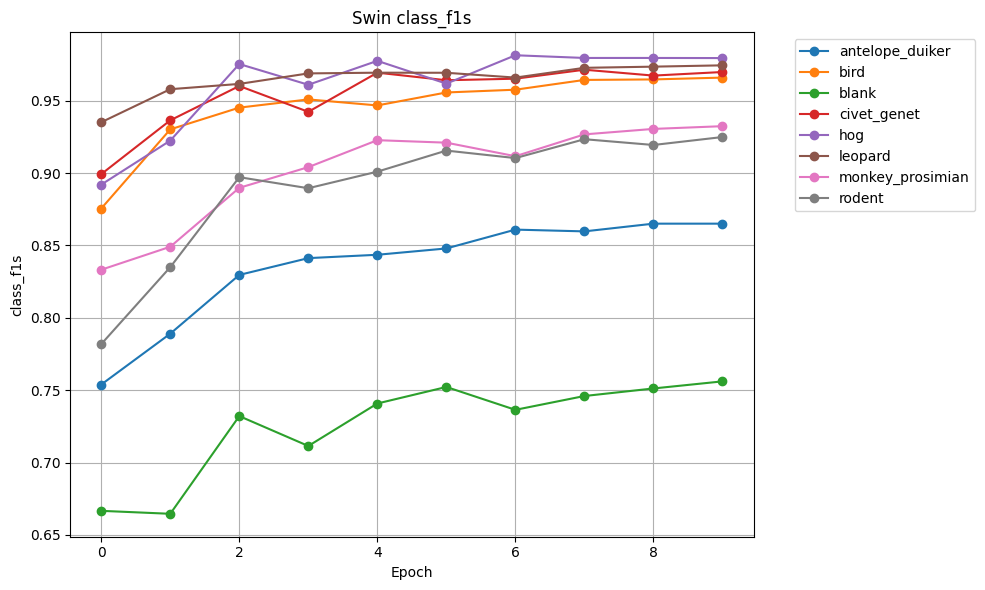

class_f1s scores for antelope_duiker: [0.6830601092896175, 0.7596153846153846, 0.7962806424344886, 0.8022690437601296, 0.7996941896024465, 0.8329374505146476, 0.8451400329489291, 0.8535353535353535, 0.8524857375713122, 0.8537360890302067]
class_f1s scores for bird: [0.7948717948717948, 0.8520286396181385, 0.8963855421686747, 0.9070063694267516, 0.9137709137709138, 0.9401709401709402, 0.9336609336609336, 0.9442379182156134, 0.948905109489051, 0.9522643818849449]
class_f1s scores for blank: [0.5996131528046421, 0.6034858387799564, 0.6985645933014354, 0.6701791359325606, 0.6997084548104956, 0.7006369426751592, 0.7292490118577075, 0.7549194991055456, 0.7421259842519685, 0.75049115913556]
class_f1s scores for civet_genet: [0.8727556596409055, 0.8821752265861027, 0.9265175718849841, 0.9235618597320725, 0.9351481184947958, 0.9404186795491143, 0.9426751592356688, 0.946852003270646, 0.9503205128205128, 0.9553933495539335]
class_f1s scores for hog: [0.806949806949807, 0.8670520231213873, 0.93133

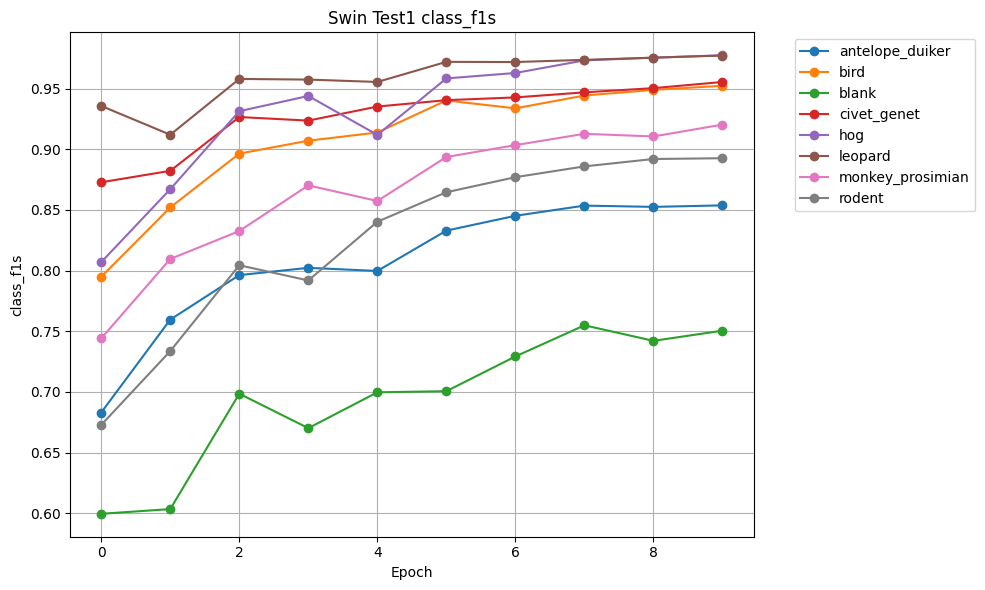

class_f1s scores for antelope_duiker: [0.683371298405467, 0.6892138939670932, 0.7203389830508474, 0.7353463587921847, 0.7239543726235741, 0.7249466950959488, 0.6906077348066298, 0.723935389133627, 0.7227138643067846, 0.7122708039492243]
class_f1s scores for bird: [0.764018691588785, 0.7864077669902912, 0.7745302713987474, 0.8312958435207825, 0.8014796547472256, 0.8232189973614775, 0.8149100257069408, 0.8183006535947712, 0.8431618569636136, 0.8333333333333334]
class_f1s scores for blank: [0.5531315974665728, 0.5797306874557052, 0.5621970920840065, 0.5432692307692307, 0.5625841184387618, 0.5337704918032787, 0.5621693121693122, 0.5620578778135048, 0.5382803297997645, 0.5594221930400525]
class_f1s scores for civet_genet: [0.8198944988696307, 0.7943548387096774, 0.7991803278688525, 0.8375673595073133, 0.838855421686747, 0.8344671201814059, 0.8419429452582884, 0.8432267884322678, 0.8177257525083612, 0.8332028191072827]
class_f1s scores for hog: [0.7718446601941747, 0.7594501718213058, 0.8546

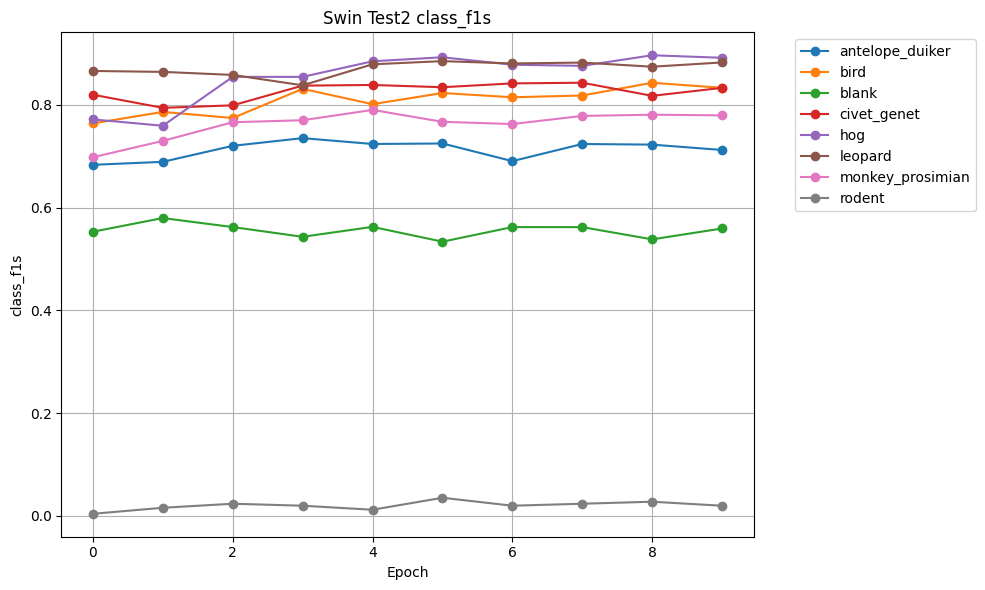

class_f1s scores for antelope_duiker: [0.6714399363564041, 0.7221494102228048, 0.7139815471965933, 0.6953846153846154, 0.7297297297297297, 0.6992924528301887, 0.7647058823529411, 0.7569397427217333, 0.749003984063745, 0.7508305647840532]
class_f1s scores for bird: [0.8673218673218673, 0.8549107142857143, 0.8476394849785408, 0.8795454545454545, 0.9114219114219114, 0.911660777385159, 0.9223638470451911, 0.9261430246189918, 0.9279811097992916, 0.9294117647058824]
class_f1s scores for blank: [0.0456140350877193, 0.03202846975088968, 0.0285204991087344, 0.035523978685612786, 0.045936395759717315, 0.035523978685612786, 0.03202846975088968, 0.03900709219858156, 0.04247787610619469, 0.06968641114982578]
class_f1s scores for civet_genet: [0.8597816960537363, 0.9214226633581473, 0.9291338582677166, 0.9266720386784851, 0.9184952978056427, 0.9321628092577813, 0.924031007751938, 0.9392265193370166, 0.9423835832675612, 0.9468675654242664]
class_f1s scores for hog: [0.8330275229357799, 0.824137931034

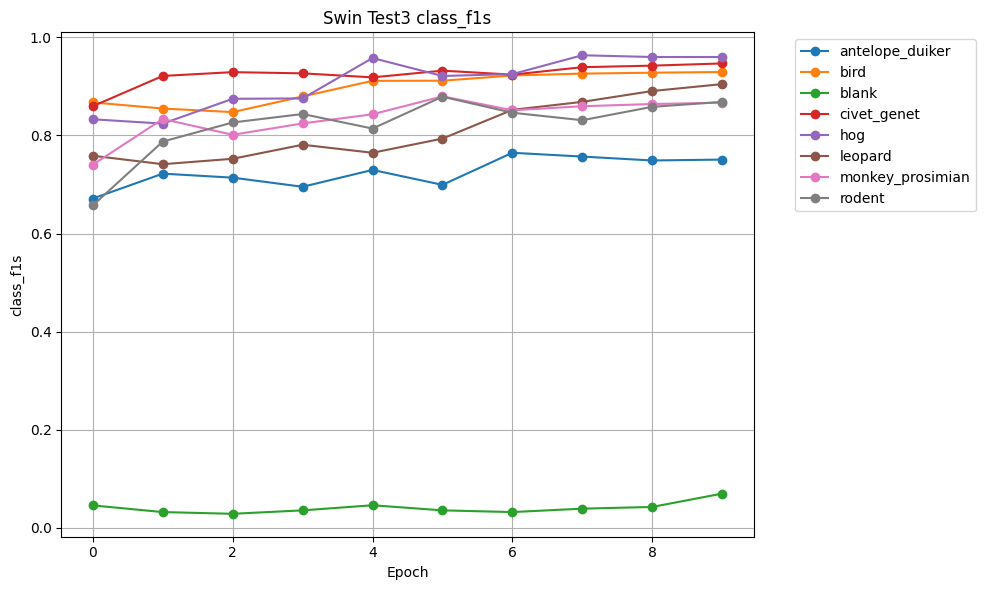

In [77]:
plot_precision_evolution(val_metrics_eva, class_names, "class_f1s", titles="Eva")

plot_precision_evolution(val_metrics, class_names, "class_f1s", titles="Resnet")

plot_precision_evolution(val_metrics_swin, class_names, "class_f1s", titles="Swin")
plot_precision_evolution(
    val_metrics_swin_test1, class_names, "class_f1s", titles="Swin Test1"
)
plot_precision_evolution(
    val_metrics_swin_test2, class_names, "class_f1s", titles="Swin Test2"
)
plot_precision_evolution(
    val_metrics_swin_test3, class_names, "class_f1s", titles="Swin Test3"
)

In [78]:
for class_name in class_names:
    print(f"class_name: {class_name}")
    f1_scores_swin = [epoch["class_f1s"][class_name] for epoch in val_metrics_swin]
    f1_scores_resnet = [epoch["class_f1s"][class_name] for epoch in val_metrics]
    f1_scores_swin_test1 = [
        epoch["class_f1s"][class_name] for epoch in val_metrics_swin_test1
    ]
    f1_scores_swin_test2 = [
        epoch["class_f1s"][class_name] for epoch in val_metrics_swin_test2
    ]

    swin = f1_scores_swin[-1]
    resnet = f1_scores_resnet[-1]
    swin_test1 = f1_scores_swin_test1[-1]
    swin_test2 = f1_scores_swin_test2[-1]

    print(f"f1_scores_swin: {f1_scores_swin[::-1]}")
    print(f"f1_scores_resnet: {f1_scores_resnet[::-1]}")
    print(f"f1_scores_swin_test1: {f1_scores_swin_test1[::-1]}")
    print(f"f1_scores_swin_test2: {f1_scores_swin_test2[::-1]}")

    name = ["resnet", "swin", "swin_test1", "swin_test2"]
    l = [resnet, swin, swin_test1, swin_test2]
    print(f"l: {l}")
    print(f"max(l): {max(l)}, index: {name[l.index(max(l))]} with {max(l)}")
    print("--------------------------------")

class_name: antelope_duiker
f1_scores_swin: [0.865040650406504, 0.865040650406504, 0.8597063621533442, 0.8609271523178808, 0.8479184367034834, 0.8435483870967742, 0.8412302576891105, 0.8296296296296296, 0.7890365448504983, 0.7538883806038427]
f1_scores_resnet: [0.7845394736842105, 0.7907348242811502, 0.7826797385620915, 0.7728758169934641, 0.7679738562091504, 0.7700084245998315, 0.7365853658536585, 0.7032106499608457, 0.6481802426343154, 0.5228645383951682]
f1_scores_swin_test1: [0.8537360890302067, 0.8524857375713122, 0.8535353535353535, 0.8451400329489291, 0.8329374505146476, 0.7996941896024465, 0.8022690437601296, 0.7962806424344886, 0.7596153846153846, 0.6830601092896175]
f1_scores_swin_test2: [0.7122708039492243, 0.7227138643067846, 0.723935389133627, 0.6906077348066298, 0.7249466950959488, 0.7239543726235741, 0.7353463587921847, 0.7203389830508474, 0.6892138939670932, 0.683371298405467]
l: [0.7845394736842105, 0.865040650406504, 0.8537360890302067, 0.7122708039492243]
max(l): 0.8

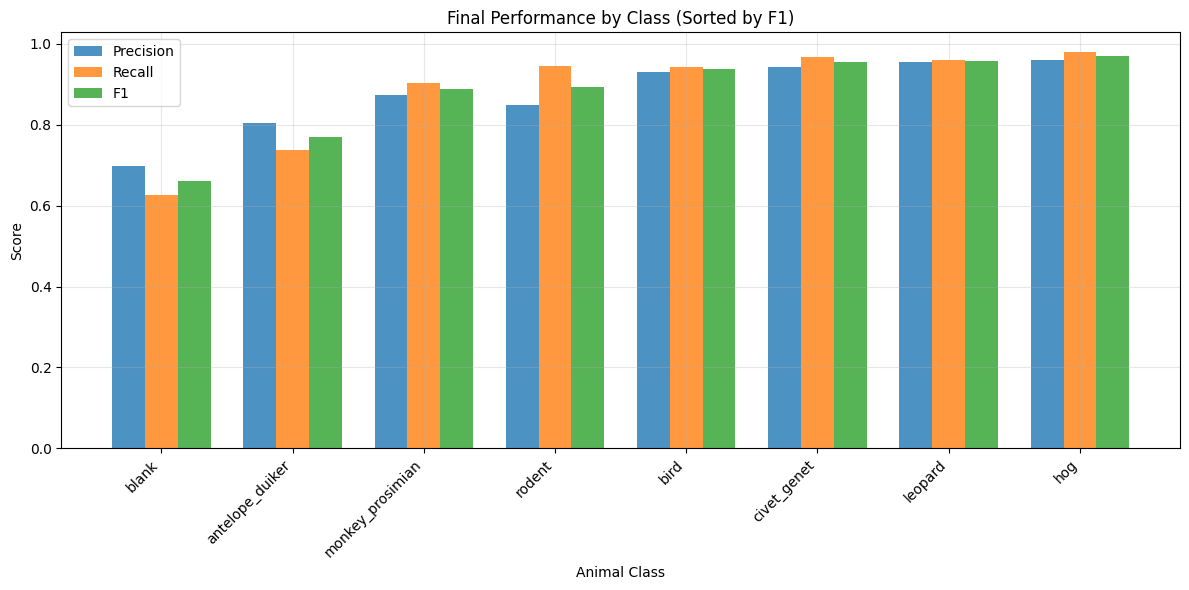


🔴 Hardest Classes (Lowest F1):
              Class        F1  Precision    Recall
2             blank  0.660305   0.698990  0.625678
0   antelope_duiker  0.770008   0.804577  0.738288
6  monkey_prosimian  0.888713   0.874224  0.903692


In [79]:
def plot_final_performance(metrics, class_names, epoch):
    final_metrics = metrics[epoch]

    class_performance = []
    for class_name in class_names:
        class_performance.append(
            {
                "Class": class_name,
                "F1": final_metrics["class_f1s"][class_name],
                "Precision": final_metrics["class_precisions"][class_name],
                "Recall": final_metrics["class_recalls"][class_name],
                "Confidence": final_metrics["class_confidences"][class_name],
                "Support": final_metrics[class_name]["support"],
            }
        )

    perf_df = pd.DataFrame(class_performance)
    perf_df = perf_df.sort_values("F1")

    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(perf_df))
    width = 0.25

    ax.bar(x - width, perf_df["Precision"], width, label="Precision", alpha=0.8)
    ax.bar(x, perf_df["Recall"], width, label="Recall", alpha=0.8)
    ax.bar(x + width, perf_df["F1"], width, label="F1", alpha=0.8)

    ax.set_xlabel("Animal Class")
    ax.set_ylabel("Score")
    ax.set_title("Final Performance by Class (Sorted by F1)")
    ax.set_xticks(x)
    ax.set_xticklabels(perf_df["Class"], rotation=45, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n🔴 Hardest Classes (Lowest F1):")
    print(perf_df[["Class", "F1", "Precision", "Recall"]].head(3))


plot_final_performance(val_metrics, class_names, 4)

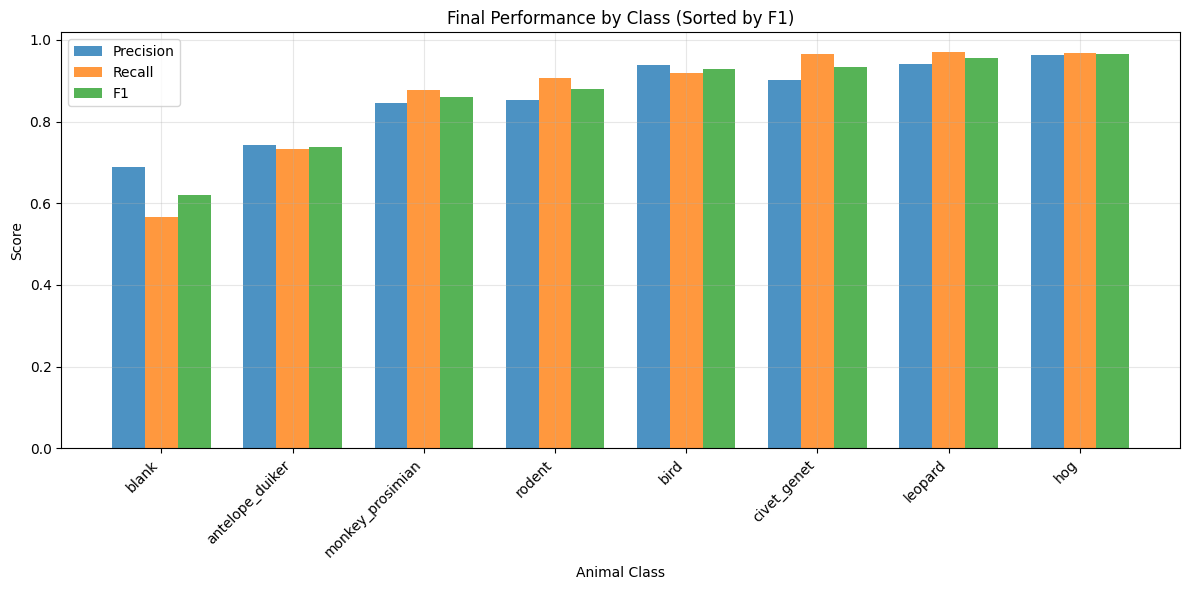


🔴 Hardest Classes (Lowest F1):
              Class        F1  Precision    Recall
2             blank  0.621032   0.687912  0.566004
0   antelope_duiker  0.736585   0.741408  0.731826
6  monkey_prosimian  0.861199   0.846512  0.876404


In [80]:
plot_final_performance(val_metrics, class_names, 3)

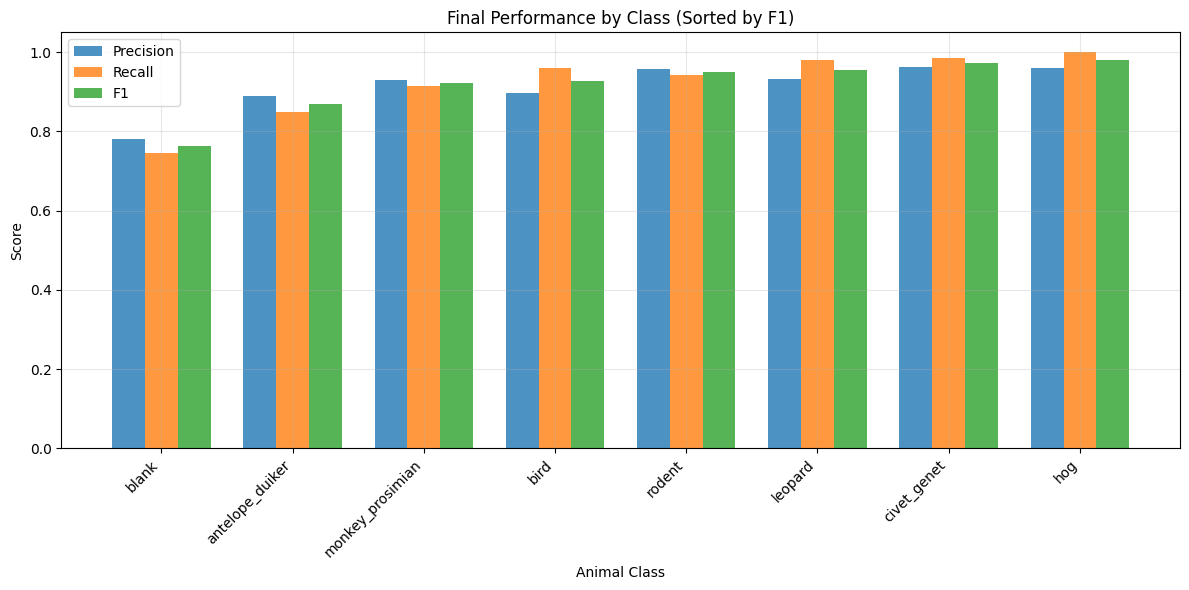


🔴 Hardest Classes (Lowest F1):
              Class        F1  Precision    Recall
2             blank  0.762791   0.780952  0.745455
0   antelope_duiker  0.869231   0.889764  0.849624
6  monkey_prosimian  0.921739   0.929825  0.913793


In [83]:
plot_final_performance(val_metrics_eva, class_names, 4)


🔴 Top 15 Misclassifications — Resnet (Epoch 4)
            True        Predicted  Count  Pct_of_True
 antelope_duiker            blank     77    12.439418
           blank  antelope_duiker     74    13.381555
           blank           rodent     49     8.860759
 antelope_duiker monkey_prosimian     37     5.977383
           blank monkey_prosimian     33     5.967450
monkey_prosimian  antelope_duiker     24     3.852327
           blank          leopard     22     3.978300
monkey_prosimian            blank     20     3.210273
          rodent            blank     17     3.379722
 antelope_duiker           rodent     16     2.584814
           blank             bird     15     2.712477
 antelope_duiker      civet_genet     14     2.261712
         leopard            blank     14     2.482270
           blank      civet_genet     14     2.531646
            bird            blank     13     3.170732


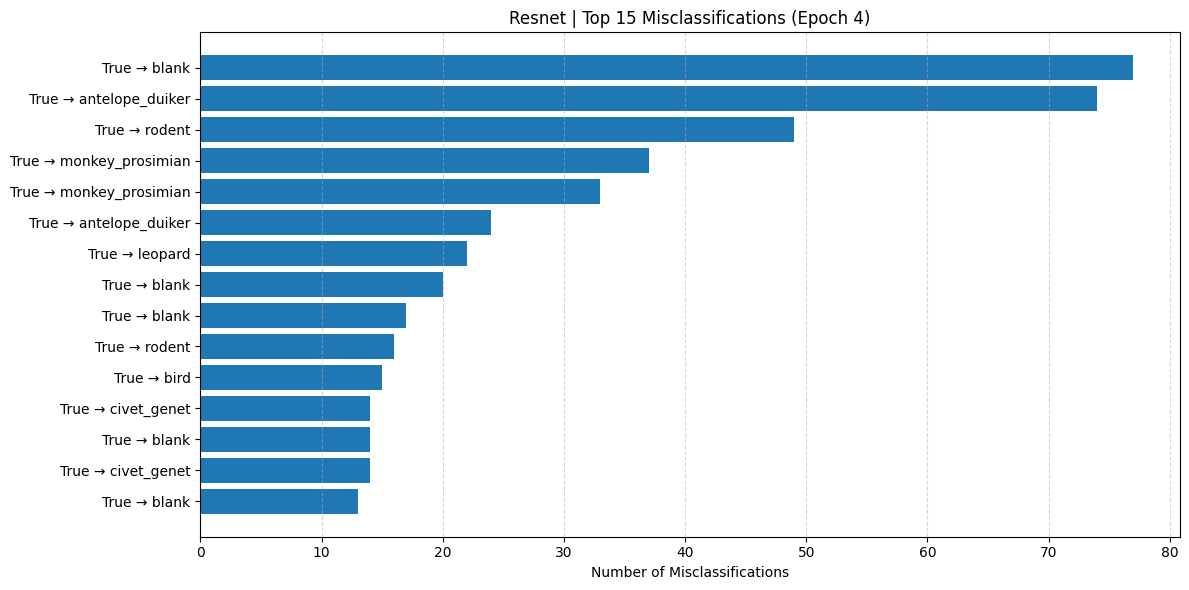


🔴 Top 15 Misclassifications — Swin (Epoch 4)
            True        Predicted  Count  Pct_of_True
 antelope_duiker            blank     55     8.885299
           blank  antelope_duiker     54     9.764919
           blank           rodent     38     6.871609
          rodent            blank     36     7.157058
monkey_prosimian  antelope_duiker     26     4.173355
           blank monkey_prosimian     20     3.616637
 antelope_duiker monkey_prosimian     19     3.069467
           blank          leopard     18     3.254973
monkey_prosimian            blank     15     2.407705
            bird            blank     13     3.170732
           blank      civet_genet     11     1.989150
     civet_genet           rodent     11     1.815182
            bird  antelope_duiker     10     2.439024
 antelope_duiker           rodent      9     1.453958
           blank             bird      8     1.446655


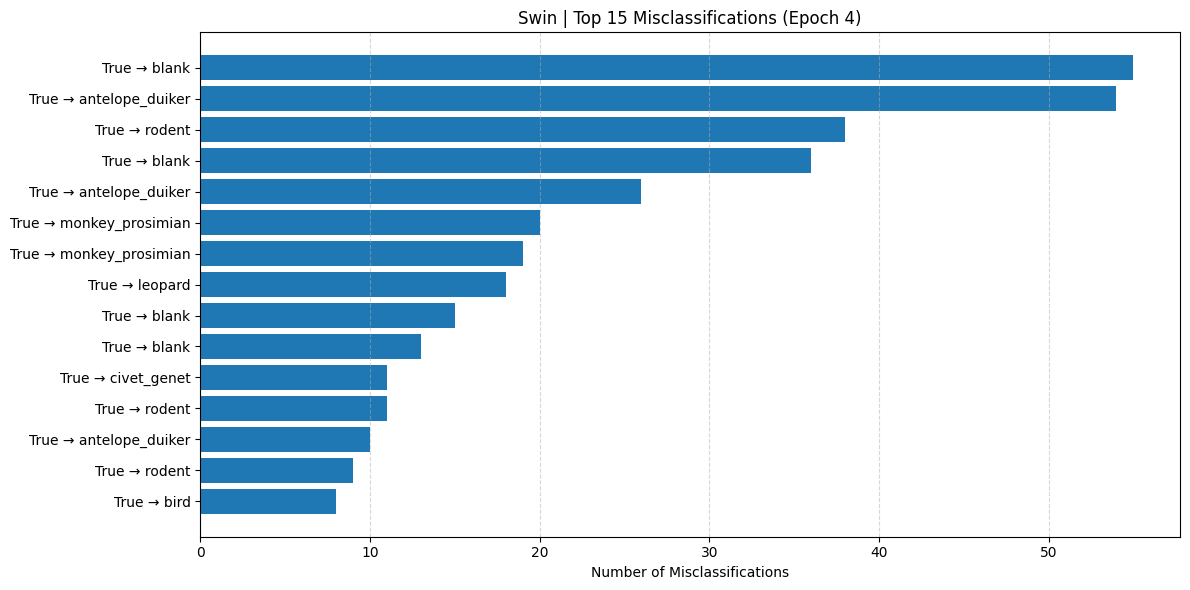


🔴 Top 15 Misclassifications — Swin Test1 (Epoch 4)
            True        Predicted  Count  Pct_of_True
           blank  antelope_duiker     68    12.296564
           blank monkey_prosimian     53     9.584087
 antelope_duiker monkey_prosimian     52     8.400646
          rodent            blank     39     7.753479
           blank           rodent     34     6.148282
 antelope_duiker            blank     31     5.008078
          rodent      civet_genet     31     6.163022
             hog  antelope_duiker     25    10.245902
monkey_prosimian  antelope_duiker     23     3.691814
            bird monkey_prosimian     21     5.121951
           blank      civet_genet     21     3.797468
            bird  antelope_duiker     19     4.634146
          rodent  antelope_duiker     13     2.584493
monkey_prosimian            blank     13     2.086677
          rodent monkey_prosimian     13     2.584493


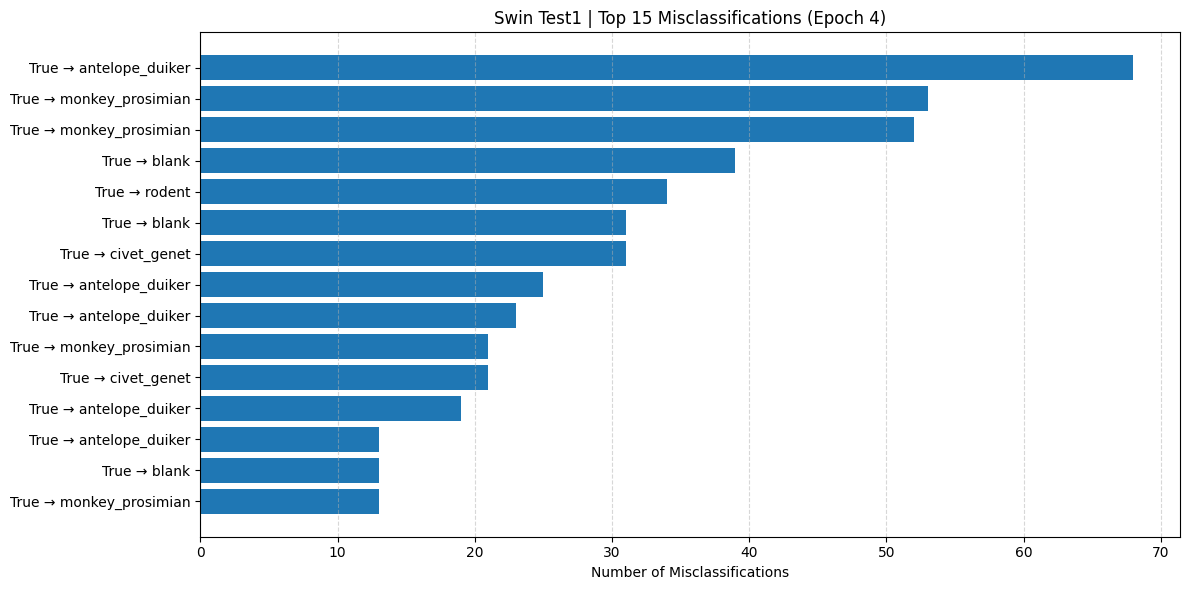


🔴 Top 15 Misclassifications — Swin Test2 (Epoch 4)
            True        Predicted  Count  Pct_of_True
          rodent            blank    242    48.111332
          rodent      civet_genet    132    26.242545
 antelope_duiker            blank     88    14.216478
monkey_prosimian  antelope_duiker     52     8.346709
           blank  antelope_duiker     52     9.403255
            bird            blank     50    12.195122
          rodent  antelope_duiker     49     9.741551
monkey_prosimian            blank     48     7.704655
          rodent             bird     48     9.542744
 antelope_duiker monkey_prosimian     45     7.269790
         leopard  antelope_duiker     40     7.092199
     civet_genet            blank     38     6.270627
           blank monkey_prosimian     37     6.690778
         leopard            blank     34     6.028369
            bird monkey_prosimian     26     6.341463


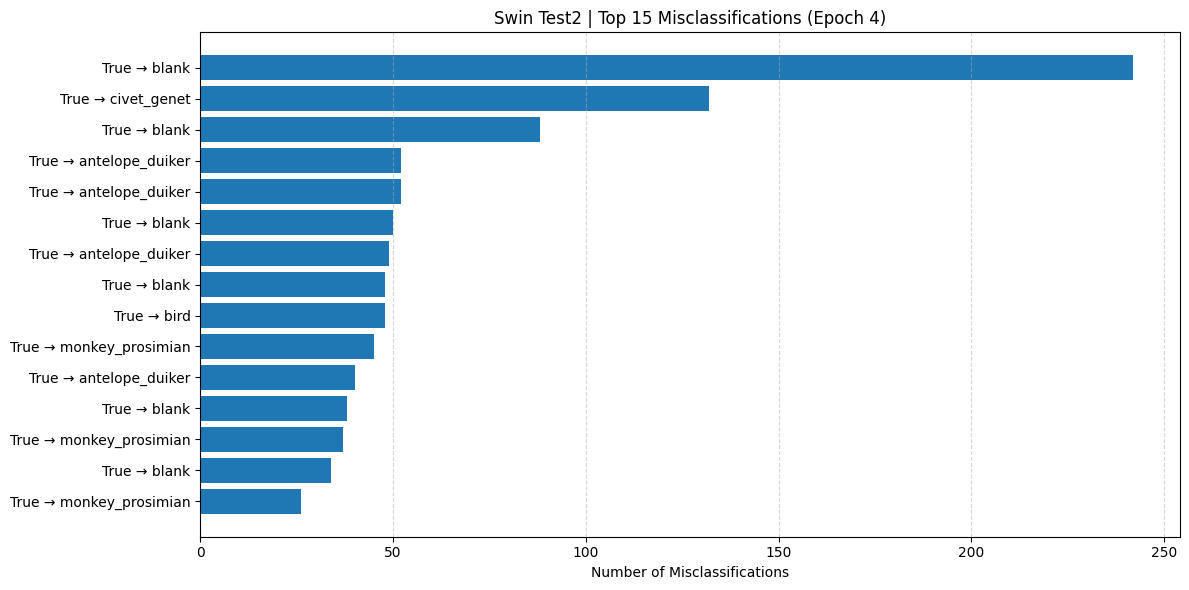


🔴 Top 15 Misclassifications — Swin Test3 (Epoch 9)
            True        Predicted  Count  Pct_of_True
           blank  antelope_duiker    247    44.665461
           blank           rodent    116    20.976492
           blank monkey_prosimian    104    18.806510
         leopard  antelope_duiker     39     6.914894
 antelope_duiker monkey_prosimian     30     4.846527
           blank      civet_genet     27     4.882459
           blank             bird     24     4.339964
         leopard monkey_prosimian     18     3.191489
         leopard      civet_genet     18     3.191489
monkey_prosimian  antelope_duiker     17     2.728732
 antelope_duiker           rodent     12     1.938611
         leopard             bird     12     2.127660
           blank              hog     11     1.989150
 antelope_duiker      civet_genet      8     1.292407
            bird monkey_prosimian      7     1.707317


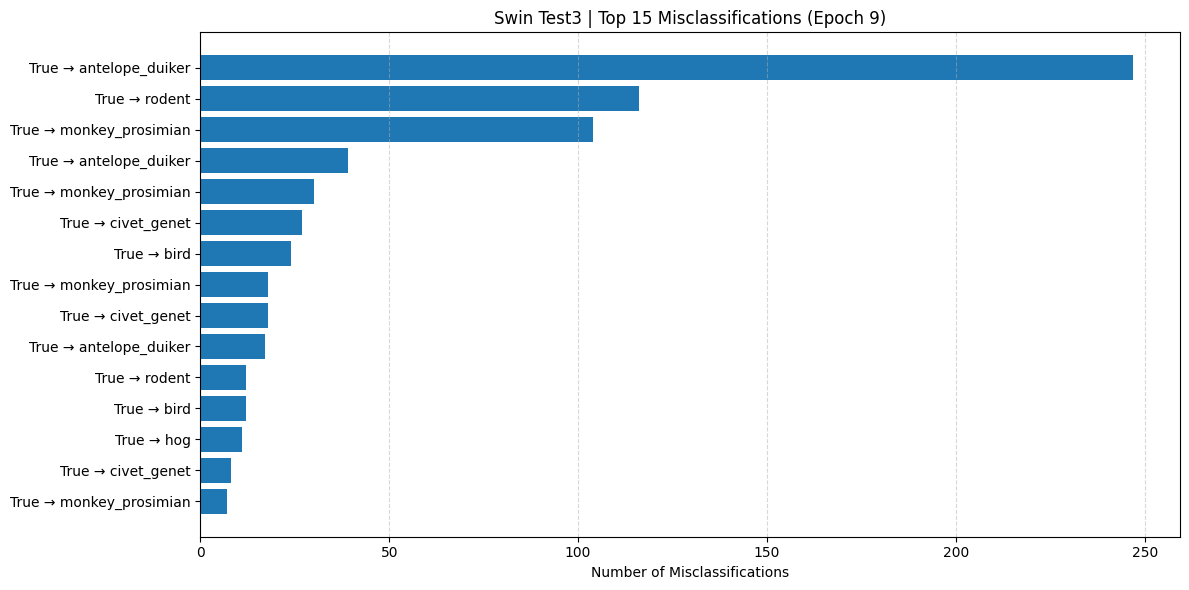


🔴 Top 15 Misclassifications — Eva (Epoch 4)
            True        Predicted  Count  Pct_of_True
 antelope_duiker            blank     11     8.270677
           blank  antelope_duiker      8     7.272727
           blank          leopard      6     5.454545
monkey_prosimian  antelope_duiker      6     5.172414
           blank             bird      5     4.545455
           blank monkey_prosimian      4     3.636364
          rodent            blank      4     3.361345
           blank           rodent      4     3.636364
 antelope_duiker      civet_genet      3     2.255639
monkey_prosimian            blank      3     2.586207
         leopard            blank      2     2.040816
 antelope_duiker             bird      2     1.503759
            bird            blank      2     2.739726
 antelope_duiker monkey_prosimian      2     1.503759
           blank      civet_genet      1     0.909091


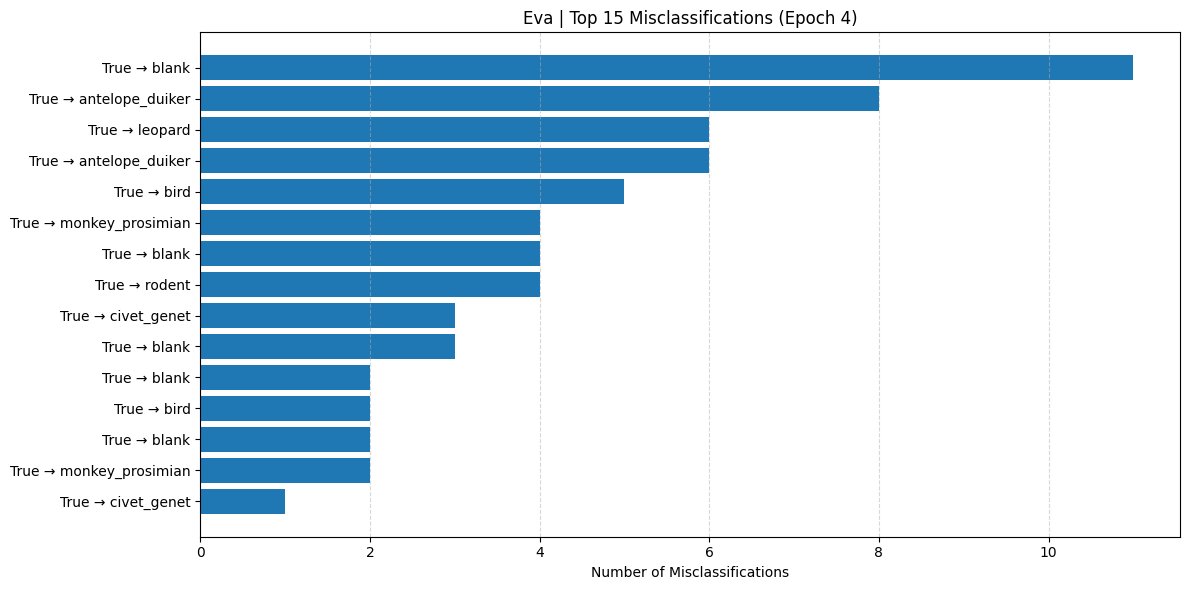

In [85]:
def plot_misclassifications(
    metrics,
    class_names,
    epoch,
    model_name,
    top_k=15,
):
    """
    Analyze and visualize top misclassifications for a given epoch.

    Args:
        metrics (list): List of epoch-wise metric dictionaries
        class_names (list): Class labels
        epoch (int): Epoch index to analyze
        model_name (str): Model name for plot titles
        top_k (int): Number of top misclassifications to display
    """

    cm = np.asarray(metrics[epoch]["confusion_matrix"])

    records = []
    for true_idx, true_label in enumerate(class_names):
        row_sum = cm[true_idx].sum()
        if row_sum == 0:
            continue

        for pred_idx, pred_label in enumerate(class_names):
            if true_idx == pred_idx:
                continue

            count = cm[true_idx, pred_idx]
            if count == 0:
                continue

            records.append(
                {
                    "True": true_label,
                    "Predicted": pred_label,
                    "Count": count,
                    "Pct_of_True": 100.0 * count / row_sum,
                }
            )

    misc_df = (
        pd.DataFrame(records)
        .sort_values("Count", ascending=False)
        .reset_index(drop=True)
    )

    print(f"\n🔴 Top {top_k} Misclassifications — {model_name} (Epoch {epoch})")
    print(misc_df.head(top_k).to_string(index=False))

    # --- Visualization ---
    top_misc = misc_df.head(top_k)

    plt.figure(figsize=(12, 6))
    plt.barh(top_misc.index, top_misc["Count"])
    plt.yticks(
        top_misc.index,
        [f"{True} → {r.Predicted}" for r in top_misc.itertuples()],
    )
    plt.xlabel("Number of Misclassifications")
    plt.title(f"{model_name} | Top {top_k} Misclassifications (Epoch {epoch})")
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_misclassifications(val_metrics, class_names, 4, "Resnet")
plot_misclassifications(val_metrics_swin, class_names, 4, "Swin")
plot_misclassifications(val_metrics_swin_test1, class_names, 4, "Swin Test1")
plot_misclassifications(val_metrics_swin_test2, class_names, 4, "Swin Test2")
plot_misclassifications(val_metrics_swin_test3, class_names, 9, "Swin Test3")
plot_misclassifications(val_metrics_eva, class_names, 4, "Eva")

In [82]:
train_df["acc"]

0    0.545852
1    0.750445
2    0.835032
3    0.881611
4    0.916950
5    0.938622
6    0.956979
7    0.968058
8    0.978570
9    0.983665
Name: acc, dtype: float64

In [ ]:
val_df["acc"]

0    0.717128
1    0.792576
2    0.830422
3    0.852256
4    0.872392
5    0.874333
6    0.878214
7    0.879670
8    0.882824
9    0.885007
Name: acc, dtype: float64

In [ ]:
train_df = pd.read_csv("resnet18/output/train_metrics.csv")
train_df["acc"]

0    0.545852
1    0.750445
2    0.835032
3    0.881611
4    0.916950
5    0.938622
6    0.956979
7    0.968058
8    0.978570
9    0.983665
Name: acc, dtype: float64

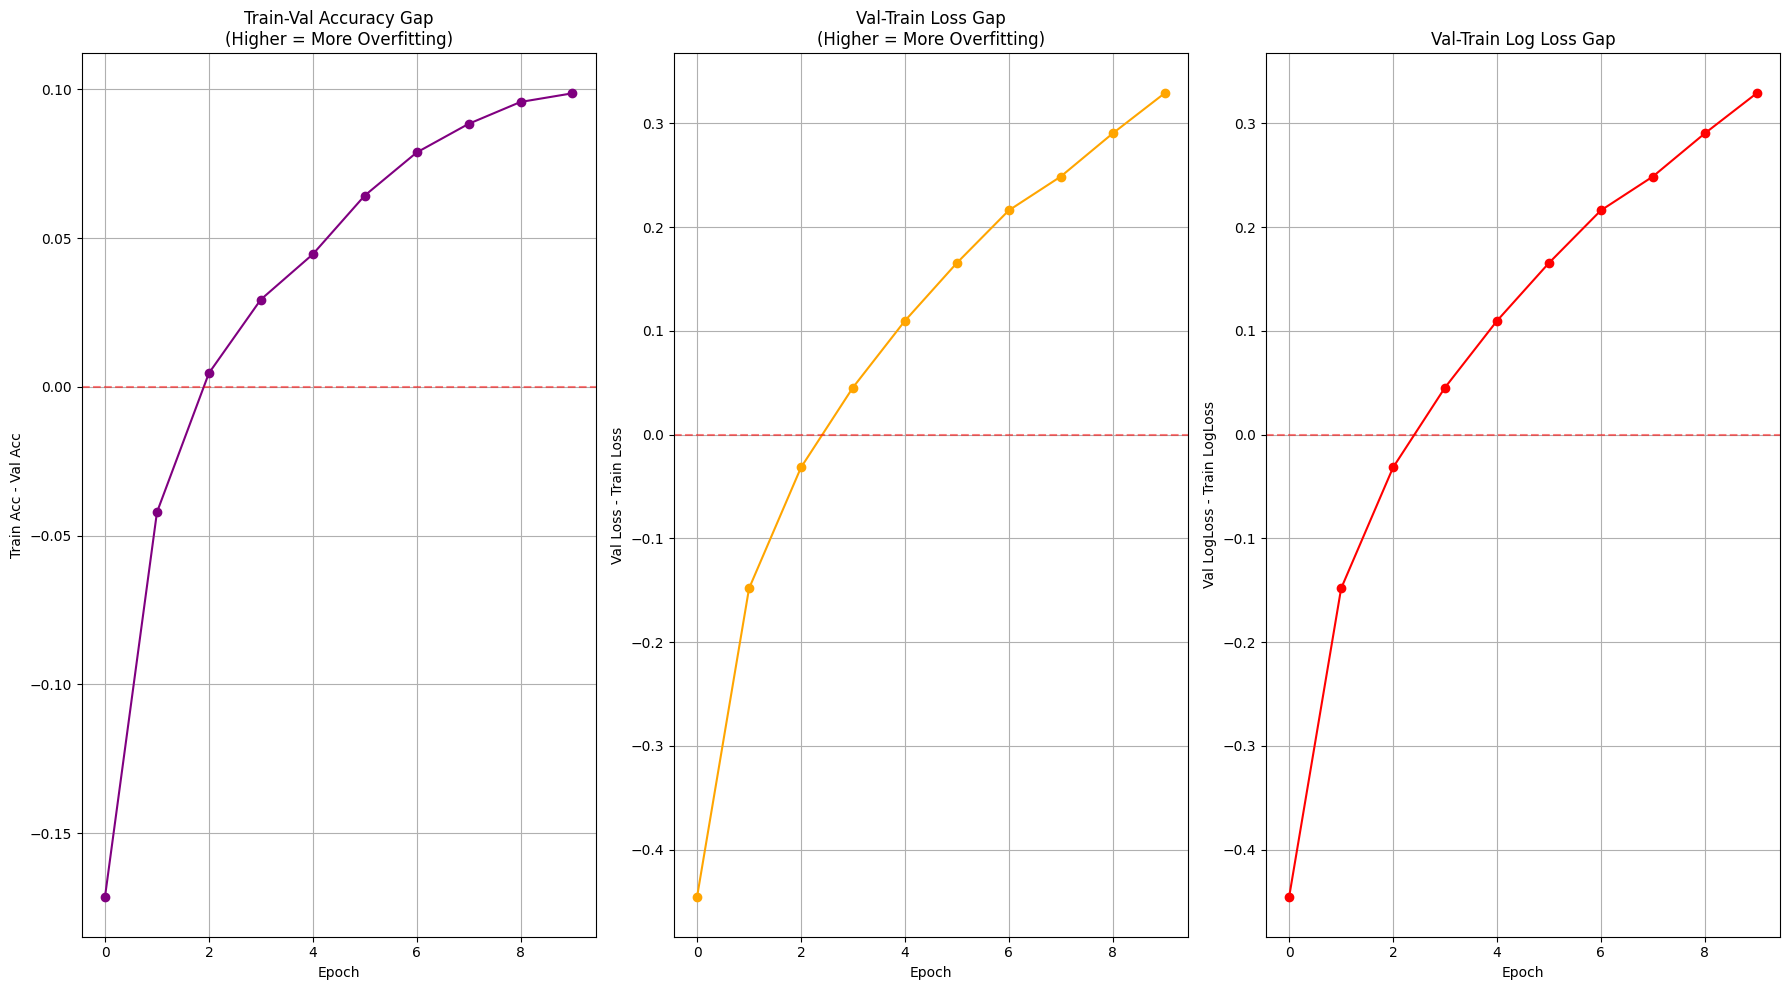


Final Overfitting Metrics (Epoch 9):
  Accuracy Gap: 0.0987 (⚠️ Overfitting)


In [ ]:
train_df = pd.read_csv("resnet18/output/train_metrics.csv")
val_df = pd.read_csv("resnet18/output/val_metrics.csv")

gap_df = pd.DataFrame(
    {
        "Epoch": train_df["epoch"],
        "Accuracy_Gap": train_df["acc"] - val_df["acc"],
        "Loss_Gap": val_df["loss"] - train_df["loss"],
        "LogLoss_Gap": val_df["log_loss"] - train_df["log_loss"],
    }
)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

axes[0].plot(gap_df["Epoch"], gap_df["Accuracy_Gap"], "o-", color="purple")
axes[0].axhline(y=0, color="r", linestyle="--", alpha=0.5)
axes[0].set_title("Train-Val Accuracy Gap\n(Higher = More Overfitting)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Acc - Val Acc")
axes[0].grid(True)

axes[1].plot(gap_df["Epoch"], gap_df["Loss_Gap"], "o-", color="orange")
axes[1].axhline(y=0, color="r", linestyle="--", alpha=0.5)
axes[1].set_title("Val-Train Loss Gap\n(Higher = More Overfitting)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Val Loss - Train Loss")
axes[1].grid(True)

axes[2].plot(gap_df["Epoch"], gap_df["LogLoss_Gap"], "o-", color="red")
axes[2].axhline(y=0, color="r", linestyle="--", alpha=0.5)
axes[2].set_title("Val-Train Log Loss Gap")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Val LogLoss - Train LogLoss")
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Overfitting Metrics (Epoch {len(train_df)-1}):")
print(
    f"  Accuracy Gap: {gap_df['Accuracy_Gap'].iloc[-1]:.4f} ({'⚠️ Overfitting' if gap_df['Accuracy_Gap'].iloc[-1] > 0.05 else '✅ Good'})"
)

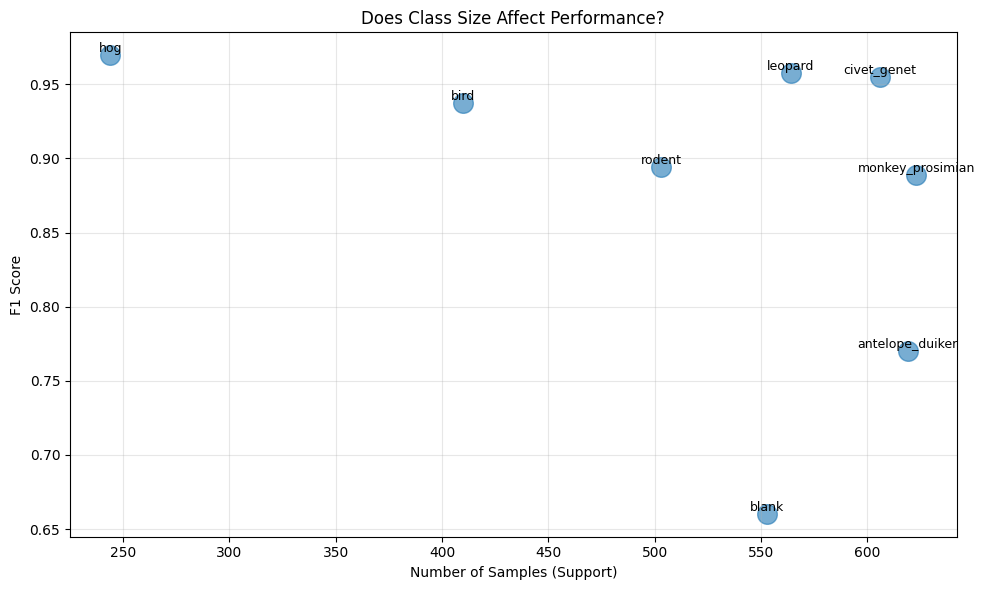


Correlation between class size and F1: -0.387
  > 0.5: Larger classes perform better ✅
  < 0.2: Performance independent of class size ⚠️


In [ ]:
# Extract support (sample counts) from final epoch
supports = [val_metrics[4][class_name]["support"] for class_name in class_names]
f1_scores = [val_metrics[4]["class_f1s"][class_name] for class_name in class_names]

plt.figure(figsize=(10, 6))
plt.scatter(supports, f1_scores, s=200, alpha=0.6)

for i, class_name in enumerate(class_names):
    plt.annotate(
        class_name, (supports[i], f1_scores[i]), fontsize=9, ha="center", va="bottom"
    )

plt.xlabel("Number of Samples (Support)")
plt.ylabel("F1 Score")
plt.title("Does Class Size Affect Performance?")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
corr = np.corrcoef(supports, f1_scores)[0, 1]
print(f"\nCorrelation between class size and F1: {corr:.3f}")
print("  > 0.5: Larger classes perform better ✅")
print("  < 0.2: Performance independent of class size ⚠️")

In [90]:
print("\n" + "=" * 60)
print("📊 TRAINING SUMMARY REPORT")
print("=" * 60)
epoch = 4

print(f"\nModel: ResNet18")
print(f"Total Epochs: {len(val_metrics)}")
print(
    f"Best Val Accuracy: {val_df.iloc[epoch]['acc']} (Epoch {val_df.iloc[epoch]['acc']})"
)
print(
    f"Best Val Loss: {val_df.iloc[epoch]['loss']:.4f} (Epoch {val_df.iloc[epoch]['loss']})"
)
print(f"Final Val Accuracy: {val_df.iloc[epoch]['acc']:.2%}")
print(f"Top-3 Accuracy: {val_df['top3_accuracy'].iloc[-1]:.2%}")

print(f"\n🎯 Per-Class Performance (Final Epoch):")
final_perf = pd.DataFrame(
    {
        "Class": class_names,
        "F1": [val_metrics[epoch]["class_f1s"][c] for c in class_names],
        "Samples": [val_metrics[epoch][c]["support"] for c in class_names],
    }
).sort_values("F1", ascending=False)
print(final_perf.to_string(index=False))

print(
    f"\n✅ Best Performing: {final_perf.iloc[epoch]['Class']} (F1={final_perf.iloc[epoch]['F1']:.3f})"
)
print(
    f"⚠️  Worst Performing: {final_perf.iloc[epoch]['Class']} (F1={final_perf.iloc[epoch]['F1']:.3f})"
)

print(f"\n📈 Training Progress:")
print(f"  Initial Val Acc: {val_df['acc'].iloc[0]:.2%}")
print(f"  Final Val Acc: {val_df['acc'].iloc[epoch]:.2%}")
print(f"  Total Improvement: +{(val_df['acc'].iloc[-1] - val_df['acc'].iloc[0]):.2%}")


📊 TRAINING SUMMARY REPORT

Model: ResNet18
Total Epochs: 10
Best Val Accuracy: 0.8723920426977195 (Epoch 0.8723920426977195)
Best Val Loss: 0.3948 (Epoch 0.3947869490674836)
Final Val Accuracy: 87.24%
Top-3 Accuracy: 97.91%

🎯 Per-Class Performance (Final Epoch):
           Class       F1  Samples
             hog 0.969574    244.0
         leopard 0.957597    564.0
     civet_genet 0.955248    606.0
            bird 0.937046    410.0
          rodent 0.894539    503.0
monkey_prosimian 0.888713    623.0
 antelope_duiker 0.770008    619.0
           blank 0.660305    553.0

✅ Best Performing: rodent (F1=0.895)
⚠️  Worst Performing: rodent (F1=0.895)

📈 Training Progress:
  Initial Val Acc: 71.71%
  Final Val Acc: 87.24%
  Total Improvement: +16.79%


In [73]:
def get_image_from_s3(name_bucket, key):
    """Get image from S3 without downloading to disk"""
    try:
        # key = os.path.join("data", key)
        response = s3.get_object(Bucket=name_bucket, Key=key)
        image = Image.open(BytesIO(response["Body"].read()))
        return image
    except Exception as e:
        print(f"Error loading, {e}")
        return None

In [74]:
count = {
    "antelope_duiker": 2474,
    "bird": 1641,
    "blank": 2213,
    "civet_genet": 2423,
    "hog": 978,
    "leopard": 2254,
    "monkey_prosimian": 2492,
    "rodent": 2013,
}

In [75]:
corr

np.float64(-0.38697272686383066)

In [76]:
f1_scores = [val_metrics[4]["class_f1s"][c] for c in class_names]
print("f1_scores", f1_scores)
support = [val_metrics[4][c]["support"] for c in class_names]
print("support", support)

f1_scores [0.7700084245998315, 0.937046004842615, 0.6603053435114504, 0.9552481692432873, 0.9695740365111561, 0.9575971731448764, 0.8887134964483031, 0.8945386064030132]
support [619.0, 410.0, 553.0, 606.0, 244.0, 564.0, 623.0, 503.0]


In [77]:
correlation = pd.DataFrame(columns=["class_size", "f1-score", "class_name", "support"])
correlation["class_size"] = count.values()
correlation["f1-score"] = f1_scores
correlation["class_name"] = class_names
correlation["support"] = support
correlation

class_size  f1-score        class_name  support
0        2474  0.770008   antelope_duiker    619.0
1        1641  0.937046              bird    410.0
2        2213  0.660305             blank    553.0
3        2423  0.955248       civet_genet    606.0
4         978  0.969574               hog    244.0
5        2254  0.957597           leopard    564.0
6        2492  0.888713  monkey_prosimian    623.0
7        2013  0.894539            rodent    503.0

In [38]:
spearman = correlation["support"].corr(correlation["f1-score"], method="spearman")
print("spearman:", spearman)

pearson = correlation["support"].corr(correlation["f1-score"], method="pearson")
print("pearson:", pearson)

# There is no correlation between class size and f1-score.

spearman: -0.4523809523809524
pearson: -0.38697272686383066


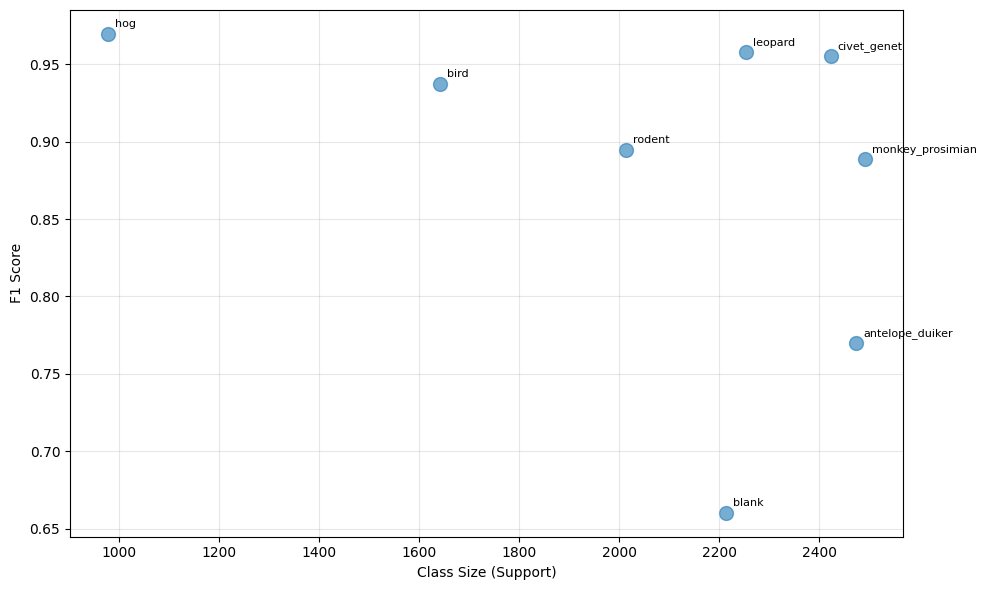

In [39]:
# Visualize to double-check
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(correlation["class_size"], correlation["f1-score"], s=100, alpha=0.6)

# Label points
for idx, row in correlation.iterrows():
    plt.annotate(
        row["class_name"],
        (row["class_size"], row["f1-score"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )

plt.xlabel("Class Size (Support)")
plt.ylabel("F1 Score")
# plt.title(f'Spearman Correlation: {spearman_corr:.3f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

key: processed/train_features/ZJ006376.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


/var/folders/4m/b6_cz0w13g31tffdygtbhty00000gn/T/ipykernel_81611/3593940405.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


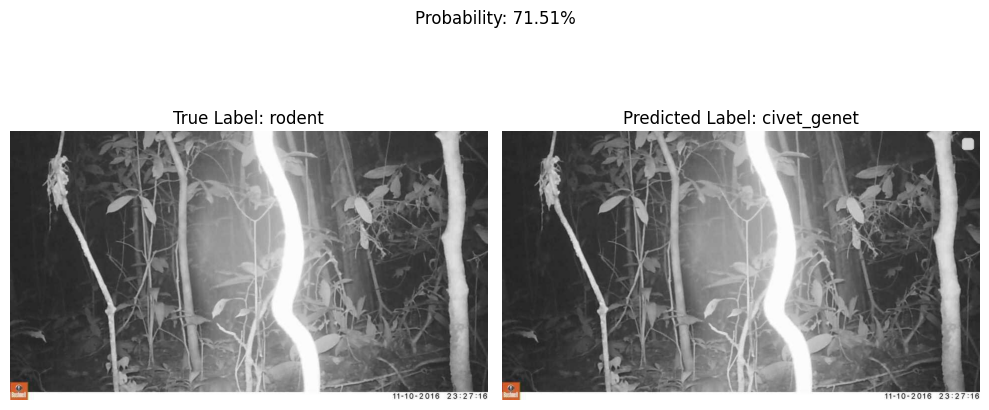

In [40]:
def specific_misclassification(mis, class_names, epoch):
    key = mis["id"] + ".jpg"
    probability = mis["probability"]
    key = os.path.join(train_folder, key)
    print(f"key: {key}")
    image = get_image_from_s3(bucket_name, key)
    print(type(image))
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Probability: {probability:.2%}")
    ax[0].imshow(np.array(image))
    ax[0].set_title(f"True Label: {mis['true_label']}")
    ax[0].axis("off")
    ax[1].imshow(np.array(image))
    ax[1].set_title(f"Predicted Label: {mis['predicted_label']}")
    ax[1].axis("off")


mis = val_metrics_swin[0]["misclassified_images"][0]

specific_misclassification(mis, class_names, 4)
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
def analyze_misclassified_images(val_metrics, epoch=-1):
    """Identify hardest samples and common failure patterns"""
    misclassified = val_metrics[epoch]["misclassified_images"]

    # Group by true class
    by_class = {}
    for img in misclassified:
        true_label = img["true_label"]
        if true_label not in by_class:
            by_class[true_label] = []
        by_class[true_label].append(img)

    # Analyze each class
    for class_name, images in by_class.items():
        print(f"\n{class_name}: {len(images)} misclassified")

        # Most common wrong predictions
        pred_counts = {}
        for img in images:
            pred = img["predicted_label"]
            pred_counts[pred] = pred_counts.get(pred, 0) + 1

        print(f"  Most commonly predicted as:")
        for pred, count in sorted(
            pred_counts.items(), key=lambda x: x[1], reverse=True
        )[:3]:
            print(f"    - {pred}: {count} times")


analyze_misclassified_images(val_metrics_swin, 4)


blank: 150 misclassified
  Most commonly predicted as:
    - antelope_duiker: 54 times
    - rodent: 38 times
    - monkey_prosimian: 20 times

monkey_prosimian: 50 misclassified
  Most commonly predicted as:
    - antelope_duiker: 26 times
    - blank: 15 times
    - bird: 5 times

rodent: 39 misclassified
  Most commonly predicted as:
    - blank: 36 times
    - civet_genet: 1 times
    - monkey_prosimian: 1 times

antelope_duiker: 96 misclassified
  Most commonly predicted as:
    - blank: 55 times
    - monkey_prosimian: 19 times
    - rodent: 9 times

bird: 28 misclassified
  Most commonly predicted as:
    - blank: 13 times
    - antelope_duiker: 10 times
    - monkey_prosimian: 3 times

civet_genet: 21 misclassified
  Most commonly predicted as:
    - rodent: 11 times
    - blank: 5 times
    - antelope_duiker: 4 times

leopard: 11 misclassified
  Most commonly predicted as:
    - blank: 6 times
    - monkey_prosimian: 3 times
    - antelope_duiker: 2 times

hog: 5 misclassifie

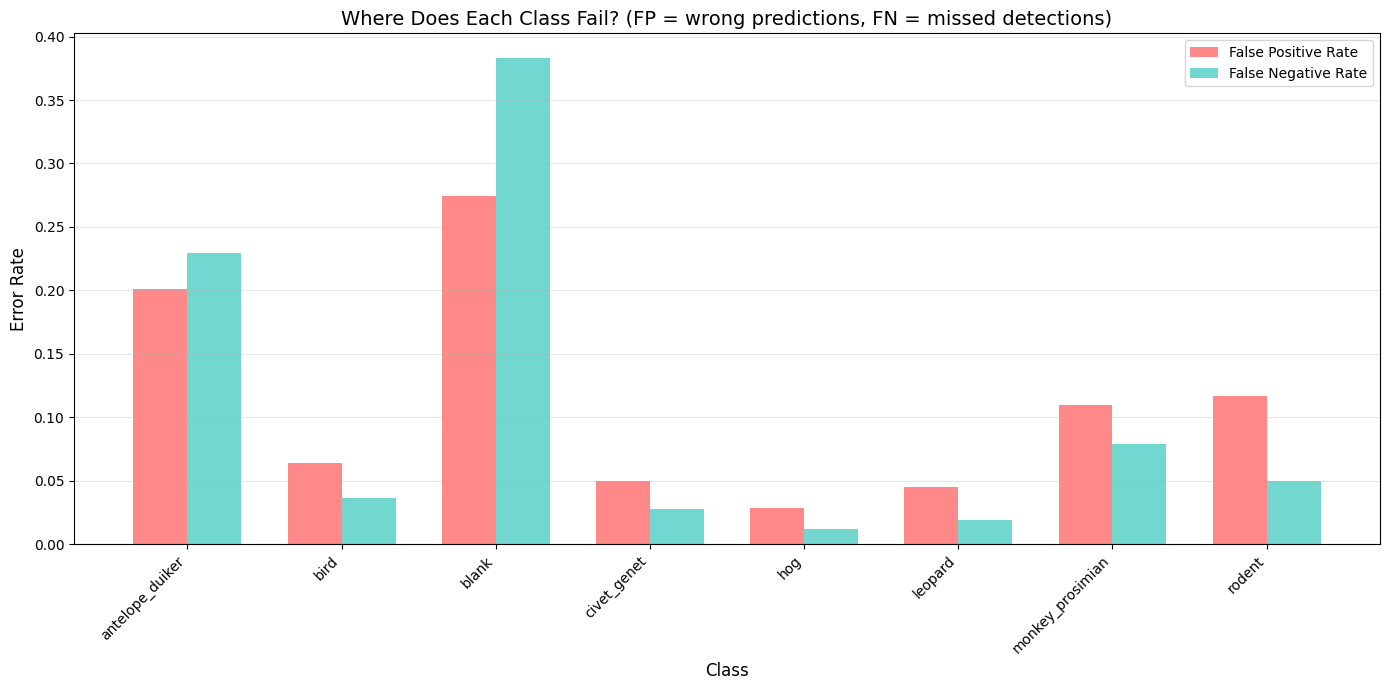

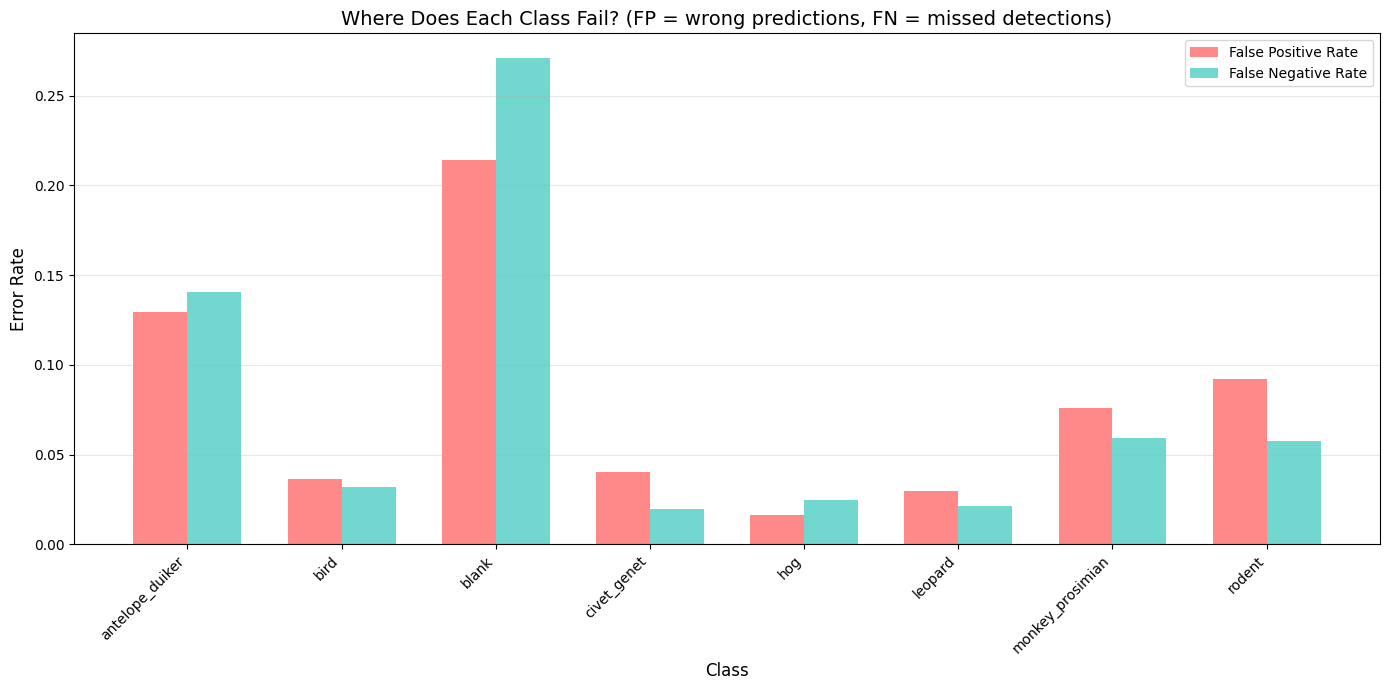

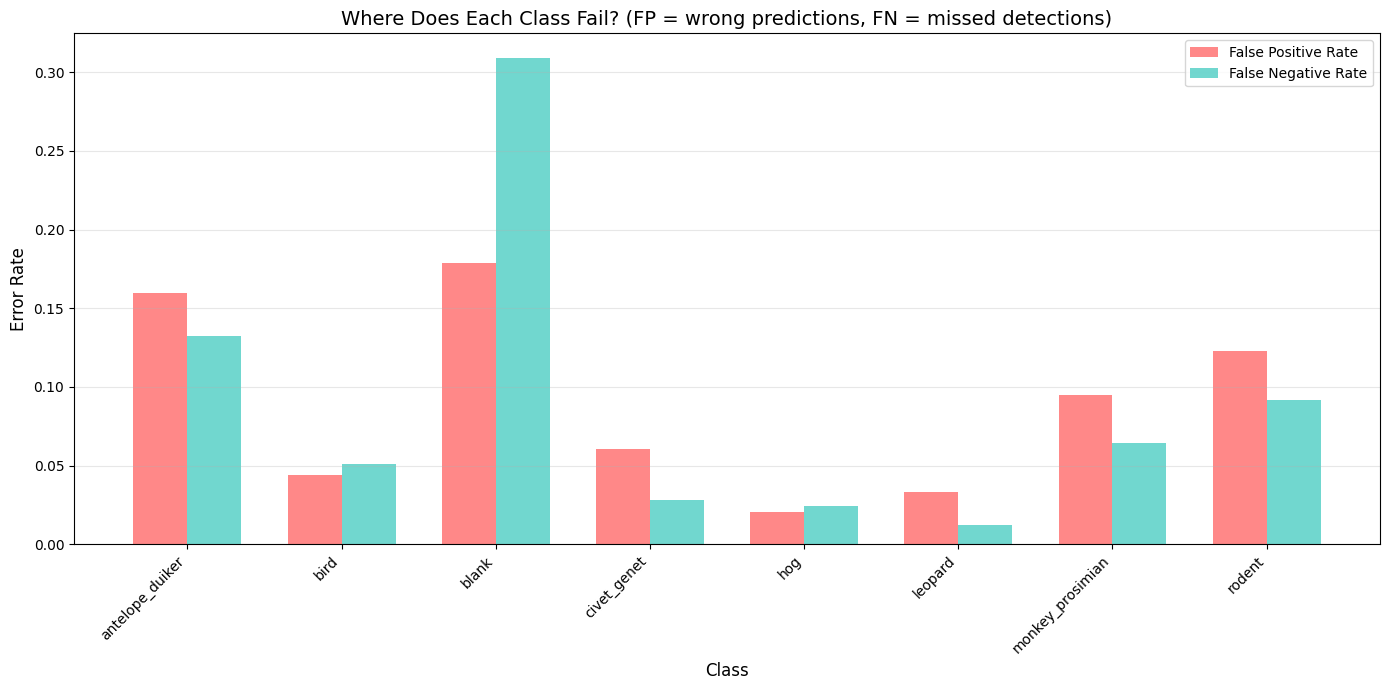

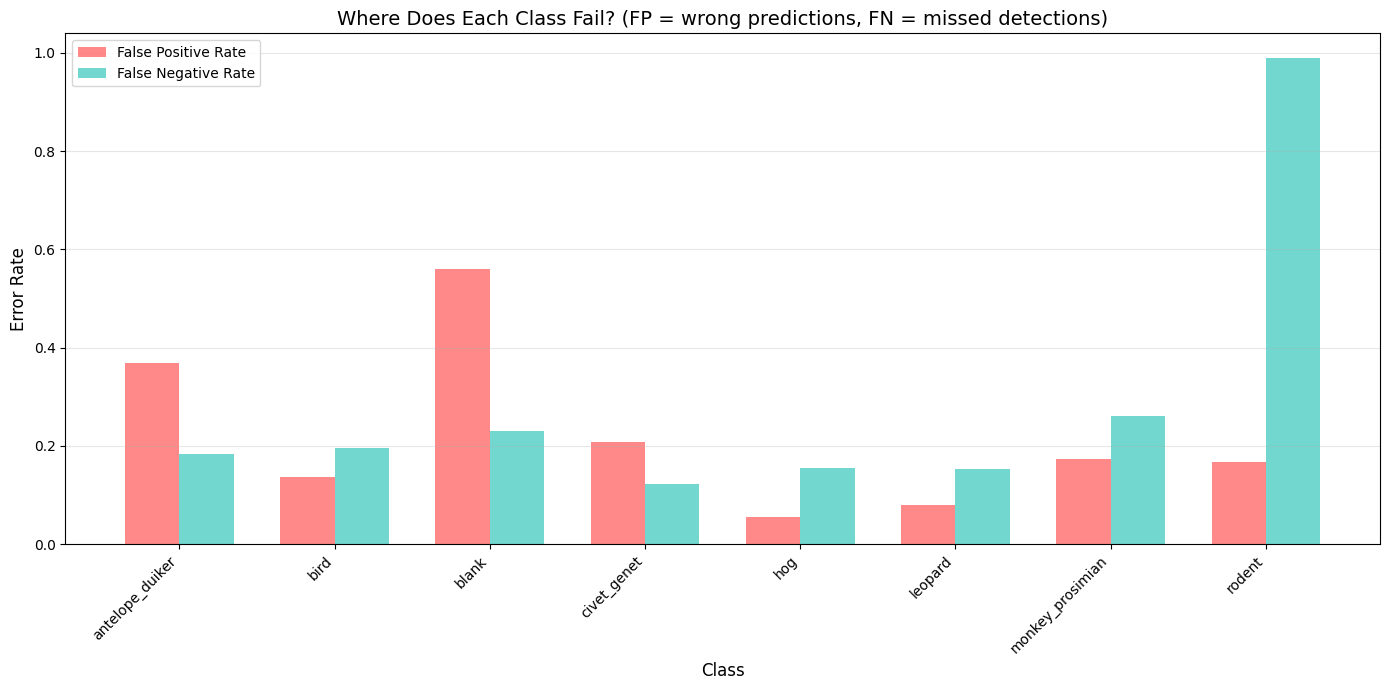

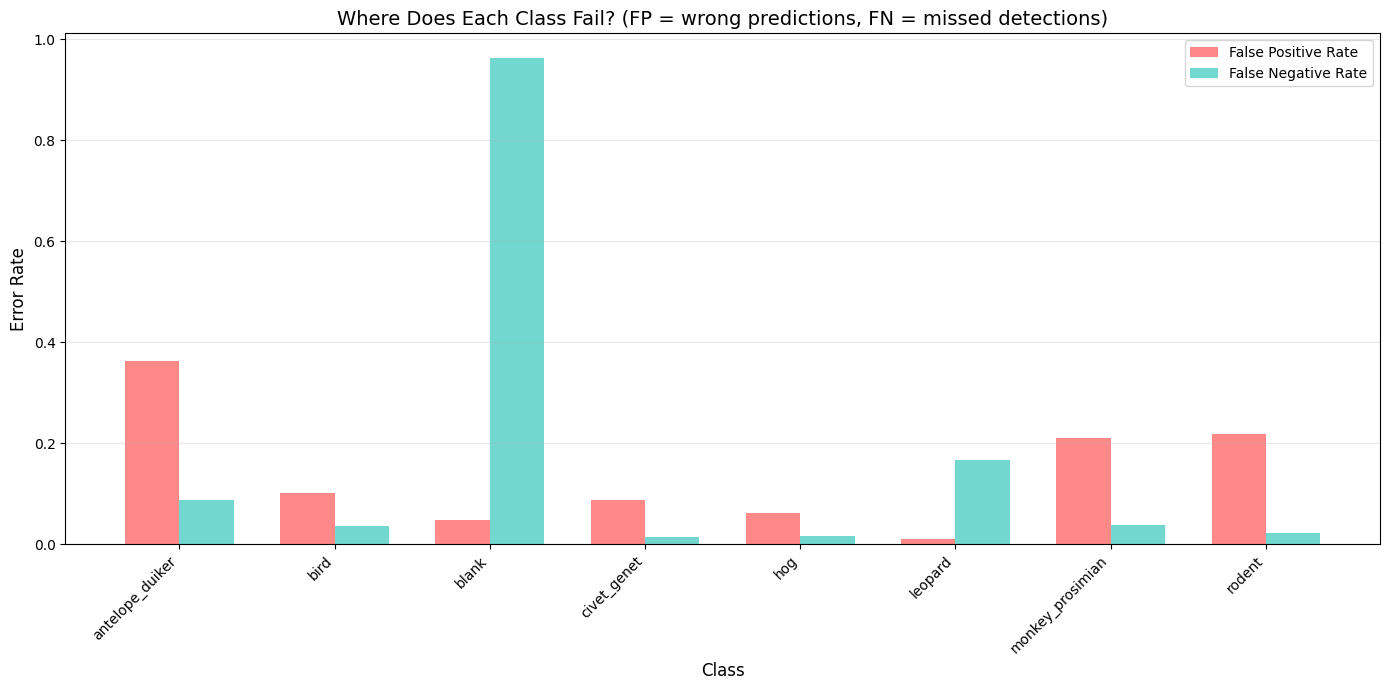

In [42]:
def analyze_fp_fn_rates(val_metrics, class_names, epoch=-1):
    """Compare FP and FN rates per class"""
    cm = np.array(val_metrics[epoch]["confusion_matrix"])

    fp_rates = []
    fn_rates = []

    for i, class_name in enumerate(class_names):
        # False Positives: sum of column i except diagonal
        fp = cm[:, i].sum() - cm[i, i]
        # False Negatives: sum of row i except diagonal
        fn = cm[i, :].sum() - cm[i, i]
        # True Positives
        tp = cm[i, i]

        fp_rate = fp / (fp + tp) if (fp + tp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

        fp_rates.append(fp_rate)
        fn_rates.append(fn_rate)

    x = np.arange(len(class_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.bar(
        x - width / 2,
        fp_rates,
        width,
        label="False Positive Rate",
        alpha=0.8,
        color="#ff6b6b",
    )
    ax.bar(
        x + width / 2,
        fn_rates,
        width,
        label="False Negative Rate",
        alpha=0.8,
        color="#4ecdc4",
    )

    ax.set_xlabel("Class", fontsize=12)
    ax.set_ylabel("Error Rate", fontsize=12)
    ax.set_title(
        "Where Does Each Class Fail? (FP = wrong predictions, FN = missed detections)",
        fontsize=14,
    )
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()


# Usage
analyze_fp_fn_rates(val_metrics, class_names)
analyze_fp_fn_rates(val_metrics_swin, class_names)
analyze_fp_fn_rates(val_metrics_swin_test1, class_names)
analyze_fp_fn_rates(val_metrics_swin_test2, class_names)
analyze_fp_fn_rates(val_metrics_swin_test3, class_names)